In [2]:
# read the file C:\Users\harsh\OneDrive - IIT Kanpur\Desktop\Thesis\Real world data\agent_positions_and_velocities_complete.csv in a dataframe
# and plot the positions of the agents at different time steps
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# read the file in a dataframe
df = pd.read_csv(r'C:\Users\harsh\Downloads\simulation_agent_positions_and_velocities_complete (1).csv')



In [5]:
df.head()

,time,x_pos_1,y_pos_1,v_x1,v_y1,x_pos_2,y_pos_2,v_x2,v_y2
0,0.03,0.19,1.36,0.00,0.0,9.69,1.36,0.0,0.0
1,0.07,0.19,1.36,0.00,0.0,9.69,1.36,0.0,0.0
2,0.10,0.19,1.36,0.18,0.0,9.69,1.36,0.0,0.0
3,0.13,0.17,1.36,0.21,0.0,9.69,1.36,0.0,0.0
4,0.17,0.17,1.36,0.21,0.0,9.69,1.36,0.0,0.0


Time Step 1: Entropy Agent1 = -5.8372, Entropy Agent2 = -5.8372, Average Entropy = -5.8372
Time Step 2: Entropy Agent1 = -5.8372, Entropy Agent2 = -103.9936, Average Entropy = -54.9154
Time Step 3: Entropy Agent1 = -87.6315, Entropy Agent2 = -5.8372, Average Entropy = -46.7343
Time Step 4: Entropy Agent1 = -5.8372, Entropy Agent2 = -5.8372, Average Entropy = -5.8372
Time Step 5: Entropy Agent1 = -83.0231, Entropy Agent2 = -5.8372, Average Entropy = -44.4301
Time Step 6: Entropy Agent1 = -84.0593, Entropy Agent2 = -5.8372, Average Entropy = -44.9482
Time Step 7: Entropy Agent1 = -5.8372, Entropy Agent2 = -5.8372, Average Entropy = -5.8372
Time Step 8: Entropy Agent1 = -5.8372, Entropy Agent2 = -5.8372, Average Entropy = -5.8372
Time Step 9: Entropy Agent1 = -5.8372, Entropy Agent2 = -5.8372, Average Entropy = -5.8372
Time Step 10: Entropy Agent1 = -5.8372, Entropy Agent2 = -5.8372, Average Entropy = -5.8372
Time Step 11: Entropy Agent1 = -5.8372, Entropy Agent2 = -5.8372, Average Entrop

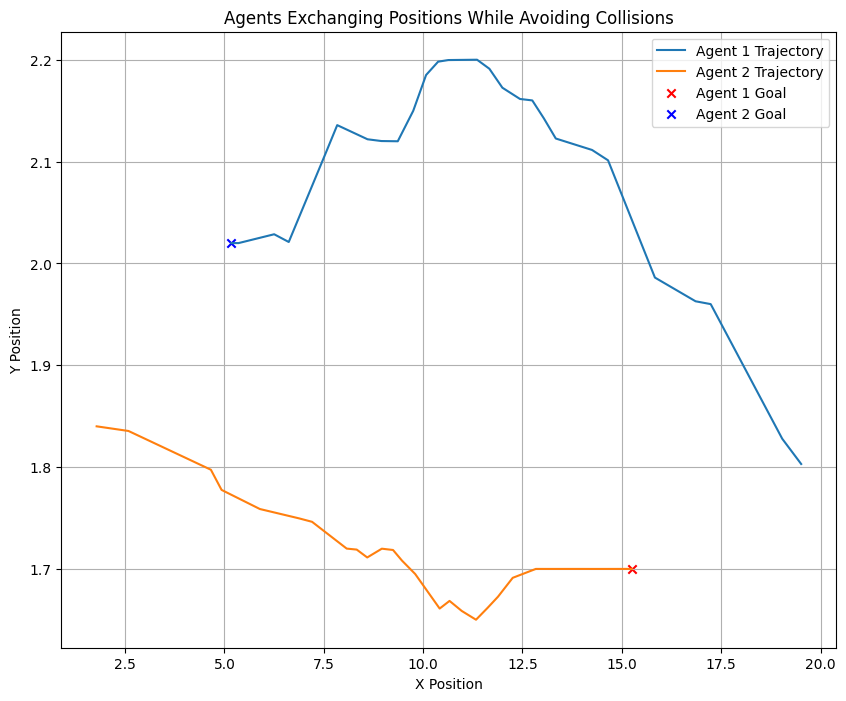

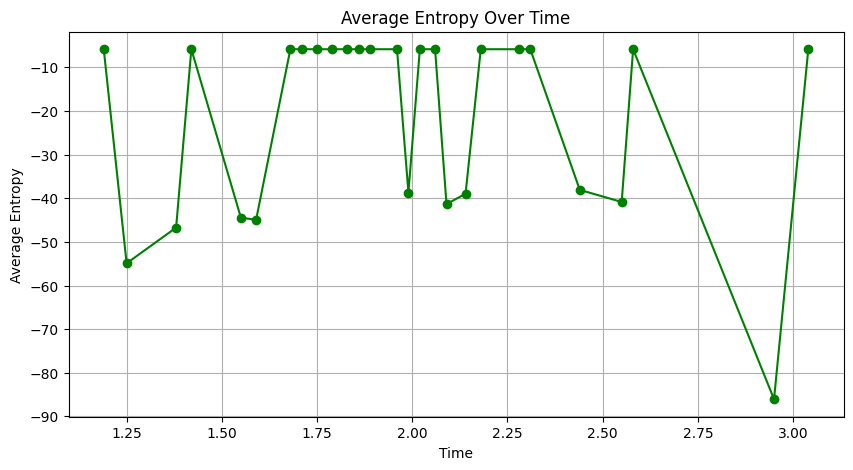

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv, det

# --- Step 1: Initialize Constants ---
DELTA_T = 0.00125  # Time step (1.25 ms)
NUM_ENSEMBLES = 2000  # Number of ensemble states per agent
TAU_0 = 3.0  # Intrinsic interaction range (seconds)
K = 1.0  # Scaling factor for interaction energy
NOISE_STD = 0.01  # Standard deviation for observation noise
MASS = 2.0  # Assumed mass for agents
GOAL_FORCE_SCALE = 1.0  # Scaling factor for goal-directed force
NUM_AGENTS = 2
STATE_SIZE = 4  # [x, y, vx, vy]
MAX_ITTR = 27  # Maximum number of iterations
INTERACTION_WINDOW = 3.0  # Interaction window in seconds
INTERACTION_RADIUS = 5.0  # Interaction radius in meters
FRAMERATE = 800  # Number of time steps in 1 second (125ms per step)

# --- Step 2: Define Functions ---
def compute_time_to_collision(r_ij, v_ij):
    """Compute the time-to-collision tau between two agents."""
    v_ij_mag2 = np.dot(v_ij, v_ij)
    if v_ij_mag2 == 0:
        return np.inf  # No relative velocity means no collision
    tau = np.dot(r_ij, v_ij) / v_ij_mag2
    return tau if tau > 0 else np.inf  # Only consider future collisions

def compute_repulsive_force(r_ij, tau, k, tau_0):
    """Compute the repulsive force between two agents."""
    if tau == np.inf:
        return np.zeros_like(r_ij)  # No force if no imminent collision
    force_magnitude = k / (tau**3) * np.exp(-tau / tau_0)
    norm = np.linalg.norm(r_ij)
    if norm == 0:
        return np.zeros_like(r_ij)
    force_direction = r_ij / norm
    return force_magnitude * force_direction

def compute_goal_force(current_position, goal_position, scale=1.0):
    """Compute the force driving the agent toward its goal."""
    direction = goal_position - current_position
    norm = np.linalg.norm(direction)
    return scale * direction / norm if norm > 1e-5 else np.zeros_like(direction)

def update_with_enks(ensemble_states, observations, R):
    """
    Apply Ensemble Kalman Smoother (EnKS) to update ensemble states.

    Parameters:
    - ensemble_states: Array of shape (NUM_ENSEMBLES, STATE_SIZE)
    - observations: Array of shape (STATE_SIZE,)
    - R: Measurement noise covariance matrix of shape (STATE_SIZE, STATE_SIZE)

    Returns:
    - updated_states: Array of shape (NUM_ENSEMBLES, STATE_SIZE)
    """
    ensemble_mean = np.mean(ensemble_states, axis=0)
    ensemble_cov = np.cov(ensemble_states, rowvar=False)
    H = np.eye(STATE_SIZE)  # Observation matrix

    try:
        kalman_gain = ensemble_cov @ H.T @ inv(H @ ensemble_cov @ H.T + R)
    except np.linalg.LinAlgError:
        kalman_gain = np.zeros_like(ensemble_cov)

    innovation = observations - H @ ensemble_mean
    updated_states = ensemble_states + (kalman_gain @ innovation).reshape(1, -1)
    return updated_states

def calculate_entropy(ensemble_states):
    """
    Calculate the entropy of the ensemble states.

    Entropy is calculated based on the covariance matrix of the ensemble.
    """
    cov = np.cov(ensemble_states, rowvar=False)
    det_cov = det(cov)
    if det_cov <= 0:
        det_cov = 1e-10  # Prevent log of non-positive
    entropy = 0.5 * (STATE_SIZE * np.log(2 * np.pi * np.e) + np.log(det_cov))
    return entropy

def prediction_function(state):
    """
    Prediction function f executed over 125ms.

    Parameters:
    - state: Array of shape (STATE_SIZE,)

    Returns:
    - predicted_state: Array of shape (STATE_SIZE,)
    """
    # Simple linear prediction: state at next time step
    predicted_state = state.copy()
    predicted_state[:2] += state[2:] * DELTA_T  # Update position based on velocity
    return predicted_state

# --- Step 3: Load CSV Data ---
csv_filepath = r'C:\\Users\\harsh\\OneDrive - IIT Kanpur\\Desktop\\Thesis\\Real world data\\agent_positions_and_velocities_complete.csv'
data = pd.read_csv(csv_filepath)

# Extract data for both agents
times = data['time'].values
positions_agent1 = data[['x_pos_1', 'y_pos_1']].values
velocities_agent1 = data[['v_x1', 'v_y1']].values
positions_agent2 = data[['x_pos_2', 'y_pos_2']].values
velocities_agent2 = data[['v_x2', 'v_y2']].values

NUM_TIME_STEPS = len(times)

# --- Step 4: Initialize Ensemble States for Both Agents ---
# Agent 1
initial_state_agent1 = np.hstack((positions_agent1[0], velocities_agent1[0]))  # [x, y, vx, vy]
ensemble_states_agent1 = np.tile(initial_state_agent1, (NUM_ENSEMBLES, 1))  # Shape: (NUM_ENSEMBLES, 4)
ensemble_states_agent1 += np.random.normal(0, NOISE_STD, ensemble_states_agent1.shape)

# Agent 2
initial_state_agent2 = np.hstack((positions_agent2[0], velocities_agent2[0]))  # [x, y, vx, vy]
ensemble_states_agent2 = np.tile(initial_state_agent2, (NUM_ENSEMBLES, 1))  # Shape: (NUM_ENSEMBLES, 4)
ensemble_states_agent2 += np.random.normal(0, NOISE_STD, ensemble_states_agent2.shape)

# Define Goal Positions (swap initial positions)
goal_positions_agent1 = positions_agent2[0].copy()
goal_positions_agent2 = positions_agent1[0].copy()

# --- Step 5: Initialize Covariance Matrices ---
# State covariance matrix (Initial)
P = np.eye(STATE_SIZE) * 0.1  # Can be tuned based on prior knowledge

# Process noise covariance matrix
Q = np.eye(STATE_SIZE) * 0.01  # Represents uncertainty in the process model

# Measurement noise covariance matrices
R_agent1 = np.eye(STATE_SIZE) * NOISE_STD**2  # For Agent 1
R_agent2 = np.eye(STATE_SIZE) * NOISE_STD**2  # For Agent 2

# --- Step 6: Initialize Variables for Simulation ---
entropy_values_agent1 = []
entropy_values_agent2 = []
avg_entropy_values = []
trajectory_agent1 = []
trajectory_agent2 = []

# --- Step 7: Simulation Loop ---
for t in range(NUM_TIME_STEPS):
    # Current observed positions and velocities
    current_obs_pos1 = positions_agent1[t]
    current_obs_vel1 = velocities_agent1[t]
    current_obs_pos2 = positions_agent2[t]
    current_obs_vel2 = velocities_agent2[t]
    
    # --- Run 3 Iterations of EnKS and MLE ---
    for iteration in range(3):
        # --- Calculate Forces for Agent 1 ---
        forces_agent1 = np.zeros((NUM_ENSEMBLES, 2))  # Forces for Agent 1 ensembles
        for e in range(NUM_ENSEMBLES):
            total_force = np.zeros(2)
            # Compute repulsive force from Agent 2
            r_ij = ensemble_states_agent2[e, :2] - ensemble_states_agent1[e, :2]
            v_ij = current_obs_vel2 - current_obs_vel1
            tau = compute_time_to_collision(r_ij, v_ij)
            FAvoid = compute_repulsive_force(r_ij, tau, K, TAU_0)
            total_force += FAvoid
            # Add goal-directed force
            goal_force = compute_goal_force(ensemble_states_agent1[e, :2], goal_positions_agent1, GOAL_FORCE_SCALE)
            total_force += goal_force
            forces_agent1[e] = total_force
        
        # --- Calculate Forces for Agent 2 ---
        forces_agent2 = np.zeros((NUM_ENSEMBLES, 2))  # Forces for Agent 2 ensembles
        for e in range(NUM_ENSEMBLES):
            total_force = np.zeros(2)
            # Compute repulsive force from Agent 1
            r_ij = ensemble_states_agent1[e, :2] - ensemble_states_agent2[e, :2]
            v_ij = current_obs_vel1 - current_obs_vel2
            tau = compute_time_to_collision(r_ij, v_ij)
            FAvoid = compute_repulsive_force(r_ij, tau, K, TAU_0)
            total_force += FAvoid
            # Add goal-directed force
            goal_force = compute_goal_force(ensemble_states_agent2[e, :2], goal_positions_agent2, GOAL_FORCE_SCALE)
            total_force += goal_force
            forces_agent2[e] = total_force

        # --- Update Velocities and Positions for Agent 1 ---
        # Update observed velocities based on mean force
        observed_velocities_agent1 = current_obs_vel1 + (forces_agent1.mean(axis=0) / MASS) * DELTA_T
        # Update ensemble positions
        ensemble_states_agent1[:, :2] += (forces_agent1 / MASS) * DELTA_T
        ensemble_states_agent1[:, 2:] = observed_velocities_agent1  # Update velocities

        # --- Update Velocities and Positions for Agent 2 ---
        observed_velocities_agent2 = current_obs_vel2 + (forces_agent2.mean(axis=0) / MASS) * DELTA_T
        # Update ensemble positions
        ensemble_states_agent2[:, :2] += (forces_agent2 / MASS) * DELTA_T
        ensemble_states_agent2[:, 2:] = observed_velocities_agent2  # Update velocities

        # --- Apply EnKS to Update Ensemble States for Agent 1 ---
        # Observation vector: [x, y, vx, vy]
        observations_agent1 = np.array([current_obs_pos1[0], current_obs_pos1[1], observed_velocities_agent1[0], observed_velocities_agent1[1]])
        updated_states_agent1 = update_with_enks(ensemble_states_agent1, observations_agent1, R_agent1)
        ensemble_states_agent1 = updated_states_agent1  # Shape remains (NUM_ENSEMBLES, 4)

        # --- Apply EnKS to Update Ensemble States for Agent 2 ---
        observations_agent2 = np.array([current_obs_pos2[0], current_obs_pos2[1], observed_velocities_agent2[0], observed_velocities_agent2[1]])
        updated_states_agent2 = update_with_enks(ensemble_states_agent2, observations_agent2, R_agent2)
        ensemble_states_agent2 = updated_states_agent2  # Shape remains (NUM_ENSEMBLES, 4)

        # --- M-Step: Update Q and R using MLE ---
        # Update Q (Process Noise Covariance)
        Q = np.zeros((STATE_SIZE, STATE_SIZE))
        for agent_states in [ensemble_states_agent1, ensemble_states_agent2]:
            diff = agent_states - np.mean(agent_states, axis=0)
            Q += np.cov(diff, rowvar=False)
        Q /= NUM_AGENTS

        # Update R_agent1 and R_agent2 (Measurement Noise Covariance)
        innovations_agent1 = []
        innovations_agent2 = []
        for e in range(NUM_ENSEMBLES):
            innov_agent1 = observations_agent1 - ensemble_states_agent1[e]
            innov_agent2 = observations_agent2 - ensemble_states_agent2[e]
            innovations_agent1.append(innov_agent1)
            innovations_agent2.append(innov_agent2)
        innovations_agent1 = np.array(innovations_agent1)
        innovations_agent2 = np.array(innovations_agent2)

        if NUM_ENSEMBLES > 1:
            R_agent1 = np.cov(innovations_agent1, rowvar=False) + 1e-6 * np.eye(STATE_SIZE)  # Adding regularization
            R_agent2 = np.cov(innovations_agent2, rowvar=False) + 1e-6 * np.eye(STATE_SIZE)  # Adding regularization
        else:
            # If only one ensemble, covariance is not defined; use previous R
            pass

    # --- Calculate and Store Entropy for Each Agent ---
    entropy_agent1 = calculate_entropy(ensemble_states_agent1)
    entropy_agent2 = calculate_entropy(ensemble_states_agent2)
    avg_entropy = (entropy_agent1 + entropy_agent2) / 2
    entropy_values_agent1.append(entropy_agent1)
    entropy_values_agent2.append(entropy_agent2)
    avg_entropy_values.append(avg_entropy)
    print(f"Time Step {t+1}: Entropy Agent1 = {entropy_agent1:.4f}, Entropy Agent2 = {entropy_agent2:.4f}, Average Entropy = {avg_entropy:.4f}")

    # --- Store Mean Trajectory for Visualization ---
    trajectory_agent1.append(np.mean(ensemble_states_agent1[:, :2], axis=0))
    trajectory_agent2.append(np.mean(ensemble_states_agent2[:, :2], axis=0))

    # --- Interaction Window Logic ---
    # Determine the current window
    current_time = times[t]
    window_start_time = current_time - INTERACTION_WINDOW
    # Select agents within INTERACTION_RADIUS
    # Placeholder for neighbor selection; implement as needed based on dataset

# --- Step 8: Save Results ---
# Uncomment the following lines to save the results
# np.save('agent1_positions.npy', np.array(trajectory_agent1))
# np.save('agent2_positions.npy', np.array(trajectory_agent2))
# np.save('entropy.npy', np.array(avg_entropy_values))
# np.save('times.npy', times)

# --- Step 9: Visualization ---
trajectory_agent1 = np.array(trajectory_agent1)
trajectory_agent2 = np.array(trajectory_agent2)

plt.figure(figsize=(10, 8))
plt.plot(trajectory_agent1[:, 0], trajectory_agent1[:, 1], label="Agent 1 Trajectory")
plt.plot(trajectory_agent2[:, 0], trajectory_agent2[:, 1], label="Agent 2 Trajectory")
plt.scatter(goal_positions_agent1[0], goal_positions_agent1[1], color='red', label="Agent 1 Goal", marker='x')
plt.scatter(goal_positions_agent2[0], goal_positions_agent2[1], color='blue', label="Agent 2 Goal", marker='x')
plt.title("Agents Exchanging Positions While Avoiding Collisions")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid()
plt.show()

# --- Step 10: Plot Entropy Over Time ---
plt.figure(figsize=(10, 5))
plt.plot(times[:len(avg_entropy_values)], avg_entropy_values, marker='o', linestyle='-', color='green')
plt.title("Average Entropy Over Time")
plt.xlabel("Time")
plt.ylabel("Average Entropy")
plt.grid()
plt.show()

In [52]:
import numpy as np
import pandas as pd
import math
import sys

# --- Step 1: Initialize Constants ---
DELTA_T = 0.125  # Time step (1.25 ms)
NUM_ENSEMBLES = 2000  # Number of ensemble states per agent
TAU_0 = 3.0  # Intrinsic interaction range (seconds)
K = 2.0  # Scaling factor for interaction energy
NOISE_STD = 0.01  # Standard deviation for observation noise
MASS = 2.0  # Assumed mass for agents
GOAL_FORCE_SCALE = 2.0  # Scaling factor for goal-directed force
NUM_AGENTS = 2
STATE_SIZE = 4  # [x, y, vx, vy]
MAX_ITERATIONS = 27  # Maximum simulation steps

# --- Step 2: Define Functions ---

def load_csv(file_path):
    """
    Load CSV data into agent1_data and agent2_data lists.

    The CSV is expected to have the following columns:
    time, x_pos_1, y_pos_1, v_x1, v_y1, x_pos_2, y_pos_2, v_x2, v_y2
    """
    try:
        data = pd.read_csv(file_path)
    except Exception as e:
        print(f"Error: Could not open file {file_path}. Exception: {e}")
        sys.exit(1)

    agent1_data = []
    agent2_data = []

    for index, row in data.iterrows():
        agent1_state = {
            'x_pos': row['x_pos_1'],
            'y_pos': row['y_pos_1'],
            'v_x': row['v_x1'],
            'v_y': row['v_y1']
        }
        agent2_state = {
            'x_pos': row['x_pos_2'],
            'y_pos': row['y_pos_2'],
            'v_x': row['v_x2'],
            'v_y': row['v_y2']
        }
        agent1_data.append(agent1_state)
        agent2_data.append(agent2_state)

    return agent1_data, agent2_data

def compute_time_to_collision(r_ij, v_ij):
    """
    Compute the time-to-collision tau between two agents.

    Parameters:
    - r_ij: Relative position vector (numpy array)
    - v_ij: Relative velocity vector (numpy array)

    Returns:
    - tau: Time to collision (float)
    """
    v_ij_mag2 = np.dot(v_ij, v_ij)
    if v_ij_mag2 == 0.0:
        return np.inf  # No relative velocity means no collision
    tau = np.dot(r_ij, v_ij) / v_ij_mag2
    return tau if tau > 0 else np.inf  # Only consider future collisions

def compute_repulsive_force(r_ij, tau, k, tau_0):
    """
    Compute the repulsive force between two agents.

    Parameters:
    - r_ij: Relative position vector (numpy array)
    - tau: Time to collision (float)
    - k: Scaling factor (float)
    - tau_0: Intrinsic interaction range (float)

    Returns:
    - FAvoid: Repulsive force vector (numpy array)
    """
    if tau == np.inf:
        return np.zeros(2)  # No force if no imminent collision
    force_magnitude = k / (tau**3) * np.exp(-tau / tau_0)
    norm = np.linalg.norm(r_ij)
    if norm == 0.0:
        return np.zeros(2)
    force_direction = r_ij / norm
    return force_magnitude * force_direction

def compute_goal_force(current_position, goal_position, scale=1.0):
    """
    Compute the goal-directed force for an agent.

    Parameters:
    - current_position: Current position vector (numpy array)
    - goal_position: Goal position vector (numpy array)
    - scale: Scaling factor (float)

    Returns:
    - goal_force: Goal-directed force vector (numpy array)
    """
    direction = goal_position - current_position
    norm = np.linalg.norm(direction)
    return scale * (direction / norm) if norm > 1e-5 else np.zeros(2)

def update_with_enks(ensemble_states, observations, R_cov):
    """
    Apply Ensemble Kalman Smoother (EnKS) to update ensemble states.

    Parameters:
    - ensemble_states: Nx4 numpy array of ensemble states
    - observations: 4-element numpy array of observations [x, y, vx, vy]
    - R_cov: 4x4 measurement noise covariance matrix

    Returns:
    - updated_states: Nx4 numpy array of updated ensemble states
    """
    ensemble_mean = np.mean(ensemble_states, axis=0)  # Shape: (4,)
    ensemble_diff = ensemble_states - ensemble_mean  # Shape: (N,4)
    ensemble_cov = np.dot(ensemble_diff.T, ensemble_diff) / (ensemble_states.shape[0] - 1)  # Shape: (4,4)
    H = np.eye(STATE_SIZE)  # Observation matrix

    S = np.dot(H, np.dot(ensemble_cov, H.T)) + R_cov  # Innovation covariance
    try:
        kalman_gain = np.dot(np.dot(ensemble_cov, H.T), np.linalg.inv(S))  # Shape: (4,4)
    except np.linalg.LinAlgError:
        kalman_gain = np.zeros_like(ensemble_cov)

    # Innovation: observation - ensemble_mean (since H is identity)
    innovation = observations - np.dot(H, ensemble_mean)  # Shape: (4,)

    # Update ensemble states
    updated_states = ensemble_states + np.dot(kalman_gain, innovation).T  # Broadcasting to Nx4

    return updated_states

def calculate_entropy(cov_matrix):
    """
    Calculate the entropy based on the covariance matrix.

    Parameters:
    - cov_matrix: 4x4 covariance matrix (numpy array)

    Returns:
    - entropy: Entropy value (float)
    """
    det_cov = np.linalg.det(cov_matrix)
    if det_cov <= 0.0 or np.isnan(det_cov):
        det_cov = 1e-10  # Prevent log of non-positive
    entropy = 0.5 * (STATE_SIZE * np.log(2.0 * math.pi * math.e) + np.log(det_cov))
    if np.isnan(entropy):
        entropy = 0.0
    return entropy

def kalman_gain_and_correction(agent1_measurement, agent2_measurement, ensemble, P1, Q_cov1, P2, Q_cov2, R_cov):
    """
    Perform Kalman Gain calculation and Correction Step for both agents.

    Parameters:
    - agent1_measurement: Dict with keys ['x_pos', 'y_pos', 'v_x', 'v_y']
    - agent2_measurement: Dict with keys ['x_pos', 'y_pos', 'v_x', 'v_y']
    - ensemble: List of ensemble members, each is a list of two agent states
    - P1: State covariance matrix for Agent 1 (4x4 numpy array)
    - Q_cov1: Process noise covariance matrix for Agent 1 (4x4 numpy array)
    - P2: State covariance matrix for Agent 2 (4x4 numpy array)
    - Q_cov2: Process noise covariance matrix for Agent 2 (4x4 numpy array)
    - R_cov: Measurement noise covariance matrix (4x4 numpy array)
    """
    # Predict Step
    P1 += Q_cov1
    P2 += Q_cov2

    # Calculate Kalman Gains
    try:
        S1 = P1 + R_cov
        K1 = np.dot(P1, np.linalg.inv(S1))
    except np.linalg.LinAlgError:
        K1 = np.zeros_like(P1)

    try:
        S2 = P2 + R_cov
        K2 = np.dot(P2, np.linalg.inv(S2))
    except np.linalg.LinAlgError:
        K2 = np.zeros_like(P2)

    # Update ensemble members
    for n in range(len(ensemble)):
        # Agent 1 correction
        state1 = ensemble[n][0]
        measurement1 = np.array([agent1_measurement['x_pos'], agent1_measurement['y_pos'],
                                 agent1_measurement['v_x'], agent1_measurement['v_y']])
        state_vector1 = np.array([state1['x_pos'], state1['y_pos'], state1['v_x'], state1['v_y']])
        ensemble_states = K1.dot(measurement1 - state_vector1)
        state1['x_pos'] += ensemble_states[0]
        state1['y_pos'] += ensemble_states[1]
        state1['v_x'] += ensemble_states[2]
        state1['v_y'] += ensemble_states[3]

        # Agent 2 correction
        state2 = ensemble[n][1]
        measurement2 = np.array([agent2_measurement['x_pos'], agent2_measurement['y_pos'],
                                 agent2_measurement['v_x'], agent2_measurement['v_y']])
        state_vector2 = np.array([state2['x_pos'], state2['y_pos'], state2['v_x'], state2['v_y']])
        ensemble_states = K2.dot(measurement2 - state_vector2)
        state2['x_pos'] += ensemble_states[0]
        state2['y_pos'] += ensemble_states[1]
        state2['v_x'] += ensemble_states[2]
        state2['v_y'] += ensemble_states[3]

    # Update State Covariances with Regularization
    P1 = (np.eye(STATE_SIZE) - K1).dot(P1) + 1e-6 * np.eye(STATE_SIZE)
    P2 = (np.eye(STATE_SIZE) - K2).dot(P2) + 1e-6 * np.eye(STATE_SIZE)

    return P1, P2

def mle_per_agent(agent1_measurement, agent2_measurement, ensemble, Q_cov1, Q_cov2, timestep, Q_cov_history, window_size=5):
    """
    Perform Maximum Likelihood Estimation (MLE) for updating Q_cov and apply smoothing.

    Parameters:
    - agent1_measurement: Dict with keys ['x_pos', 'y_pos', 'v_x', 'v_y']
    - agent2_measurement: Dict with keys ['x_pos', 'y_pos', 'v_x', 'v_y']
    - ensemble: List of ensemble members, each is a list of two agent states
    - Q_cov1: Process noise covariance matrix for Agent 1 (4x4 numpy array)
    - Q_cov2: Process noise covariance matrix for Agent 2 (4x4 numpy array)
    - timestep: Current timestep (int)
    - Q_cov_history: List to store history of Q_cov matrices
    - window_size: Smoothing window size (int)

    Returns:
    - Updated Q_cov1, Q_cov2
    """
    state_size = STATE_SIZE

    # Initialize sum of squared differences
    sum_Q1 = np.zeros(state_size)
    sum_Q2 = np.zeros(state_size)

    # Calculate sum of squared differences for each ensemble member
    for member in ensemble:
        # Agent 1 differences
        diff1 = np.array([agent1_measurement['x_pos'] - member[0]['x_pos'],
                          agent1_measurement['y_pos'] - member[0]['y_pos'],
                          agent1_measurement['v_x'] - member[0]['v_x'],
                          agent1_measurement['v_y'] - member[0]['v_y']])
        sum_Q1 += diff1 ** 2

        # Agent 2 differences
        diff2 = np.array([agent2_measurement['x_pos'] - member[1]['x_pos'],
                          agent2_measurement['y_pos'] - member[1]['y_pos'],
                          agent2_measurement['v_x'] - member[1]['v_x'],
                          agent2_measurement['v_y'] - member[1]['v_y']])
        sum_Q2 += diff2 ** 2

    # Update Q_cov with averaged values and regularization
    Q_cov1 = np.diag((sum_Q1 / NUM_ENSEMBLES) + 1e-6)
    Q_cov2 = np.diag((sum_Q2 / NUM_ENSEMBLES) + 1e-6)

    # Ensure Q_cov matrices are positive
    Q_cov1 = np.where(Q_cov1 < 1e-6, 1e-6, Q_cov1)
    Q_cov2 = np.where(Q_cov2 < 1e-6, 1e-6, Q_cov2)

    # Add the updated Q_cov to history
    Q_cov_history.append(Q_cov1.copy())
    Q_cov_history.append(Q_cov2.copy())

    # Smoothing over the last 'window_size' timesteps for each agent
    if len(Q_cov_history) >= window_size * 2:
        # Smoothed Q_cov1
        smoothed_Q_cov1 = np.mean(np.array(Q_cov_history[-window_size*2:-window_size]), axis=0)
        # Smoothed Q_cov2
        smoothed_Q_cov2 = np.mean(np.array(Q_cov_history[-window_size:]), axis=0)

        # Use the smoothed Q_cov
        Q_cov1 = smoothed_Q_cov1
        Q_cov2 = smoothed_Q_cov2

        # Limit the size of Q_cov_history to window_size * 2
        Q_cov_history = Q_cov_history[-window_size*2:]

    return Q_cov1, Q_cov2, Q_cov_history

# --- Step 3: Main Simulation Function ---

def main():
    # Load CSV Data
    csv_filepath = r'C:\\Users\\harsh\\OneDrive - IIT Kanpur\\Desktop\\Thesis\\Real world data\\agent_positions_and_velocities_complete.csv'
    agent1_data, agent2_data = load_csv(csv_filepath)

    # Check if data was loaded
    if not agent1_data or not agent2_data:
        print("Error: Agent data is empty. Please check the CSV file.")
        sys.exit(1)

    NUM_TIME_STEPS = len(agent1_data)

    # Initialize Ensemble States for Both Agents
    # Ensemble states are represented as Nx4 numpy arrays
    ensemble_states_agent1 = np.zeros((NUM_ENSEMBLES, STATE_SIZE))
    ensemble_states_agent2 = np.zeros((NUM_ENSEMBLES, STATE_SIZE))

    # Agent 1 Initialization
    initial_state_agent1 = np.array([agent1_data[0]['x_pos'], agent1_data[0]['y_pos'],
                                     agent1_data[0]['v_x'], agent1_data[0]['v_y']])
    ensemble_states_agent1 = np.tile(initial_state_agent1, (NUM_ENSEMBLES, 1)) + \
                              np.random.normal(0, NOISE_STD, (NUM_ENSEMBLES, STATE_SIZE))

    # Agent 2 Initialization
    initial_state_agent2 = np.array([agent2_data[0]['x_pos'], agent2_data[0]['y_pos'],
                                     agent2_data[0]['v_x'], agent2_data[0]['v_y']])
    ensemble_states_agent2 = np.tile(initial_state_agent2, (NUM_ENSEMBLES, 1)) + \
                              np.random.normal(0, NOISE_STD, (NUM_ENSEMBLES, STATE_SIZE))

    # Define Goal Positions (swap initial positions)
    goal_positions_agent1 = np.array([agent2_data[0]['x_pos'], agent2_data[0]['y_pos']])
    goal_positions_agent2 = np.array([agent1_data[0]['x_pos'], agent1_data[0]['y_pos']])

    # Initialize Covariance Matrices
    P1 = np.eye(STATE_SIZE) * 0.1
    Q_cov1 = np.eye(STATE_SIZE) * 0.01
    P2 = np.eye(STATE_SIZE) * 0.1
    Q_cov2 = np.eye(STATE_SIZE) * 0.01
    R_cov = np.eye(STATE_SIZE) * (NOISE_STD ** 2)

    # Initialize Lists to Store Q_cov History and Entropy Values
    Q_cov_history = []
    entropy_values_agent1 = []
    entropy_values_agent2 = []
    avg_entropy_values = []
    trajectory_agent1 = []
    trajectory_agent2 = []

    # Initialize Random Number Generator for Forces
    rng = np.random.default_rng()

    # Simulation Loop
    for t in range(NUM_TIME_STEPS):
        print(f"---------- Timestep {t+1} ----------")

        # Current observed positions and velocities
        current_obs_pos1 = np.array([agent1_data[t]['x_pos'], agent1_data[t]['y_pos']])
        current_obs_vel1 = np.array([agent1_data[t]['v_x'], agent1_data[t]['v_y']])
        current_obs_pos2 = np.array([agent2_data[t]['x_pos'], agent2_data[t]['y_pos']])
        current_obs_vel2 = np.array([agent2_data[t]['v_x'], agent2_data[t]['v_y']])

        # Run 3 Iterations of EnKS and MLE
        for iteration in range(1):
            # --- Calculate Forces for Agent 1 ---
            # Compute repulsive forces from Agent 2 and goal-directed forces
            r_ij_agent1 = ensemble_states_agent2[:, :2] - ensemble_states_agent1[:, :2]  # Shape: (N,2)
            v_ij_agent1 = current_obs_vel2 - current_obs_vel1  # Shape: (2,)
            tau_agent1 = np.apply_along_axis(lambda r_v: compute_time_to_collision(r_v[:2], v_ij_agent1), 1, r_ij_agent1)
            FAvoid_agent1 = np.array([compute_repulsive_force(r, tau, K, TAU_0) for r, tau in zip(r_ij_agent1, tau_agent1)])
            goal_force_agent1 = np.array([compute_goal_force(pos, goal_positions_agent1, GOAL_FORCE_SCALE) 
                                          for pos in ensemble_states_agent1[:, :2]])
            forces_agent1 = FAvoid_agent1 + goal_force_agent1  # Shape: (N,2)

            # --- Calculate Forces for Agent 2 ---
            r_ij_agent2 = ensemble_states_agent1[:, :2] - ensemble_states_agent2[:, :2]  # Shape: (N,2)
            v_ij_agent2 = current_obs_vel1 - current_obs_vel2  # Shape: (2,)
            tau_agent2 = np.apply_along_axis(lambda r_v: compute_time_to_collision(r_v[:2], v_ij_agent2), 1, r_ij_agent2)
            FAvoid_agent2 = np.array([compute_repulsive_force(r, tau, K, TAU_0) for r, tau in zip(r_ij_agent2, tau_agent2)])
            goal_force_agent2 = np.array([compute_goal_force(pos, goal_positions_agent2, GOAL_FORCE_SCALE) 
                                          for pos in ensemble_states_agent2[:, :2]])
            forces_agent2 = FAvoid_agent2 + goal_force_agent2  # Shape: (N,2)

            # --- Update Velocities and Positions for Agent 1 ---
            mean_force_agent1 = np.mean(forces_agent1, axis=0)  # Shape: (2,)
            observed_velocities_agent1 = current_obs_vel1 + (mean_force_agent1 / MASS) * DELTA_T  # Shape: (2,)
            ensemble_states_agent1[:, :2] += (forces_agent1 / MASS) * DELTA_T  # Update positions
            ensemble_states_agent1[:, 2:] = observed_velocities_agent1  # Update velocities

            # --- Update Velocities and Positions for Agent 2 ---
            mean_force_agent2 = np.mean(forces_agent2, axis=0)  # Shape: (2,)
            observed_velocities_agent2 = current_obs_vel2 + (mean_force_agent2 / MASS) * DELTA_T  # Shape: (2,)
            ensemble_states_agent2[:, :2] += (forces_agent2 / MASS) * DELTA_T  # Update positions
            ensemble_states_agent2[:, 2:] = observed_velocities_agent2  # Update velocities

            # --- Apply EnKS to Update Ensemble States for Agent 1 ---
            observations_agent1 = np.array([current_obs_pos1[0], current_obs_pos1[1],
                                           observed_velocities_agent1[0], observed_velocities_agent1[1]])
            ensemble_states_agent1 = update_with_enks(ensemble_states_agent1, observations_agent1, R_cov)

            # --- Apply EnKS to Update Ensemble States for Agent 2 ---
            observations_agent2 = np.array([current_obs_pos2[0], current_obs_pos2[1],
                                           observed_velocities_agent2[0], observed_velocities_agent2[1]])
            ensemble_states_agent2 = update_with_enks(ensemble_states_agent2, observations_agent2, R_cov)

            # --- M-Step: Update Q and R using MLE ---
            Q_cov1, Q_cov2, Q_cov_history = mle_per_agent(
                agent1_measurement=agent1_data[t],
                agent2_measurement=agent2_data[t],
                ensemble=[(dict(zip(['x_pos','y_pos','v_x','v_y'], row_agent1)),
                           dict(zip(['x_pos','y_pos','v_x','v_y'], row_agent2)))
                          for row_agent1, row_agent2 in zip(ensemble_states_agent1, ensemble_states_agent2)],
                Q_cov1=Q_cov1,
                Q_cov2=Q_cov2,
                timestep=t,
                Q_cov_history=Q_cov_history,
                window_size=5
            )

            # Update Measurement Noise Covariance Matrix R_cov if needed
            # This example assumes R_cov is updated externally or remains constant

        # --- After Iterations: Calculate Entropy ---
        # Compute covariance matrices for ensemble states
        cov_agent1 = np.cov(ensemble_states_agent1, rowvar=False)
        cov_agent2 = np.cov(ensemble_states_agent2, rowvar=False)
        print(cov_agent1)
        print(cov_agent2)
        entropy_agent1 = calculate_entropy(cov_agent1)
        entropy_agent2 = calculate_entropy(cov_agent2)
        avg_entropy = (entropy_agent1 + entropy_agent2) / 2.0

        # Store entropy values
        entropy_values_agent1.append(entropy_agent1)
        entropy_values_agent2.append(entropy_agent2)
        avg_entropy_values.append(avg_entropy)

        print(f"Entropy at timestep {t+1}: Agent1 = {entropy_agent1:.4f}, Agent2 = {entropy_agent2:.4f}, Average = {avg_entropy:.4f}")

        # Store Mean Trajectory for Visualization
        mean_pos_agent1 = np.mean(ensemble_states_agent1[:, :2], axis=0)
        mean_pos_agent2 = np.mean(ensemble_states_agent2[:, :2], axis=0)
        trajectory_agent1.append(mean_pos_agent1.copy())
        trajectory_agent2.append(mean_pos_agent2.copy())

    # --- Step 4: Save Results ---
    # Save trajectories and entropy to CSV files
    trajectories_df = pd.DataFrame({
        'time_step': np.arange(1, NUM_TIME_STEPS + 1),
        'agent1_x': [pos[0] for pos in trajectory_agent1],
        'agent1_y': [pos[1] for pos in trajectory_agent1],
        'agent2_x': [pos[0] for pos in trajectory_agent2],
        'agent2_y': [pos[1] for pos in trajectory_agent2],
        'entropy_agent1': entropy_values_agent1,
        'entropy_agent2': entropy_values_agent2,
        'avg_entropy': avg_entropy_values
    })
    # trajectories_df.to_csv('simulation_results.csv', index=False)
    # print("Simulation results saved to 'simulation_results.csv'.")

    # --- Step 5: Visualization (Optional) ---
    # The visualization can be performed using external tools like Python's matplotlib.
    # Uncomment the following lines to perform basic plotting.

    # import matplotlib.pyplot as plt
    # # Plot Trajectories
    # plt.figure(figsize=(10, 8))
    # plt.plot(trajectories_df['agent1_x'], trajectories_df['agent1_y'], label='Agent 1 Trajectory')
    # plt.plot(trajectories_df['agent2_x'], trajectories_df['agent2_y'], label='Agent 2 Trajectory')
    # plt.scatter(goal_positions_agent1[0], goal_positions_agent1[1], color='red', label='Agent 1 Goal', marker='x')
    # plt.scatter(goal_positions_agent2[0], goal_positions_agent2[1], color='blue', label='Agent 2 Goal', marker='x')
    # plt.title("Agents Exchanging Positions While Avoiding Collisions")
    # plt.xlabel("X Position")
    # plt.ylabel("Y Position")
    # plt.legend()
    # plt.grid()
    # plt.show()

    # # Plot Entropy Over Time
    # plt.figure(figsize=(10, 5))
    # plt.plot(trajectories_df['time_step'], trajectories_df['avg_entropy'], marker='o', linestyle='-', color='green')
    # plt.title("Average Entropy Over Time")
    # plt.xlabel("Time Step")
    # plt.ylabel("Average Entropy")
    # plt.grid()
    # plt.show()

if __name__ == "__main__":
    main()

---------- Timestep 1 ----------
[[ 1.01297612e-04  2.88852218e-06 -2.08130877e-29  1.35895467e-30]
 [ 2.88852218e-06  9.84404439e-05 -2.19548383e-30  1.43343141e-31]
 [-2.08130877e-29 -2.19548383e-30  6.17395911e-30 -4.03118140e-31]
 [ 1.35895467e-30  1.43343141e-31 -4.03118140e-31  2.63209121e-32]]
[[ 9.95446046e-05  6.22433390e-07 -1.50083106e-29  3.33130579e-31]
 [ 6.22433390e-07  9.98283115e-05  1.49589821e-30 -3.32080807e-32]
 [-1.50083106e-29  1.49589821e-30  8.82440097e-30 -1.95868713e-31]
 [ 3.33130579e-31 -3.32080807e-32 -1.95868713e-31  4.34755321e-33]]
Entropy at timestep 1: Agent1 = -5.8372, Agent2 = -5.8372, Average = -5.8372
---------- Timestep 2 ----------
[[1.01292831e-04 2.77421543e-06 6.94100913e-30 3.81537224e-31]
 [2.77421543e-06 9.60005959e-05 2.95321539e-30 1.62319572e-31]
 [6.94100913e-30 2.95321539e-30 3.83085675e-30 2.10561275e-31]
 [3.81537224e-31 1.62319572e-31 2.10561275e-31 1.15734034e-32]]
[[ 9.95416434e-05  5.36336973e-07 -2.99732121e-30 -4.72081173e-31]

In [128]:
import numpy as np
import pandas as pd
import math
from collections import deque
import csv
import sys
import matplotlib.pyplot as plt

# Constants
NUM_AGENTS = 2            # Number of agents
ENSEMBLE_SIZE = 2000      # Ensemble size
STATE_SIZE = 4            # State dimensions: [x, y, vx, vy]
MAX_ITERATIONS = 65       # Maximum simulation steps
NOISE_STD = 0.1           # Standard deviation for Gaussian noise

# Interaction Parameters
K = 1.0                   # Scaling constant for interaction energy
TAU_0 = 1.4               # Updated intrinsic interaction range (seconds) based on context
ALPHA = 1.0               # Scaling factor for repulsive force
K_GOAL = 1.0              # Scaling factor for goal-directed force
DELTA_T = 0.1666          # Time step (1.25 ms)
MASS = 1.0                # Mass of agents
RAD = 0.2                 # Collision radius

# Ensemble Kalman Smoother Parameters
ENKS_WINDOW_SIZE = 5

# Define the state structure for each agent
class AgentState:
    def __init__(self, x_pos=0.0, y_pos=0.0, v_x=0.0, v_y=0.0):
        self.x_pos = x_pos
        self.y_pos = y_pos
        self.v_x = v_x
        self.v_y = v_y

# Define a structure to hold target positions
class TargetPosition:
    def __init__(self, x=0.0, y=0.0):
        self.x = x
        self.y = y

# Function to read CSV and load data into agent1_data and agent2_data lists
def load_csv(file_path):
    agent1_data = []
    agent2_data = []
    try:
        df = pd.read_csv(file_path)
        for index, row in df.iterrows():
            # Assuming CSV columns: time, x_pos_1, y_pos_1, v_x1, v_y1, x_pos_2, y_pos_2, v_x2, v_y2
            agent1_state = AgentState(
                x_pos=row['x_pos_1'],
                y_pos=row['y_pos_1'],
                v_x=row['v_x1'],
                v_y=row['v_y1']
            )
            agent2_state = AgentState(
                x_pos=row['x_pos_2'],
                y_pos=row['y_pos_2'],
                v_x=row['v_x2'],
                v_y=row['v_y2']
            )
            agent1_data.append(agent1_state)
            agent2_data.append(agent2_state)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        sys.exit(1)
    return agent1_data, agent2_data

# Function to calculate entropy based on the diagonal covariance vector Q_diag
def calculate_entropy(Q_diag):
    state_sz = len(Q_diag)
    det_Q = np.prod(Q_diag)
    
    # Ensure determinant is positive
    if det_Q <= 0.0 or np.isnan(det_Q):
        det_Q = 1e-24
    
    # Calculate entropy using the formula:
    # e(Q_tilda) = 1/2 * (log((2πe)^d * det(Q_tilda)))
    entropy = 0.5 * (np.log((2.0 * math.pi * math.e) ** state_sz) + np.log(det_Q))
    
    # Check for NaN entropy
    if np.isnan(entropy):
        entropy = 0.0
    
    return entropy

# Function to calculate time-to-collision (tau)
def calculate_tau(agent_i, agent_j):
    r_ij_x = agent_j.x_pos - agent_i.x_pos
    r_ij_y = agent_j.y_pos - agent_i.y_pos
    v_ij_x = agent_i.v_x - agent_j.v_x
    v_ij_y = agent_i.v_y - agent_j.v_y

    dot_product = r_ij_x * v_ij_x + r_ij_y * v_ij_y
    v_ij_mag_sq = v_ij_x ** 2 + v_ij_y ** 2

    if v_ij_mag_sq == 0.0:
        return math.inf

    tau = dot_product / v_ij_mag_sq
    return tau if tau > 0 else math.inf

# Function to compute interaction force F_ij
def compute_interaction_force(agent_i, agent_j):
    tau = calculate_tau(agent_i, agent_j)
    if tau == math.inf:
        return (0.0, 0.0)
    
    r_ij_x = agent_j.x_pos - agent_i.x_pos
    r_ij_y = agent_j.y_pos - agent_i.y_pos
    distance = math.sqrt(r_ij_x ** 2 + r_ij_y ** 2)
    
    if distance == 0.0:
        return (0.0, 0.0)
    
    if distance < 2 * RAD:
        # Apply stronger repulsive force when within collision radius
        force_magnitude_x = ALPHA * (r_ij_x / (tau ** 3)) * math.exp(-tau / TAU_0) * (2 * RAD - distance)
        force_magnitude_y = ALPHA * (r_ij_y / (tau ** 3)) * math.exp(-tau / TAU_0) * (2 * RAD - distance)
    else:
        force_magnitude_x = ALPHA * (r_ij_x / (tau ** 3)) * math.exp(-tau / TAU_0)
        force_magnitude_y = ALPHA * (r_ij_y / (tau ** 3)) * math.exp(-tau / TAU_0)
    
    return (force_magnitude_x, force_magnitude_y)

# Function to compute goal-directed force F_goal
def compute_goal_force(agent, target):
    direction_x = target.x - agent.x_pos
    direction_y = target.y - agent.y_pos
    distance = math.sqrt(direction_x ** 2 + direction_y ** 2)
    
    if distance < 1e-5:
        return (0.0, 0.0)
    
    force_x = K_GOAL * (direction_x / distance)
    force_y = K_GOAL * (direction_y / distance)
    
    return (force_x, force_y)

# Function to perform Ensemble Kalman Smoother (EnKS)
def ensemble_kalman_smoother(history, ensemble_size, num_agents):
    if not history:
        return []
    
    # Initialize smoothed ensemble with the last ensemble state
    smoothed_ensemble = [[AgentState() for _ in range(num_agents)] for _ in range(ensemble_size)]
    last_ensemble = history[-1]
    for n in range(ensemble_size):
        for agent_id in range(num_agents):
            smoothed_ensemble[n][agent_id].x_pos = last_ensemble[n][agent_id].x_pos
            smoothed_ensemble[n][agent_id].y_pos = last_ensemble[n][agent_id].y_pos
            smoothed_ensemble[n][agent_id].v_x = last_ensemble[n][agent_id].v_x
            smoothed_ensemble[n][agent_id].v_y = last_ensemble[n][agent_id].v_y
    
    # Iterate backwards through the history for smoothing
    for ensemble in reversed(list(history)[:-1]):
        for n in range(ensemble_size):
            for agent_id in range(num_agents):
                smoothed_ensemble[n][agent_id].x_pos = 0.5 * (ensemble[n][agent_id].x_pos + smoothed_ensemble[n][agent_id].x_pos)
                smoothed_ensemble[n][agent_id].y_pos = 0.5 * (ensemble[n][agent_id].y_pos + smoothed_ensemble[n][agent_id].y_pos)
                smoothed_ensemble[n][agent_id].v_x = 0.5 * (ensemble[n][agent_id].v_x + smoothed_ensemble[n][agent_id].v_x)
                smoothed_ensemble[n][agent_id].v_y = 0.5 * (ensemble[n][agent_id].v_y + smoothed_ensemble[n][agent_id].v_y)
    
    return smoothed_ensemble

# Kalman Gain calculation and Correction Step
def kalman_gain_and_correction(agent1_measurement, agent2_measurement, ensemble, P1, Q_cov1, P2, Q_cov2, R_cov, ensemble_history):
    state_sz = STATE_SIZE  # [x_pos, y_pos, v_x, v_y]
    
    # Predict Step for Agent 1: P1 = P1 + Q_cov1 (only diagonal elements)
    for i in range(state_sz):
        P1[i][i] += Q_cov1[i]
    
    # Predict Step for Agent 2: P2 = P2 + Q_cov2 (only diagonal elements)
    for i in range(state_sz):
        P2[i][i] += Q_cov2[i]
    
    # Calculate Kalman Gain for Agent 1: K1 = P1 / (P1 + R_cov)
    K1 = np.zeros(state_sz)
    for i in range(state_sz):
        K1[i] = P1[i][i] / (P1[i][i] + R_cov[i][i])
    
    # Calculate Kalman Gain for Agent 2: K2 = P2 / (P2 + R_cov)
    K2 = np.zeros(state_sz)
    for i in range(state_sz):
        K2[i] = P2[i][i] / (P2[i][i] + R_cov[i][i])
    
    # Update ensemble members
    for n in range(ENSEMBLE_SIZE):
        # Agent 1 correction
        ensemble[n][0].x_pos += K1[0] * (agent1_measurement.x_pos - ensemble[n][0].x_pos)
        ensemble[n][0].y_pos += K1[1] * (agent1_measurement.y_pos - ensemble[n][0].y_pos)
        ensemble[n][0].v_x += K1[2] * (agent1_measurement.v_x - ensemble[n][0].v_x)
        ensemble[n][0].v_y += K1[3] * (agent1_measurement.v_y - ensemble[n][0].v_y)
        
        # Agent 2 correction
        ensemble[n][1].x_pos += K2[0] * (agent2_measurement.x_pos - ensemble[n][1].x_pos)
        ensemble[n][1].y_pos += K2[1] * (agent2_measurement.y_pos - ensemble[n][1].y_pos)
        ensemble[n][1].v_x += K2[2] * (agent2_measurement.v_x - ensemble[n][1].v_x)
        ensemble[n][1].v_y += K2[3] * (agent2_measurement.v_y - ensemble[n][1].v_y)
    
    # Update State Covariance P1: P1 = (I - K1) * P1 + Regularization
    for i in range(state_sz):
        P1[i][i] = (1.0 - K1[i]) * P1[i][i] + 1e-6  # Regularization added
    
    # Update State Covariance P2: P2 = (I - K2) * P2 + Regularization
    for i in range(state_sz):
        P2[i][i] = (1.0 - K2[i]) * P2[i][i] + 1e-6  # Regularization added
    
    # Store the updated ensemble for smoothing
    ensemble_snapshot = [[AgentState(agent.x_pos, agent.y_pos, agent.v_x, agent.v_y) for agent in ensemble_member] for ensemble_member in ensemble]
    ensemble_history.append(ensemble_snapshot)
    
    # Ensure the history size does not exceed the window size
    if len(ensemble_history) > ENKS_WINDOW_SIZE:
        ensemble_history.popleft()

# Function to perform Maximum Likelihood Estimation (MLE) for updating Q_cov
def mle_per_agent(agent1_measurement, agent2_measurement, ensemble, Q_cov1, Q_cov2, timestep, Q_cov_history_agent1, Q_cov_history_agent2):
    w = 2  # Window size on each side (total window size = 2w +1 =5)
    total_window = 2 * w + 1

    state_sz = 4  # [x_pos, y_pos, v_x, v_y]

    # Initialize covariance sums for Agent 1 and Agent 2
    sum_Q1 = np.zeros(state_sz)
    sum_Q2 = np.zeros(state_sz)

    # Compute sum of squared differences
    for n in range(ENSEMBLE_SIZE):
        # Differences for Agent 1
        diff1_x = agent1_measurement.x_pos - ensemble[n][0].x_pos
        diff1_y = agent1_measurement.y_pos - ensemble[n][0].y_pos
        diff1_vx = agent1_measurement.v_x - ensemble[n][0].v_x
        diff1_vy = agent1_measurement.v_y - ensemble[n][0].v_y

        # Differences for Agent 2
        diff2_x = agent2_measurement.x_pos - ensemble[n][1].x_pos
        diff2_y = agent2_measurement.y_pos - ensemble[n][1].y_pos
        diff2_vx = agent2_measurement.v_x - ensemble[n][1].v_x
        diff2_vy = agent2_measurement.v_y - ensemble[n][1].v_y

        # Sum squared differences for Agent 1
        sum_Q1[0] += diff1_x ** 2
        sum_Q1[1] += diff1_y ** 2
        sum_Q1[2] += diff1_vx ** 2
        sum_Q1[3] += diff1_vy ** 2

        # Sum squared differences for Agent 2
        sum_Q2[0] += diff2_x ** 2
        sum_Q2[1] += diff2_y ** 2
        sum_Q2[2] += diff2_vx ** 2
        sum_Q2[3] += diff2_vy ** 2

    # Update Q_cov1 and Q_cov2 with averaged values and regularization
    Q_cov1 += (sum_Q1 / ENSEMBLE_SIZE) + 1e-6
    Q_cov2 += (sum_Q2 / ENSEMBLE_SIZE) + 1e-6

    # Ensure Q_cov1 and Q_cov2 are positive
    Q_cov1 = np.where((Q_cov1 < 1e-6) | np.isnan(Q_cov1), 1e-6, Q_cov1)
    Q_cov2 = np.where((Q_cov2 < 1e-6) | np.isnan(Q_cov2), 1e-6, Q_cov2)

    # Add the updated Q_cov to history for both agents
    Q_cov_history_agent1.append(Q_cov1.copy())
    Q_cov_history_agent2.append(Q_cov2.copy())

    # Perform smoothing if enough history is available
    if len(Q_cov_history_agent1) >= total_window and len(Q_cov_history_agent2) >= total_window:
        # Compute the smoothed Q_cov for Agent 1
        smoothed_Q_cov1 = np.mean(np.array(Q_cov_history_agent1)[-total_window:], axis=0)

        # Compute the smoothed Q_cov for Agent 2
        smoothed_Q_cov2 = np.mean(np.array(Q_cov_history_agent2)[-total_window:], axis=0)

        # Assign the smoothed Q_cov vectors
        Q_cov1[:] = smoothed_Q_cov1
        Q_cov2[:] = smoothed_Q_cov2

    # Limit the size of Q_cov_history to total_window
    if len(Q_cov_history_agent1) > total_window:
        Q_cov_history_agent1.popleft()
    if len(Q_cov_history_agent2) > total_window:
        Q_cov_history_agent2.popleft()

    return Q_cov1, Q_cov2

# Function to update agent positions based on forces
def update_agents_state(agents, total_forces):
    for i, agent in enumerate(agents):
        a_x = total_forces[i][0] / MASS
        a_y = total_forces[i][1] / MASS
        
        agent.v_x += a_x * DELTA_T
        agent.v_y += a_y * DELTA_T
        
        agent.x_pos += agent.v_x * DELTA_T
        agent.y_pos += agent.v_y * DELTA_T
        
        # Prevent agents from overlapping
        for j, other_agent in enumerate(agents):
            if i != j:
                dx = agent.x_pos - other_agent.x_pos
                dy = agent.y_pos - other_agent.y_pos
                distance = math.sqrt(dx**2 + dy**2)
                if distance < 2 * RAD:
                    overlap = 2 * RAD - distance
                    if distance != 0:
                        agent.x_pos += (dx / distance) * (overlap / 2)
                        agent.y_pos += (dy / distance) * (overlap / 2)
                    else:
                        # If agents are exactly at the same position, randomly separate them
                        angle = np.random.uniform(0, 2 * math.pi)
                        agent.x_pos += RAD * math.cos(angle)
                        agent.y_pos += RAD * math.sin(angle)

def main():
    # File paths
    csv_file_path = r"F:\\Thesis\\LARGE-SCALE-CROWD-SIMULATION\\simulation_agent_positions_and_velocities_complete.csv"
    simulation_results_path = "simulation_results.csv"
    simulated_positions_path = r"C:\Users\harsh\OneDrive - IIT Kanpur\Desktop\Thesis\UPL\simulated_positions_and_velocity_bad_new.csv"
    
    # Load the real-world data from the CSV file for both agents
    agent1_data, agent2_data = load_csv(csv_file_path)
    
    # Check if data was loaded
    if not agent1_data or not agent2_data:
        print("Error: Agent data is empty. Please check the CSV file.")
        sys.exit(1)
    
    # Initialize ensemble states for both agents
    # Each ensemble member is a list of AgentState objects
    ensemble = [[AgentState() for _ in range(NUM_AGENTS)] for _ in range(ENSEMBLE_SIZE)]
    
    # Initialize covariance matrices: Q_cov1, P1 for Agent 1; Q_cov2, P2 for Agent 2
    P1 = np.zeros((STATE_SIZE, STATE_SIZE))
    Q_cov1 = np.zeros(STATE_SIZE)
    P2 = np.zeros((STATE_SIZE, STATE_SIZE))
    Q_cov2 = np.zeros(STATE_SIZE)
    R_cov = np.zeros((STATE_SIZE, STATE_SIZE))
    
    # Set diagonal elements appropriately for Agent 1 and Agent 2
    for i in range(STATE_SIZE):
        P1[i][i] = 0.1
        Q_cov1[i] = 0.1  # Increased for responsiveness
        P2[i][i] = 0.1
        Q_cov2[i] = 0.1  # Increased for responsiveness
        R_cov[i][i] = 0.005  # Reduced for higher measurement trust
    
    # Define target positions for each agent
    targets = [TargetPosition() for _ in range(NUM_AGENTS)]
    targets[0].x = agent1_data[-1].x_pos  # Agent 0's target X
    targets[0].y = agent1_data[-1].y_pos  # Agent 0's target Y
    targets[1].x = agent2_data[-1].x_pos  # Agent 1's target X
    targets[1].y = agent2_data[-1].y_pos  # Agent 1's target Y
    
    # Initialize agents
    initial_states = [AgentState() for _ in range(NUM_AGENTS)]
    initial_states[0] = agent1_data[0]
    initial_states[1] = agent2_data[0]
    
    # Open files to save the simulation results
    try:
        with open(simulation_results_path, mode='w', newline='') as results_file, \
             open(simulated_positions_path, mode='w', newline='') as simulated_file:
             
            results_writer = csv.writer(results_file)
            results_writer.writerow(["time", "agent1_x", "agent1_y", "agent2_x", "agent2_y", "entropy"])
            
            simulated_writer = csv.writer(simulated_file)
            simulated_writer.writerow(["agent1_x", "agent1_y", "agent1_vx", "agent1_vy",
                                       "agent2_x", "agent2_y", "agent2_vx", "agent2_vy"])
            
            # Initialize ensemble_history for EnKS
            ensemble_history = deque(maxlen=ENKS_WINDOW_SIZE)
            
            # Initialize covariance history for MLE
            Q_cov_history_agent1 = deque(maxlen=5)  # total_window =5
            Q_cov_history_agent2 = deque(maxlen=5)
            
            # Initialize random number generator
            rng = np.random.default_rng()
            
            # Main simulation loop for each timestep
            for t in range(MAX_ITERATIONS):
                print(f"---------- Timestep {t} ----------")
                
                # Step 1: Compute forces for each agent
                total_forces = [(0.0, 0.0) for _ in range(NUM_AGENTS)]
                for i in range(NUM_AGENTS):
                    # Compute interaction forces with other agents
                    for j in range(NUM_AGENTS):
                        if i != j:
                            force = compute_interaction_force(initial_states[i], initial_states[j])
                            total_forces[i] = (
                                total_forces[i][0] + force[0],
                                total_forces[i][1] + force[1]
                            )
                    
                    # Add goal-directed force
                    goal_force = compute_goal_force(initial_states[i], targets[i])
                    total_forces[i] = (
                        total_forces[i][0] + goal_force[0],
                        total_forces[i][1] + goal_force[1]
                    )
                
                # Step 2: Update velocities and positions based on forces
                update_agents_state(initial_states, total_forces)
                
                # Step 3: Generate ensemble predictions by adding Gaussian noise to current states
                noise = rng.normal(0.0, NOISE_STD, (ENSEMBLE_SIZE, NUM_AGENTS, STATE_SIZE))
                for n in range(ENSEMBLE_SIZE):
                    for agent_id in range(NUM_AGENTS):
                        ensemble[n][agent_id].x_pos = initial_states[agent_id].x_pos + noise[n][agent_id][0]
                        ensemble[n][agent_id].y_pos = initial_states[agent_id].y_pos + noise[n][agent_id][1]
                        ensemble[n][agent_id].v_x = initial_states[agent_id].v_x + noise[n][agent_id][2]
                        ensemble[n][agent_id].v_y = initial_states[agent_id].v_y + noise[n][agent_id][3]
                
                # Step 4: Apply Kalman Gain and correction for both agents
                if t < len(agent1_data) and t < len(agent2_data):
                    agent1_measurement = agent1_data[t]
                    agent2_measurement = agent2_data[t]
                else:
                    agent1_measurement = agent1_data[-1]
                    agent2_measurement = agent2_data[-1]
                
                kalman_gain_and_correction(
                    agent1_measurement, agent2_measurement,
                    ensemble, P1, Q_cov1, P2, Q_cov2, R_cov, ensemble_history
                )
                
                # Step 5: Update covariance matrix Q using MLE and apply smoothing
                Q_cov1, Q_cov2 = mle_per_agent(
                    agent1_measurement, agent2_measurement,
                    ensemble, Q_cov1, Q_cov2, t,
                    Q_cov_history_agent1, Q_cov_history_agent2
                )
                
                # Step 6: Calculate entropy based on updated and smoothed covariance Q for both agents
                entropy1 = calculate_entropy(Q_cov1)
                entropy2 = calculate_entropy(Q_cov2)
                total_entropy = (entropy1 + entropy2) / 2
                print(f"Entropy at timestep {t}: {total_entropy}")
                
                # Step 7: Save the positions and entropy to the results file
                results_writer.writerow([
                    t,
                    initial_states[0].x_pos,
                    initial_states[0].y_pos,
                    initial_states[1].x_pos,
                    initial_states[1].y_pos,
                    total_entropy
                ])
                
                # Step 8: Save the position velocities of the agents in a CSV file
                simulated_writer.writerow([
                    initial_states[0].x_pos,
                    initial_states[0].y_pos,
                    initial_states[0].v_x,
                    initial_states[0].v_y,
                    initial_states[1].x_pos,
                    initial_states[1].y_pos,
                    initial_states[1].v_x,
                    initial_states[1].v_y
                ])
                
                # Step 9: Store the current ensemble state for smoothing
                ensemble_history.append([
                    [AgentState(agent.x_pos, agent.y_pos, agent.v_x, agent.v_y) for agent in ensemble_member]
                    for ensemble_member in ensemble
                ])
                
                # Step 10: Check if all agents have reached their targets
                all_reached = True
                for agent_id in range(NUM_AGENTS):
                    dx = initial_states[agent_id].x_pos - targets[agent_id].x
                    dy = initial_states[agent_id].y_pos - targets[agent_id].y
                    distance = math.sqrt(dx ** 2 + dy ** 2)
                    if distance > 0.1:  # Threshold distance
                        all_reached = False
                        break
                if all_reached:
                    print("All agents have reached their targets.")
                    break
                
                # Step 11: Update the initial states for the next iteration using ensemble average
                for agent_id in range(NUM_AGENTS):
                    mean_x = np.mean([ensemble[n][agent_id].x_pos for n in range(ENSEMBLE_SIZE)])
                    mean_y = np.mean([ensemble[n][agent_id].y_pos for n in range(ENSEMBLE_SIZE)])
                    mean_vx = np.mean([ensemble[n][agent_id].v_x for n in range(ENSEMBLE_SIZE)])
                    mean_vy = np.mean([ensemble[n][agent_id].v_y for n in range(ENSEMBLE_SIZE)])
                    
                    initial_states[agent_id].x_pos = mean_x
                    initial_states[agent_id].y_pos = mean_y
                    initial_states[agent_id].v_x = mean_vx
                    initial_states[agent_id].v_y = mean_vy
            
            # After the simulation loop, perform Ensemble Kalman Smoother
            smoothed_ensemble = ensemble_kalman_smoother(ensemble_history, ENSEMBLE_SIZE, NUM_AGENTS)
            
            # Update initial_states with smoothed ensemble
            if smoothed_ensemble:
                for agent_id in range(NUM_AGENTS):
                    mean_x = np.mean([smoothed_ensemble[n][agent_id].x_pos for n in range(ENSEMBLE_SIZE)])
                    mean_y = np.mean([smoothed_ensemble[n][agent_id].y_pos for n in range(ENSEMBLE_SIZE)])
                    mean_vx = np.mean([smoothed_ensemble[n][agent_id].v_x for n in range(ENSEMBLE_SIZE)])
                    mean_vy = np.mean([smoothed_ensemble[n][agent_id].v_y for n in range(ENSEMBLE_SIZE)])
                    
                    initial_states[agent_id].x_pos = mean_x
                    initial_states[agent_id].y_pos = mean_y
                    initial_states[agent_id].v_x = mean_vx
                    initial_states[agent_id].v_y = mean_vy
            else:
                print("Ensemble history is empty. No smoothing performed.")
        
        print("Simulation completed and results saved.")
    except Exception as e:
        print(f"Error saving simulation results: {e}")
        sys.exit(1)

if __name__ == "__main__":
    main()

---------- Timestep 0 ----------
Entropy at timestep 0: 1.0707227087925815
---------- Timestep 1 ----------
Entropy at timestep 1: 1.0723608963847204
---------- Timestep 2 ----------
Entropy at timestep 2: 1.0730707912735924
---------- Timestep 3 ----------
Entropy at timestep 3: 1.073822982600861
---------- Timestep 4 ----------
Entropy at timestep 4: 1.0729008957817663
---------- Timestep 5 ----------
Entropy at timestep 5: 1.0735200511670064
---------- Timestep 6 ----------
Entropy at timestep 6: 1.073893344924465
---------- Timestep 7 ----------
Entropy at timestep 7: 1.0742221471713909
---------- Timestep 8 ----------
Entropy at timestep 8: 1.074450454254134
---------- Timestep 9 ----------
Entropy at timestep 9: 1.0745821568535474
---------- Timestep 10 ----------
Entropy at timestep 10: 1.0748829349077096
---------- Timestep 11 ----------
Entropy at timestep 11: 1.0751640925393957
---------- Timestep 12 ----------
Entropy at timestep 12: 1.0754023851541508
---------- Timestep 13

In [ ]:
import numpy as np
import pandas as pd
import math
from collections import deque
import csv
import sys
import matplotlib.pyplot as plt

# Constants
NUM_AGENTS = 2            # Number of agents
ENSEMBLE_SIZE = 2000      # Ensemble size
STATE_SIZE = 4            # State dimensions: [x, y, vx, vy]
MAX_ITERATIONS = 32       # Maximum simulation steps
# Changed Recommendation 1: Separate noise for position and velocity
NOISE_STD_POS = 0.05      # Reduced standard deviation for positions
NOISE_STD_VEL = 0.02      # Further reduced standard deviation for velocities

# Interaction Parameters
K = 1.0                   # Scaling constant for interaction energy
TAU_0 = 1.4               # Updated intrinsic interaction range (seconds) based on context
ALPHA = 1.0               # Scaling factor for repulsive force
K_GOAL = 1.0              # Scaling factor for goal-directed force
# Changed Recommendation 5: Reduced time step
DELTA_T = 0.01             # Time step (increased temporal resolution)
MASS = 1.0                # Mass of agents
RAD = 0.2                 # Collision radius
SIGHT = 7                 # Neighbor search range (similar to im3.py)

# Ensemble Kalman Smoother Parameters
ENKS_WINDOW_SIZE = 5

# Define the state structure for each agent
class AgentState:
    def __init__(self, x_pos=0.0, y_pos=0.0, v_x=0.0, v_y=0.0):
        self.x_pos = x_pos
        self.y_pos = y_pos
        self.v_x = v_x
        self.v_y = v_y

# Define a structure to hold target positions
class TargetPosition:
    def __init__(self, x=0.0, y=0.0):
        self.x = x
        self.y = y

# Function to read CSV and load data into agent1_data and agent2_data lists
def load_csv(file_path):
    agent1_data = []
    agent2_data = []
    try:
        df = pd.read_csv(file_path)
        for index, row in df.iterrows():
            # Assuming CSV columns: time, x_pos_1, y_pos_1, v_x1, v_y1, x_pos_2, y_pos_2, v_x2, v_y2
            agent1_state = AgentState(
                x_pos=row['x_pos_1'],
                y_pos=row['y_pos_1'],
                v_x=row['v_x1'],
                v_y=row['v_y1']
            )
            agent2_state = AgentState(
                x_pos=row['x_pos_2'],
                y_pos=row['y_pos_2'],
                v_x=row['v_x2'],
                v_y=row['v_y2']
            )
            agent1_data.append(agent1_state)
            agent2_data.append(agent2_state)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        sys.exit(1)
    return agent1_data, agent2_data

# Function to calculate entropy based on the diagonal covariance vector Q_diag
def calculate_entropy(Q_diag):
    state_sz = len(Q_diag)
    det_Q = np.prod(Q_diag)
    
    # Ensure determinant is positive
    if det_Q <= 0.0 or np.isnan(det_Q):
        det_Q = 1e-24
    
    # Calculate entropy using the formula:
    # e(Q_tilda) = 1/2 * (log((2πe)^d * det(Q_tilda)))
    entropy = 0.5 * (np.log((2.0 * math.pi * math.e) ** state_sz) + np.log(det_Q))
    
    # Check for NaN entropy
    if np.isnan(entropy):
        entropy = 0.0
    
    return entropy

# Function to calculate time-to-collision (tau)
def calculate_tau(agent_i, agent_j):
    r_ij_x = agent_j.x_pos - agent_i.x_pos
    r_ij_y = agent_j.y_pos - agent_i.y_pos
    v_ij_x = agent_i.v_x - agent_j.v_x
    v_ij_y = agent_i.v_y - agent_j.v_y

    dot_product = r_ij_x * v_ij_x + r_ij_y * v_ij_y
    v_ij_mag_sq = v_ij_x ** 2 + v_ij_y ** 2

    if v_ij_mag_sq == 0.0:
        return math.inf

    tau = dot_product / v_ij_mag_sq
    return tau if tau > 0 else math.inf

# Function to compute interaction force F_ij
def compute_interaction_force(agent_i, agent_j):
    tau = calculate_tau(agent_i, agent_j)
    if tau == math.inf:
        return (0.0, 0.0)
    
    # Redefine r_ij as the vector from Agent j to Agent i for repulsion
    r_ij_x = agent_i.x_pos - agent_j.x_pos
    r_ij_y = agent_i.y_pos - agent_j.y_pos
    distance = math.sqrt(r_ij_x ** 2 + r_ij_y ** 2)
    
    if distance == 0.0:
        return (0.0, 0.0)
    
    if distance < 2 * RAD:
        # Apply stronger repulsive force when within collision radius
        force_magnitude_x = ALPHA * (r_ij_x / (tau ** 3)) * math.exp(-tau / TAU_0) * (2 * RAD - distance)
        force_magnitude_y = ALPHA * (r_ij_y / (tau ** 3)) * math.exp(-tau / TAU_0) * (2 * RAD - distance)
    else:
        force_magnitude_x = ALPHA * (r_ij_x / (tau ** 3)) * math.exp(-tau / TAU_0)
        force_magnitude_y = ALPHA * (r_ij_y / (tau ** 3)) * math.exp(-tau / TAU_0)
    
    return (force_magnitude_x, force_magnitude_y)

# Function to compute goal-directed force F_goal
def compute_goal_force(agent, target):
    direction_x = target.x - agent.x_pos
    direction_y = target.y - agent.y_pos
    distance = math.sqrt(direction_x ** 2 + direction_y ** 2)
    
    if distance < 1e-5:
        return (0.0, 0.0)
    
    force_x = K_GOAL * (direction_x / distance)
    force_y = K_GOAL * (direction_y / distance)
    
    return (force_x, force_y)

# Function to perform Ensemble Kalman Smoother (EnKS)
def ensemble_kalman_smoother(history, ensemble_size, num_agents):
    if not history:
        return []
    
    # Initialize smoothed ensemble with the last ensemble state
    smoothed_ensemble = [[AgentState() for _ in range(num_agents)] for _ in range(ensemble_size)]
    last_ensemble = history[-1]
    for n in range(ensemble_size):
        for agent_id in range(num_agents):
            smoothed_ensemble[n][agent_id].x_pos = last_ensemble[n][agent_id].x_pos
            smoothed_ensemble[n][agent_id].y_pos = last_ensemble[n][agent_id].y_pos
            smoothed_ensemble[n][agent_id].v_x = last_ensemble[n][agent_id].v_x
            smoothed_ensemble[n][agent_id].v_y = last_ensemble[n][agent_id].v_y
    
    # Iterate backwards through the history for smoothing
    for ensemble in reversed(list(history)[:-1]):
        for n in range(ensemble_size):
            for agent_id in range(num_agents):
                smoothed_ensemble[n][agent_id].x_pos = 0.5 * (ensemble[n][agent_id].x_pos + smoothed_ensemble[n][agent_id].x_pos)
                smoothed_ensemble[n][agent_id].y_pos = 0.5 * (ensemble[n][agent_id].y_pos + smoothed_ensemble[n][agent_id].y_pos)
                smoothed_ensemble[n][agent_id].v_x = 0.5 * (ensemble[n][agent_id].v_x + smoothed_ensemble[n][agent_id].v_x)
                smoothed_ensemble[n][agent_id].v_y = 0.5 * (ensemble[n][agent_id].v_y + smoothed_ensemble[n][agent_id].v_y)
    
    # Changed Recommendation 4: Ensure smoothing maintains velocity directionality
    # Optionally, implement more sophisticated smoothing if needed
    
    return smoothed_ensemble

# Kalman Gain calculation and Correction Step
def kalman_gain_and_correction(agent1_measurement, agent2_measurement, ensemble, P1, Q_cov1, P2, Q_cov2, R_cov, ensemble_history):
    state_sz = STATE_SIZE  # [x_pos, y_pos, v_x, v_y]
    
    # Predict Step for Agent 1: P1 = P1 + Q_cov1 (only diagonal elements)
    for i in range(state_sz):
        P1[i][i] += Q_cov1[i]
    
    # Predict Step for Agent 2: P2 = P2 + Q_cov2 (only diagonal elements)
    for i in range(state_sz):
        P2[i][i] += Q_cov2[i]
    
    # Calculate Kalman Gain for Agent 1: K1 = P1 / (P1 + R_cov)
    K1 = np.zeros(state_sz)
    for i in range(state_sz):
        K1[i] = P1[i][i] / (P1[i][i] + R_cov[i][i])
    
    # Calculate Kalman Gain for Agent 2: K2 = P2 / (P2 + R_cov)
    K2 = np.zeros(state_sz)
    for i in range(state_sz):
        K2[i] = P2[i][i] / (P2[i][i] + R_cov[i][i])
    
    # Changed Recommendation 3: Apply damping factor to avoid overcorrections
    DAMPING_FACTOR = 0.5  # Example damping factor, adjust as needed
    
    # Update ensemble members
    for n in range(ENSEMBLE_SIZE):
        # Agent 1 correction
        ensemble[n][0].x_pos += DAMPING_FACTOR * K1[0] * (agent1_measurement.x_pos - ensemble[n][0].x_pos)
        ensemble[n][0].y_pos += DAMPING_FACTOR * K1[1] * (agent1_measurement.y_pos - ensemble[n][0].y_pos)
        ensemble[n][0].v_x += DAMPING_FACTOR * K1[2] * (agent1_measurement.v_x - ensemble[n][0].v_x)
        ensemble[n][0].v_y += DAMPING_FACTOR * K1[3] * (agent1_measurement.v_y - ensemble[n][0].v_y)
        
        # Agent 2 correction
        ensemble[n][1].x_pos += DAMPING_FACTOR * K2[0] * (agent2_measurement.x_pos - ensemble[n][1].x_pos)
        ensemble[n][1].y_pos += DAMPING_FACTOR * K2[1] * (agent2_measurement.y_pos - ensemble[n][1].y_pos)
        ensemble[n][1].v_x += DAMPING_FACTOR * K2[2] * (agent2_measurement.v_x - ensemble[n][1].v_x)
        ensemble[n][1].v_y += DAMPING_FACTOR * K2[3] * (agent2_measurement.v_y - ensemble[n][1].v_y)
    
    # Update State Covariance P1: P1 = (I - K1) * P1 + Regularization
    for i in range(state_sz):
        P1[i][i] = (1.0 - K1[i]) * P1[i][i] + 1e-6  # Regularization added
    
    # Update State Covariance P2: P2 = (I - K2) * P2 + Regularization
    for i in range(state_sz):
        P2[i][i] = (1.0 - K2[i]) * P2[i][i] + 1e-6  # Regularization added
    
    # Store the updated ensemble for smoothing
    ensemble_snapshot = [[AgentState(agent.x_pos, agent.y_pos, agent.v_x, agent.v_y) for agent in ensemble_member] for ensemble_member in ensemble]
    ensemble_history.append(ensemble_snapshot)
    
    # Ensure the history size does not exceed the window size
    if len(ensemble_history) > ENKS_WINDOW_SIZE:
        ensemble_history.popleft()

# Function to find neighbors and collect pair distribution data
def find_neighbors_and_collect_distances(agents, interaction_range, pair_distribution_data):
    """Find neighbors for each agent within the interaction_range and collect distances."""
    neighbors = [[] for _ in agents]
    distances = [[] for _ in agents]
    num_agents = len(agents)
    
    for i in range(num_agents):
        for j in range(num_agents):
            if i == j:
                continue
            dx = agents[j].x_pos - agents[i].x_pos
            dy = agents[j].y_pos - agents[i].y_pos
            distance = math.sqrt(dx**2 + dy**2)
            if distance < interaction_range:
                neighbors[i].append(j)
                distances[i].append(distance)
    
    # Collect pair distribution data
    for dist_list in distances:
        pair_distribution_data.extend(dist_list)
    
    return neighbors, distances

# Function to perform Maximum Likelihood Estimation (MLE) for updating Q_cov
def mle_per_agent(agent1_measurement, agent2_measurement, ensemble, Q_cov1, Q_cov2, timestep, Q_cov_history_agent1, Q_cov_history_agent2):
    w = 2  # Window size on each side (total window size = 2w +1 =5)
    total_window = 2 * w + 1

    state_sz = 4  # [x_pos, y_pos, v_x, v_y]

    # Initialize covariance sums for Agent 1 and Agent 2
    sum_Q1 = np.zeros(state_sz)
    sum_Q2 = np.zeros(state_sz)

    # Compute sum of squared differences
    for n in range(ENSEMBLE_SIZE):
        # Differences for Agent 1
        diff1_x = agent1_measurement.x_pos - ensemble[n][0].x_pos
        diff1_y = agent1_measurement.y_pos - ensemble[n][0].y_pos
        diff1_vx = agent1_measurement.v_x - ensemble[n][0].v_x
        diff1_vy = agent1_measurement.v_y - ensemble[n][0].v_y

        # Differences for Agent 2
        diff2_x = agent2_measurement.x_pos - ensemble[n][1].x_pos
        diff2_y = agent2_measurement.y_pos - ensemble[n][1].y_pos
        diff2_vx = agent2_measurement.v_x - ensemble[n][1].v_x
        diff2_vy = agent2_measurement.v_y - ensemble[n][1].v_y

        # Sum squared differences for Agent 1
        sum_Q1[0] += diff1_x ** 2
        sum_Q1[1] += diff1_y ** 2
        sum_Q1[2] += diff1_vx ** 2
        sum_Q1[3] += diff1_vy ** 2

        # Sum squared differences for Agent 2
        sum_Q2[0] += diff2_x ** 2
        sum_Q2[1] += diff2_y ** 2
        sum_Q2[2] += diff2_vx ** 2
        sum_Q2[3] += diff2_vy ** 2

    # Update Q_cov1 and Q_cov2 with averaged values and regularization
    Q_cov1 = (sum_Q1 / ENSEMBLE_SIZE) + 1e-3
    Q_cov2 = (sum_Q2 / ENSEMBLE_SIZE) + 1e-3

    # Ensure Q_cov1 and Q_cov2 are positive
    Q_cov1 = np.where((Q_cov1 < 1e-3) | np.isnan(Q_cov1), 1e-3, Q_cov1)
    Q_cov2 = np.where((Q_cov2 < 1e-3) | np.isnan(Q_cov2), 1e-3, Q_cov2)

    # Add the updated Q_cov to history for both agents
    Q_cov_history_agent1.append(Q_cov1.copy())
    Q_cov_history_agent2.append(Q_cov2.copy())

    # Perform smoothing if enough history is available
    if len(Q_cov_history_agent1) >= total_window and len(Q_cov_history_agent2) >= total_window:
        # Compute the smoothed Q_cov for Agent 1
        smoothed_Q_cov1 = np.mean(np.array(Q_cov_history_agent1)[-total_window:], axis=0)

        # Compute the smoothed Q_cov for Agent 2
        smoothed_Q_cov2 = np.mean(np.array(Q_cov_history_agent2)[-total_window:], axis=0)

        # Assign the smoothed Q_cov vectors
        Q_cov1[:] = smoothed_Q_cov1
        Q_cov2[:] = smoothed_Q_cov2

    # Limit the size of Q_cov_history to total_window
    if len(Q_cov_history_agent1) > total_window:
        Q_cov_history_agent1.popleft()
    if len(Q_cov_history_agent2) > total_window:
        Q_cov_history_agent2.popleft()

    return Q_cov1, Q_cov2

# Function to update agent positions based on forces
def update_agents_state(agents, total_forces):
    # Changed Recommendation 6: Update velocities before positions
    # (Already in correct order)
    for i, agent in enumerate(agents):
        a_x = total_forces[i][0] / MASS
        a_y = total_forces[i][1] / MASS
        
        agent.v_x += a_x * DELTA_T
        agent.v_y += a_y * DELTA_T
        
        agent.x_pos += agent.v_x * DELTA_T
        agent.y_pos += agent.v_y * DELTA_T
        
        # Prevent agents from overlapping
        for j, other_agent in enumerate(agents):
            if i != j:
                dx = agent.x_pos - other_agent.x_pos
                dy = agent.y_pos - other_agent.y_pos
                distance = math.sqrt(dx**2 + dy**2)
                if distance < 2 * RAD:
                    overlap = 2 * RAD - distance
                    if distance != 0:
                        agent.x_pos += (dx / distance) * (overlap / 2)
                        agent.y_pos += (dy / distance) * (overlap / 2)
                    else:
                        # If agents are exactly at the same position, randomly separate them
                        angle = np.random.uniform(0, 2 * math.pi)
                        agent.x_pos += RAD * math.cos(angle)
                        agent.y_pos += RAD * math.sin(angle)

def main():
    # File paths
    csv_file_path = r"F:\\Thesis\\LARGE-SCALE-CROWD-SIMULATION\\simulation_agent_positions_and_velocities_complete.csv"
    simulation_results_path = "simulation_results.csv"
    simulated_positions_path = r"C:\Users\harsh\OneDrive - IIT Kanpur\Desktop\Thesis\UPL\simulated_positions_and_velocity_bad_new.csv"
    
    # Load the real-world data from the CSV file for both agents
    agent1_data, agent2_data = load_csv(csv_file_path)
    
    # Check if data was loaded
    if not agent1_data or not agent2_data:
        print("Error: Agent data is empty. Please check the CSV file.")
        sys.exit(1)
    
    # Initialize ensemble states for both agents
    # Each ensemble member is a list of AgentState objects
    ensemble = [[AgentState() for _ in range(NUM_AGENTS)] for _ in range(ENSEMBLE_SIZE)]
    
    # Initialize covariance matrices: Q_cov1, P1 for Agent 1; Q_cov2, P2 for Agent 2
    P1 = np.zeros((STATE_SIZE, STATE_SIZE))
    Q_cov1 = np.zeros(STATE_SIZE)
    P2 = np.zeros((STATE_SIZE, STATE_SIZE))
    Q_cov2 = np.zeros(STATE_SIZE)
    R_cov = np.zeros((STATE_SIZE, STATE_SIZE))
    
    # Set diagonal elements appropriately for Agent 1 and Agent 2
    for i in range(STATE_SIZE):
        P1[i][i] = 0.2  # Changed Recommendation 7: Increased for better responsiveness
        Q_cov1[i] = 0.03  # Adjusted based on NOISE_STD_VEL
        P2[i][i] = 0.2
        Q_cov2[i] = 0.03  # Adjusted based on NOISE_STD_VEL
        R_cov[i][i] = 0.09  # Reduced for higher measurement trust
    
    # Define target positions for each agent
    targets = [TargetPosition() for _ in range(NUM_AGENTS)]
    targets[0].x = agent1_data[-1].x_pos  # Agent 0's target X
    targets[0].y = agent1_data[-1].y_pos  # Agent 0's target Y
    targets[1].x = agent2_data[-1].x_pos  # Agent 1's target X
    targets[1].y = agent2_data[-1].y_pos  # Agent 1's target Y
    
    # Initialize agents
    initial_states = [AgentState() for _ in range(NUM_AGENTS)]
    initial_states[0] = agent1_data[0]
    initial_states[1] = agent2_data[0]
    
    # Changed Recommendation 1: Initialize ensemble with separate noise for position and velocity
    # Initialize ensemble based on initial states with added noise
    rng = np.random.default_rng()
    for n in range(ENSEMBLE_SIZE):
        for agent_id in range(NUM_AGENTS):
            ensemble[n][agent_id].x_pos = initial_states[agent_id].x_pos + rng.normal(0, NOISE_STD_POS)
            ensemble[n][agent_id].y_pos = initial_states[agent_id].y_pos + rng.normal(0, NOISE_STD_POS)
            ensemble[n][agent_id].v_x = initial_states[agent_id].v_x + rng.normal(0, NOISE_STD_VEL)
            ensemble[n][agent_id].v_y = initial_states[agent_id].v_y + rng.normal(0, NOISE_STD_VEL)
    
    # Open files to save the simulation results
    try:
        with open(simulation_results_path, mode='w', newline='') as results_file, \
             open(simulated_positions_path, mode='w', newline='') as simulated_file:
             
            results_writer = csv.writer(results_file)
            results_writer.writerow(["time", "agent1_x", "agent1_y", "agent2_x", "agent2_y", "entropy"])
            
            simulated_writer = csv.writer(simulated_file)
            simulated_writer.writerow(["agent1_x", "agent1_y", "agent1_vx", "agent1_vy",
                                       "agent2_x", "agent2_y", "agent2_vx", "agent2_vy"])
            
            # Initialize ensemble_history for EnKS
            ensemble_history = deque(maxlen=ENKS_WINDOW_SIZE)
            
            # Initialize covariance history for MLE
            Q_cov_history_agent1 = deque(maxlen=5)  # total_window =5
            Q_cov_history_agent2 = deque(maxlen=5)
            
            # Initialize pair distribution data storage
            pair_distribution_data = []
            
            # Main simulation loop for each timestep
            for t in range(MAX_ITERATIONS):
                print(f"---------- Timestep {t} ----------")
                
                # Step 1: Find neighbors for each agent and collect pair distribution data
                neighbors, distances = find_neighbors_and_collect_distances(initial_states, SIGHT, pair_distribution_data)
                
                # Step 2: Compute forces based on neighbors
                total_forces = [(0.0, 0.0) for _ in range(NUM_AGENTS)]
                for i in range(NUM_AGENTS):
                    for j in neighbors[i]:
                        force = compute_interaction_force(initial_states[i], initial_states[j])
                        total_forces[i] = (
                            total_forces[i][0] + force[0],
                            total_forces[i][1] + force[1]
                        )
                    
                    # Add goal-directed force
                    goal_force = compute_goal_force(initial_states[i], targets[i])
                    total_forces[i] = (
                        total_forces[i][0] + goal_force[0],
                        total_forces[i][1] + goal_force[1]
                    )
                
                # Step 3: Update velocities and positions based on forces
                update_agents_state(initial_states, total_forces)
                
                # Step 4: Generate ensemble predictions by adding Gaussian noise to current states
                # Changed Recommendation 1: Separate noise STD for position and velocity
                noise_x = rng.normal(0.0, NOISE_STD_POS, (ENSEMBLE_SIZE, NUM_AGENTS))
                noise_y = rng.normal(0.0, NOISE_STD_POS, (ENSEMBLE_SIZE, NUM_AGENTS))
                noise_vx = rng.normal(0.0, NOISE_STD_VEL, (ENSEMBLE_SIZE, NUM_AGENTS))
                noise_vy = rng.normal(0.0, NOISE_STD_VEL, (ENSEMBLE_SIZE, NUM_AGENTS))
                for n in range(ENSEMBLE_SIZE):
                    for agent_id in range(NUM_AGENTS):
                        ensemble[n][agent_id].x_pos = initial_states[agent_id].x_pos + noise_x[n][agent_id]
                        ensemble[n][agent_id].y_pos = initial_states[agent_id].y_pos + noise_y[n][agent_id]
                        ensemble[n][agent_id].v_x = initial_states[agent_id].v_x + noise_vx[n][agent_id]
                        ensemble[n][agent_id].v_y = initial_states[agent_id].v_y + noise_vy[n][agent_id]
                
                # Step 5: Apply Kalman Gain and correction for both agents
                if t < len(agent1_data) and t < len(agent2_data):
                    agent1_measurement = agent1_data[t]
                    agent2_measurement = agent2_data[t]
                else:
                    agent1_measurement = agent1_data[-1]
                    agent2_measurement = agent2_data[-1]
                
                kalman_gain_and_correction(
                    agent1_measurement, agent2_measurement,
                    ensemble, P1, Q_cov1, P2, Q_cov2, R_cov, ensemble_history
                )
                
                # Step 6: Update covariance matrix Q using MLE and apply smoothing
                Q_cov1, Q_cov2 = mle_per_agent(
                    agent1_measurement, agent2_measurement,
                    ensemble, Q_cov1, Q_cov2, t,
                    Q_cov_history_agent1, Q_cov_history_agent2
                )
                
                # Step 7: Calculate entropy based on updated and smoothed covariance Q for both agents
                entropy1 = calculate_entropy(Q_cov1)
                entropy2 = calculate_entropy(Q_cov2)
                total_entropy = (entropy1 + entropy2) / 2
                print(f"Entropy at timestep {t}: {total_entropy}")
                
                # Step 8: Save the positions and entropy to the results file
                results_writer.writerow([
                    t,
                    initial_states[0].x_pos,
                    initial_states[0].y_pos,
                    initial_states[1].x_pos,
                    initial_states[1].y_pos,
                    total_entropy
                ])
                
                # Step 9: Save the position velocities of the agents in a CSV file
                simulated_writer.writerow([
                    initial_states[0].x_pos,
                    initial_states[0].y_pos,
                    initial_states[0].v_x,
                    initial_states[0].v_y,
                    initial_states[1].x_pos,
                    initial_states[1].y_pos,
                    initial_states[1].v_x,
                    initial_states[1].v_y
                ])
                
                # Step 10: Store the current ensemble state for smoothing
                ensemble_history.append([
                    [AgentState(agent.x_pos, agent.y_pos, agent.v_x, agent.v_y) for agent in ensemble_member]
                    for ensemble_member in ensemble
                ])
                
                # Step 11: Check if all agents have reached their targets
                all_reached = True
                for agent_id in range(NUM_AGENTS):
                    dx = initial_states[agent_id].x_pos - targets[agent_id].x
                    dy = initial_states[agent_id].y_pos - targets[agent_id].y
                    distance = math.sqrt(dx ** 2 + dy ** 2)
                    if distance > 0.1:  # Threshold distance
                        all_reached = False
                        break
                if all_reached:
                    print("All agents have reached their targets.")
                    break
                
                # Step 12: Update the initial states for the next iteration using ensemble average
                for agent_id in range(NUM_AGENTS):
                    mean_x = np.mean([ensemble[n][agent_id].x_pos for n in range(ENSEMBLE_SIZE)])
                    mean_y = np.mean([ensemble[n][agent_id].y_pos for n in range(ENSEMBLE_SIZE)])
                    mean_vx = np.mean([ensemble[n][agent_id].v_x for n in range(ENSEMBLE_SIZE)])
                    mean_vy = np.mean([ensemble[n][agent_id].v_y for n in range(ENSEMBLE_SIZE)])
                    
                    initial_states[agent_id].x_pos = mean_x
                    initial_states[agent_id].y_pos = mean_y
                    initial_states[agent_id].v_x = mean_vx
                    initial_states[agent_id].v_y = mean_vy
            
            # After the simulation loop, perform Ensemble Kalman Smoother
            smoothed_ensemble = ensemble_kalman_smoother(ensemble_history, ENSEMBLE_SIZE, NUM_AGENTS)
            
            # Update initial_states with smoothed ensemble
            if smoothed_ensemble:
                for agent_id in range(NUM_AGENTS):
                    mean_x = np.mean([smoothed_ensemble[n][agent_id].x_pos for n in range(ENSEMBLE_SIZE)])
                    mean_y = np.mean([smoothed_ensemble[n][agent_id].y_pos for n in range(ENSEMBLE_SIZE)])
                    mean_vx = np.mean([smoothed_ensemble[n][agent_id].v_x for n in range(ENSEMBLE_SIZE)])
                    mean_vy = np.mean([smoothed_ensemble[n][agent_id].v_y for n in range(ENSEMBLE_SIZE)])
                    
                    initial_states[agent_id].x_pos = mean_x
                    initial_states[agent_id].y_pos = mean_y
                    initial_states[agent_id].v_x = mean_vx
                    initial_states[agent_id].v_y = mean_vy
            else:
                print("Ensemble history is empty. No smoothing performed.")
        
        # After simulation, analyze pair distribution
        # if pair_distribution_data:
        #     plt.figure(figsize=(8,6))
        #     plt.hist(pair_distribution_data, bins=50, density=True, alpha=0.7, color='blue')
        #     plt.xlabel('Distance')
        #     plt.ylabel('Probability Density')
        #     plt.title('Pair Distribution Function')
        #     plt.grid(True)
        #     plt.show()
        # else:
        #     print("No pair distribution data collected.")
        
        print("Simulation completed and results saved.")
    except Exception as e:
        print(f"Error saving simulation results: {e}")
        sys.exit(1)

if __name__ == "__main__":
    main()

In [112]:
import numpy as np
import pandas as pd
import math
from collections import deque
import csv
import sys
import matplotlib.pyplot as plt

# Constants
NUM_AGENTS = 2            # Number of agents
ENSEMBLE_SIZE = 2000      # Ensemble size
STATE_SIZE = 4            # State dimensions: [x, y, vx, vy]
MAX_ITERATIONS = 32       # Maximum simulation steps
NOISE_STD = 0.05           # Standard deviation for Gaussian noise

# Interaction Parameters
K = 1.0                   # Scaling constant for interaction energy
TAU_0 = 1.4               # Updated intrinsic interaction range (seconds) based on context
ALPHA = 2.0               # Scaling factor for repulsive force
K_GOAL = 1.0              # Scaling factor for goal-directed force
DELTA_T = 0.01        # Time step (5/frame Rate)
MASS = 1.0                # Mass of agents
RAD = 0.2                 # Collision radius
SIGHT = 7                 # Neighbor search range (similar to im3.py)

# Ensemble Kalman Smoother Parameters
ENKS_WINDOW_SIZE = 5

# Define the state structure for each agent
class AgentState:
    def __init__(self, x_pos=0.0, y_pos=0.0, v_x=0.0, v_y=0.0):
        self.x_pos = x_pos
        self.y_pos = y_pos
        self.v_x = v_x
        self.v_y = v_y

# Define a structure to hold target positions
class TargetPosition:
    def __init__(self, x=0.0, y=0.0):
        self.x = x
        self.y = y

# Function to read CSV and load data into agent1_data and agent2_data lists
def load_csv(file_path):
    agent1_data = []
    agent2_data = []
    try:
        df = pd.read_csv(file_path)
        for index, row in df.iterrows():
            # Assuming CSV columns: time, x_pos_1, y_pos_1, v_x1, v_y1, x_pos_2, y_pos_2, v_x2, v_y2
            agent1_state = AgentState(
                x_pos=row['x_pos_1'],
                y_pos=row['y_pos_1'],
                v_x=row['v_x1'],
                v_y=row['v_y1']
            )
            agent2_state = AgentState(
                x_pos=row['x_pos_2'],
                y_pos=row['y_pos_2'],
                v_x=row['v_x2'],
                v_y=row['v_y2']
            )
            agent1_data.append(agent1_state)
            agent2_data.append(agent2_state)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        sys.exit(1)
    return agent1_data, agent2_data

# Function to calculate entropy based on the diagonal covariance vector Q_diag
def calculate_entropy(Q_diag):
    state_sz = len(Q_diag)
    det_Q = np.prod(Q_diag)
    
    # Ensure determinant is positive
    if det_Q <= 0.0 or np.isnan(det_Q):
        det_Q = 1e-24
    
    # Calculate entropy using the formula:
    # e(Q_tilda) = 1/2 * (log((2πe)^d * det(Q_tilda)))
    entropy = 0.5 * (np.log((2.0 * math.pi * math.e) ** state_sz) + np.log(det_Q))
    
    # Check for NaN entropy
    if np.isnan(entropy):
        entropy = 0.0
    
    return entropy

# Function to calculate time-to-collision (tau)
def calculate_tau(agent_i, agent_j):
    r_ij_x = agent_j.x_pos - agent_i.x_pos
    r_ij_y = agent_j.y_pos - agent_i.y_pos
    v_ij_x = agent_i.v_x - agent_j.v_x
    v_ij_y = agent_i.v_y - agent_j.v_y

    dot_product = r_ij_x * v_ij_x + r_ij_y * v_ij_y
    v_ij_mag_sq = v_ij_x ** 2 + v_ij_y ** 2

    if v_ij_mag_sq == 0.0:
        return math.inf

    tau = dot_product / v_ij_mag_sq
    return tau if tau > 0 else math.inf

# Function to compute interaction force F_ij
def compute_interaction_force(agent_i, agent_j):
    tau = calculate_tau(agent_i, agent_j)
    if tau == math.inf:
        return (0.0, 0.0)
    
    # Redefine r_ij as the vector from Agent j to Agent i for repulsion
    r_ij_x = agent_i.x_pos - agent_j.x_pos
    r_ij_y = agent_i.y_pos - agent_j.y_pos
    distance = math.sqrt(r_ij_x ** 2 + r_ij_y ** 2)
    
    if distance == 0.0:
        return (0.0, 0.0)
    
    if distance < 2 * RAD:
        # Apply stronger repulsive force when within collision radius
        force_magnitude_x = ALPHA * (r_ij_x / (tau ** 3)) * math.exp(-tau / TAU_0) * (2 * RAD - distance)
        force_magnitude_y = ALPHA * (r_ij_y / (tau ** 3)) * math.exp(-tau / TAU_0) * (2 * RAD - distance)
    else:
        force_magnitude_x = ALPHA * (r_ij_x / (tau ** 3)) * math.exp(-tau / TAU_0)
        force_magnitude_y = ALPHA * (r_ij_y / (tau ** 3)) * math.exp(-tau / TAU_0)
    
    return (force_magnitude_x, force_magnitude_y)

# Function to compute goal-directed force F_goal
def compute_goal_force(agent, target):
    direction_x = target.x - agent.x_pos
    direction_y = target.y - agent.y_pos
    distance = math.sqrt(direction_x ** 2 + direction_y ** 2)
    
    if distance < 1e-5:
        return (0.0, 0.0)
    
    force_x = K_GOAL * (direction_x / distance)
    force_y = K_GOAL * (direction_y / distance)
    
    return (force_x, force_y)

# Function to perform Ensemble Kalman Smoother (EnKS)
def ensemble_kalman_smoother(history, ensemble_size, num_agents):
    if not history:
        return []
    
    # Initialize smoothed ensemble with the last ensemble state
    smoothed_ensemble = [[AgentState() for _ in range(num_agents)] for _ in range(ensemble_size)]
    last_ensemble = history[-1]
    for n in range(ensemble_size):
        for agent_id in range(num_agents):
            smoothed_ensemble[n][agent_id].x_pos = last_ensemble[n][agent_id].x_pos
            smoothed_ensemble[n][agent_id].y_pos = last_ensemble[n][agent_id].y_pos
            smoothed_ensemble[n][agent_id].v_x = last_ensemble[n][agent_id].v_x
            smoothed_ensemble[n][agent_id].v_y = last_ensemble[n][agent_id].v_y
    
    # Iterate backwards through the history for smoothing
    for ensemble in reversed(list(history)[:-1]):
        for n in range(ensemble_size):
            for agent_id in range(num_agents):
                smoothed_ensemble[n][agent_id].x_pos = 0.5 * (ensemble[n][agent_id].x_pos + smoothed_ensemble[n][agent_id].x_pos)
                smoothed_ensemble[n][agent_id].y_pos = 0.5 * (ensemble[n][agent_id].y_pos + smoothed_ensemble[n][agent_id].y_pos)
                smoothed_ensemble[n][agent_id].v_x = 0.5 * (ensemble[n][agent_id].v_x + smoothed_ensemble[n][agent_id].v_x)
                smoothed_ensemble[n][agent_id].v_y = 0.5 * (ensemble[n][agent_id].v_y + smoothed_ensemble[n][agent_id].v_y)
    
    return smoothed_ensemble

# Kalman Gain calculation and Correction Step
def kalman_gain_and_correction(agent1_measurement, agent2_measurement, ensemble, P1, Q_cov1, P2, Q_cov2, R_cov, ensemble_history):
    state_sz = STATE_SIZE  # [x_pos, y_pos, v_x, v_y]
    
    # Predict Step for Agent 1: P1 = P1 + Q_cov1 (only diagonal elements)
    for i in range(state_sz):
        P1[i][i] += Q_cov1[i]
    
    # Predict Step for Agent 2: P2 = P2 + Q_cov2 (only diagonal elements)
    for i in range(state_sz):
        P2[i][i] += Q_cov2[i]
    
    # Calculate Kalman Gain for Agent 1: K1 = P1 / (P1 + R_cov)
    K1 = np.zeros(state_sz)
    for i in range(state_sz):
        K1[i] = P1[i][i] / (P1[i][i] + R_cov[i][i])
    
    # Calculate Kalman Gain for Agent 2: K2 = P2 / (P2 + R_cov)
    K2 = np.zeros(state_sz)
    for i in range(state_sz):
        K2[i] = P2[i][i] / (P2[i][i] + R_cov[i][i])
    
    # Update ensemble members
    for n in range(ENSEMBLE_SIZE):
        # Agent 1 correction
        ensemble[n][0].x_pos += K1[0] * (agent1_measurement.x_pos - ensemble[n][0].x_pos)
        ensemble[n][0].y_pos += K1[1] * (agent1_measurement.y_pos - ensemble[n][0].y_pos)
        ensemble[n][0].v_x += K1[2] * (agent1_measurement.v_x - ensemble[n][0].v_x)
        ensemble[n][0].v_y += K1[3] * (agent1_measurement.v_y - ensemble[n][0].v_y)
        
        # Agent 2 correction
        ensemble[n][1].x_pos += K2[0] * (agent2_measurement.x_pos - ensemble[n][1].x_pos)
        ensemble[n][1].y_pos += K2[1] * (agent2_measurement.y_pos - ensemble[n][1].y_pos)
        ensemble[n][1].v_x += K2[2] * (agent2_measurement.v_x - ensemble[n][1].v_x)
        ensemble[n][1].v_y += K2[3] * (agent2_measurement.v_y - ensemble[n][1].v_y)
    
    # Update State Covariance P1: P1 = (I - K1) * P1 + Regularization
    for i in range(state_sz):
        P1[i][i] = (1.0 - K1[i]) * P1[i][i] + 1e-6  # Regularization added
    
    # Update State Covariance P2: P2 = (I - K2) * P2 + Regularization
    for i in range(state_sz):
        P2[i][i] = (1.0 - K2[i]) * P2[i][i] + 1e-6  # Regularization added
    
    # Store the updated ensemble for smoothing
    ensemble_snapshot = [[AgentState(agent.x_pos, agent.y_pos, agent.v_x, agent.v_y) for agent in ensemble_member] for ensemble_member in ensemble]
    ensemble_history.append(ensemble_snapshot)
    
    # Ensure the history size does not exceed the window size
    if len(ensemble_history) > ENKS_WINDOW_SIZE:
        ensemble_history.popleft()

# Function to find neighbors and collect pair distribution data
def find_neighbors_and_collect_distances(agents, interaction_range, pair_distribution_data):
    """Find neighbors for each agent within the interaction_range and collect distances."""
    neighbors = [[] for _ in agents]
    distances = [[] for _ in agents]
    num_agents = len(agents)
    
    for i in range(num_agents):
        for j in range(num_agents):
            if i == j:
                continue
            dx = agents[j].x_pos - agents[i].x_pos
            dy = agents[j].y_pos - agents[i].y_pos
            distance = math.sqrt(dx**2 + dy**2)
            if distance < interaction_range:
                neighbors[i].append(j)
                distances[i].append(distance)
    
    # Collect pair distribution data
    for dist_list in distances:
        pair_distribution_data.extend(dist_list)
    
    return neighbors, distances

# Function to perform Maximum Likelihood Estimation (MLE) for updating Q_cov
def mle_per_agent(agent1_measurement, agent2_measurement, ensemble, Q_cov1, Q_cov2, timestep, Q_cov_history_agent1, Q_cov_history_agent2):
    w = 2  # Window size on each side (total window size = 2w +1 =5)
    total_window = 2 * w + 1

    state_sz = 4  # [x_pos, y_pos, v_x, v_y]

    # Initialize covariance sums for Agent 1 and Agent 2
    sum_Q1 = np.zeros(state_sz)
    sum_Q2 = np.zeros(state_sz)

    # Compute sum of squared differences
    for n in range(ENSEMBLE_SIZE):
        # Differences for Agent 1
        diff1_x = agent1_measurement.x_pos - ensemble[n][0].x_pos
        diff1_y = agent1_measurement.y_pos - ensemble[n][0].y_pos
        diff1_vx = agent1_measurement.v_x - ensemble[n][0].v_x
        diff1_vy = agent1_measurement.v_y - ensemble[n][0].v_y

        # Differences for Agent 2
        diff2_x = agent2_measurement.x_pos - ensemble[n][1].x_pos
        diff2_y = agent2_measurement.y_pos - ensemble[n][1].y_pos
        diff2_vx = agent2_measurement.v_x - ensemble[n][1].v_x
        diff2_vy = agent2_measurement.v_y - ensemble[n][1].v_y

        # Sum squared differences for Agent 1
        sum_Q1[0] += diff1_x ** 2
        sum_Q1[1] += diff1_y ** 2
        sum_Q1[2] += diff1_vx ** 2
        sum_Q1[3] += diff1_vy ** 2

        # Sum squared differences for Agent 2
        sum_Q2[0] += diff2_x ** 2
        sum_Q2[1] += diff2_y ** 2
        sum_Q2[2] += diff2_vx ** 2
        sum_Q2[3] += diff2_vy ** 2

    # Update Q_cov1 and Q_cov2 with averaged values and regularization
    Q_cov1 += (sum_Q1 / ENSEMBLE_SIZE) + 1e-6
    Q_cov2 += (sum_Q2 / ENSEMBLE_SIZE) + 1e-6

    # Ensure Q_cov1 and Q_cov2 are positive
    Q_cov1 = np.where((Q_cov1 < 1e-6) | np.isnan(Q_cov1), 1e-6, Q_cov1)
    Q_cov2 = np.where((Q_cov2 < 1e-6) | np.isnan(Q_cov2), 1e-6, Q_cov2)

    # Add the updated Q_cov to history for both agents
    Q_cov_history_agent1.append(Q_cov1.copy())
    Q_cov_history_agent2.append(Q_cov2.copy())

    # Perform smoothing if enough history is available
    if len(Q_cov_history_agent1) >= total_window and len(Q_cov_history_agent2) >= total_window:
        # Compute the smoothed Q_cov for Agent 1
        smoothed_Q_cov1 = np.mean(np.array(Q_cov_history_agent1)[-total_window:], axis=0)

        # Compute the smoothed Q_cov for Agent 2
        smoothed_Q_cov2 = np.mean(np.array(Q_cov_history_agent2)[-total_window:], axis=0)

        # Assign the smoothed Q_cov vectors
        Q_cov1[:] = smoothed_Q_cov1
        Q_cov2[:] = smoothed_Q_cov2

    # Limit the size of Q_cov_history to total_window
    if len(Q_cov_history_agent1) > total_window:
        Q_cov_history_agent1.popleft()
    if len(Q_cov_history_agent2) > total_window:
        Q_cov_history_agent2.popleft()

    return Q_cov1, Q_cov2

# Function to update agent positions based on forces
def update_agents_state(agents, total_forces):
    for i, agent in enumerate(agents):
        a_x = total_forces[i][0] / MASS
        a_y = total_forces[i][1] / MASS
        
        agent.v_x += a_x * DELTA_T
        agent.v_y += a_y * DELTA_T
        
        agent.x_pos += agent.v_x * DELTA_T
        agent.y_pos += agent.v_y * DELTA_T
        
        # Prevent agents from overlapping
        for j, other_agent in enumerate(agents):
            if i != j:
                dx = agent.x_pos - other_agent.x_pos
                dy = agent.y_pos - other_agent.y_pos
                distance = math.sqrt(dx**2 + dy**2)
                if distance < 2 * RAD:
                    overlap = 2 * RAD - distance
                    if distance != 0:
                        agent.x_pos += (dx / distance) * (overlap / 2)
                        agent.y_pos += (dy / distance) * (overlap / 2)
                    else:
                        angle = np.random.uniform(0, 2 * math.pi)
                        agent.x_pos += RAD * math.cos(angle)
                        agent.y_pos += RAD * math.sin(angle)
def main():
    # File paths
    csv_file_path = r"F:\\Thesis\\LARGE-SCALE-CROWD-SIMULATION\\simulation_agent_positions_and_velocities_complete.csv"
    simulation_results_path = "simulation_results.csv"
    simulated_positions_path = r"C:\Users\harsh\OneDrive - IIT Kanpur\Desktop\Thesis\UPL\simulated_positions_and_velocity_bad_new.csv"
    
    # Load the real-world data from the CSV file for both agents
    agent1_data, agent2_data = load_csv(csv_file_path)
    
    # Check if data was loaded
    if not agent1_data or not agent2_data:
        print("Error: Agent data is empty. Please check the CSV file.")
        sys.exit(1)
    
    # Initialize ensemble states for both agents
    # Each ensemble member is a list of AgentState objects
    ensemble = [[AgentState() for _ in range(NUM_AGENTS)] for _ in range(ENSEMBLE_SIZE)]
    
    # Initialize covariance matrices: Q_cov1, P1 for Agent 1; Q_cov2, P2 for Agent 2
    P1 = np.zeros((STATE_SIZE, STATE_SIZE))
    Q_cov1 = np.zeros(STATE_SIZE)
    P2 = np.zeros((STATE_SIZE, STATE_SIZE))
    Q_cov2 = np.zeros(STATE_SIZE)
    R_cov = np.zeros((STATE_SIZE, STATE_SIZE))
    
    # Set diagonal elements appropriately for Agent 1 and Agent 2
    for i in range(STATE_SIZE):
        P1[i][i] = 0.1
        Q_cov1[i] = 0.01  # Increased for responsiveness
        P2[i][i] = 0.1
        Q_cov2[i] = 0.01  # Increased for responsiveness
        R_cov[i][i] = 0.05  # Reduced for higher measurement trust
    
    # Define target positions for each agent
    targets = [TargetPosition() for _ in range(NUM_AGENTS)]
    targets[0].x = agent1_data[-1].x_pos  # Agent 0's target X
    targets[0].y = agent1_data[-1].y_pos  # Agent 0's target Y
    targets[1].x = agent2_data[-1].x_pos  # Agent 1's target X
    targets[1].y = agent2_data[-1].y_pos  # Agent 1's target Y
    
    # Initialize agents
    initial_states = [AgentState() for _ in range(NUM_AGENTS)]
    initial_states[0] = agent1_data[0]
    initial_states[1] = agent2_data[0]
    
    # Initialize ensemble based on initial states with added noise
    rng = np.random.default_rng()
    for n in range(ENSEMBLE_SIZE):
        for agent_id in range(NUM_AGENTS):
            ensemble[n][agent_id].x_pos = initial_states[agent_id].x_pos + rng.normal(0, NOISE_STD)
            ensemble[n][agent_id].y_pos = initial_states[agent_id].y_pos + rng.normal(0, NOISE_STD)
            ensemble[n][agent_id].v_x = initial_states[agent_id].v_x + rng.normal(0, NOISE_STD)
            ensemble[n][agent_id].v_y = initial_states[agent_id].v_y + rng.normal(0, NOISE_STD)
    
    # Open files to save the simulation results
    try:
        with open(simulation_results_path, mode='w', newline='') as results_file, \
             open(simulated_positions_path, mode='w', newline='') as simulated_file:
             
            results_writer = csv.writer(results_file)
            results_writer.writerow(["time", "agent1_x", "agent1_y", "agent2_x", "agent2_y", "entropy"])
            
            simulated_writer = csv.writer(simulated_file)
            simulated_writer.writerow(["agent1_x", "agent1_y", "agent1_vx", "agent1_vy",
                                       "agent2_x", "agent2_y", "agent2_vx", "agent2_vy"])
            
            # Initialize ensemble_history for EnKS
            ensemble_history = deque(maxlen=ENKS_WINDOW_SIZE)
            
            # Initialize covariance history for MLE
            Q_cov_history_agent1 = deque(maxlen=5)  # total_window =5
            Q_cov_history_agent2 = deque(maxlen=5)
            
            # Initialize pair distribution data storage
            pair_distribution_data = []
            
            # Main simulation loop for each timestep
            for t in range(MAX_ITERATIONS):
                print(f"---------- Timestep {t} ----------")
                
                # Step 1: Find neighbors for each agent and collect pair distribution data
                neighbors, distances = find_neighbors_and_collect_distances(initial_states, SIGHT, pair_distribution_data)
                
                # Step 2: Compute forces based on neighbors
                total_forces = [(0.0, 0.0) for _ in range(NUM_AGENTS)]
                for i in range(NUM_AGENTS):
                    for j in neighbors[i]:
                        force = compute_interaction_force(initial_states[i], initial_states[j])
                        total_forces[i] = (
                            total_forces[i][0] + force[0],
                            total_forces[i][1] + force[1]
                        )
                    
                    # Add goal-directed force
                    goal_force = compute_goal_force(initial_states[i], targets[i])
                    total_forces[i] = (
                        total_forces[i][0] + goal_force[0],
                        total_forces[i][1] + goal_force[1]
                    )
                
                # Step 3: Update velocities and positions based on forces
                update_agents_state(initial_states, total_forces)
                
                # Step 4: Generate ensemble predictions by adding Gaussian noise to current states
                noise = rng.normal(0.0, NOISE_STD, (ENSEMBLE_SIZE, NUM_AGENTS, STATE_SIZE))
                for n in range(ENSEMBLE_SIZE):
                    for agent_id in range(NUM_AGENTS):
                        ensemble[n][agent_id].x_pos = initial_states[agent_id].x_pos + noise[n][agent_id][0]
                        ensemble[n][agent_id].y_pos = initial_states[agent_id].y_pos + noise[n][agent_id][1]
                        ensemble[n][agent_id].v_x = initial_states[agent_id].v_x + noise[n][agent_id][2]
                        ensemble[n][agent_id].v_y = initial_states[agent_id].v_y + noise[n][agent_id][3]
                
                # Step 5: Apply Kalman Gain and correction for both agents
                if t < len(agent1_data) and t < len(agent2_data):
                    agent1_measurement = agent1_data[t]
                    agent2_measurement = agent2_data[t]
                else:
                    agent1_measurement = agent1_data[-1]
                    agent2_measurement = agent2_data[-1]
                
                kalman_gain_and_correction(
                    agent1_measurement, agent2_measurement,
                    ensemble, P1, Q_cov1, P2, Q_cov2, R_cov, ensemble_history
                )
                
                # Step 6: Update covariance matrix Q using MLE and apply smoothing
                Q_cov1, Q_cov2 = mle_per_agent(
                    agent1_measurement, agent2_measurement,
                    ensemble, Q_cov1, Q_cov2, t,
                    Q_cov_history_agent1, Q_cov_history_agent2
                )
                
                # Step 7: Calculate entropy based on updated and smoothed covariance Q for both agents
                entropy1 = calculate_entropy(Q_cov1)
                entropy2 = calculate_entropy(Q_cov2)
                total_entropy = (entropy1 + entropy2) / 2
                print(f"Entropy at timestep {t}: {total_entropy}")
                
                # Step 8: Save the positions and entropy to the results file
                results_writer.writerow([
                    t,
                    initial_states[0].x_pos,
                    initial_states[0].y_pos,
                    initial_states[1].x_pos,
                    initial_states[1].y_pos,
                    total_entropy
                ])
                
                # Step 9: Save the position velocities of the agents in a CSV file
                simulated_writer.writerow([
                    initial_states[0].x_pos,
                    initial_states[0].y_pos,
                    initial_states[0].v_x,
                    initial_states[0].v_y,
                    initial_states[1].x_pos,
                    initial_states[1].y_pos,
                    initial_states[1].v_x,
                    initial_states[1].v_y
                ])
                
                # Step 10: Store the current ensemble state for smoothing
                ensemble_history.append([
                    [AgentState(agent.x_pos, agent.y_pos, agent.v_x, agent.v_y) for agent in ensemble_member]
                    for ensemble_member in ensemble
                ])
                
                # Step 11: Check if all agents have reached their targets
                all_reached = True
                for agent_id in range(NUM_AGENTS):
                    dx = initial_states[agent_id].x_pos - targets[agent_id].x
                    dy = initial_states[agent_id].y_pos - targets[agent_id].y
                    distance = math.sqrt(dx ** 2 + dy ** 2)
                    if distance > 0.1:  # Threshold distance
                        all_reached = False
                        break
                if all_reached:
                    print("All agents have reached their targets.")
                    break
                
                # Step 12: Update the initial states for the next iteration using ensemble average
                for agent_id in range(NUM_AGENTS):
                    mean_x = np.mean([ensemble[n][agent_id].x_pos for n in range(ENSEMBLE_SIZE)])
                    mean_y = np.mean([ensemble[n][agent_id].y_pos for n in range(ENSEMBLE_SIZE)])
                    mean_vx = np.mean([ensemble[n][agent_id].v_x for n in range(ENSEMBLE_SIZE)])
                    mean_vy = np.mean([ensemble[n][agent_id].v_y for n in range(ENSEMBLE_SIZE)])
                    
                    initial_states[agent_id].x_pos = mean_x
                    initial_states[agent_id].y_pos = mean_y
                    initial_states[agent_id].v_x = mean_vx
                    initial_states[agent_id].v_y = mean_vy
            
            # After the simulation loop, perform Ensemble Kalman Smoother
            smoothed_ensemble = ensemble_kalman_smoother(ensemble_history, ENSEMBLE_SIZE, NUM_AGENTS)
            
            # Update initial_states with smoothed ensemble
            if smoothed_ensemble:
                for agent_id in range(NUM_AGENTS):
                    mean_x = np.mean([smoothed_ensemble[n][agent_id].x_pos for n in range(ENSEMBLE_SIZE)])
                    mean_y = np.mean([smoothed_ensemble[n][agent_id].y_pos for n in range(ENSEMBLE_SIZE)])
                    mean_vx = np.mean([smoothed_ensemble[n][agent_id].v_x for n in range(ENSEMBLE_SIZE)])
                    mean_vy = np.mean([smoothed_ensemble[n][agent_id].v_y for n in range(ENSEMBLE_SIZE)])
                    
                    initial_states[agent_id].x_pos = mean_x
                    initial_states[agent_id].y_pos = mean_y
                    initial_states[agent_id].v_x = mean_vx
                    initial_states[agent_id].v_y = mean_vy
            else:
                print("Ensemble history is empty. No smoothing performed.")
        
        # After simulation, analyze pair distribution
        # if pair_distribution_data:
        #     plt.figure(figsize=(8,6))
        #     plt.hist(pair_distribution_data, bins=50, density=True, alpha=0.7, color='blue')
        #     plt.xlabel('Distance')
        #     plt.ylabel('Probability Density')
        #     plt.title('Pair Distribution Function')
        #     plt.grid(True)
        #     plt.show()
        # else:
        #     print("No pair distribution data collected.")
        
        print("Simulation completed and results saved.")
    except Exception as e:
        print(f"Error saving simulation results: {e}")
        sys.exit(1)

if __name__ == "__main__":
    main()

---------- Timestep 0 ----------
Entropy at timestep 0: -3.486391066509052
---------- Timestep 1 ----------
Entropy at timestep 1: -3.350226369778145
---------- Timestep 2 ----------
Entropy at timestep 2: -3.1901648742462942
---------- Timestep 3 ----------
Entropy at timestep 3: -3.032901212803803
---------- Timestep 4 ----------
Entropy at timestep 4: -3.1774760338766113
---------- Timestep 5 ----------
Entropy at timestep 5: -3.0813057241220614
---------- Timestep 6 ----------
Entropy at timestep 6: -2.92440218275338
---------- Timestep 7 ----------
Entropy at timestep 7: -2.5858192752628746
---------- Timestep 8 ----------
Entropy at timestep 8: -2.2070210970322495
---------- Timestep 9 ----------
Entropy at timestep 9: -1.9012759926512892
---------- Timestep 10 ----------
Entropy at timestep 10: -1.6474730083883649
---------- Timestep 11 ----------
Entropy at timestep 11: -1.457746087801853
---------- Timestep 12 ----------
Entropy at timestep 12: -1.3589049118706922
---------- T

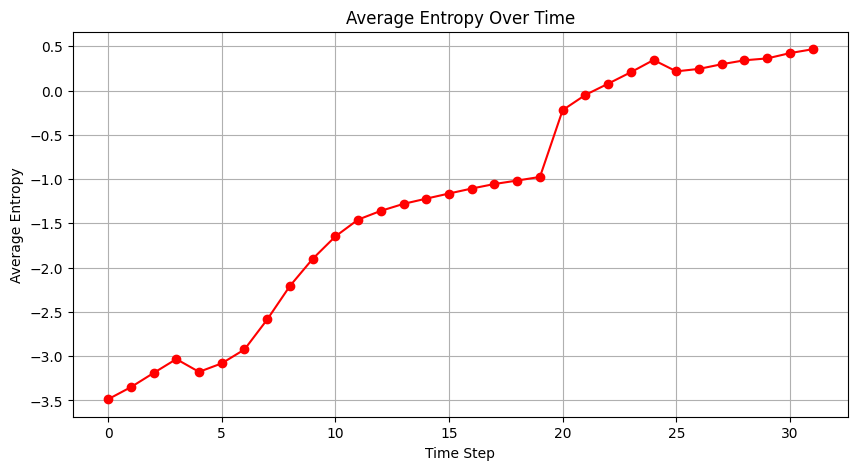

In [113]:
sim_data = pd.read_csv(r"c:\Users\harsh\OneDrive - IIT Kanpur\Desktop\Thesis\UPL\simulation_results.csv")

#plot time vs entropy
plt.figure(figsize=(10, 5))
plt.plot(sim_data['time'], sim_data['entropy'], marker='o', linestyle='-', color='red')
plt.title("Average Entropy Over Time")
plt.xlabel("Time Step")
plt.ylabel("Average Entropy")
plt.grid()
plt.show()

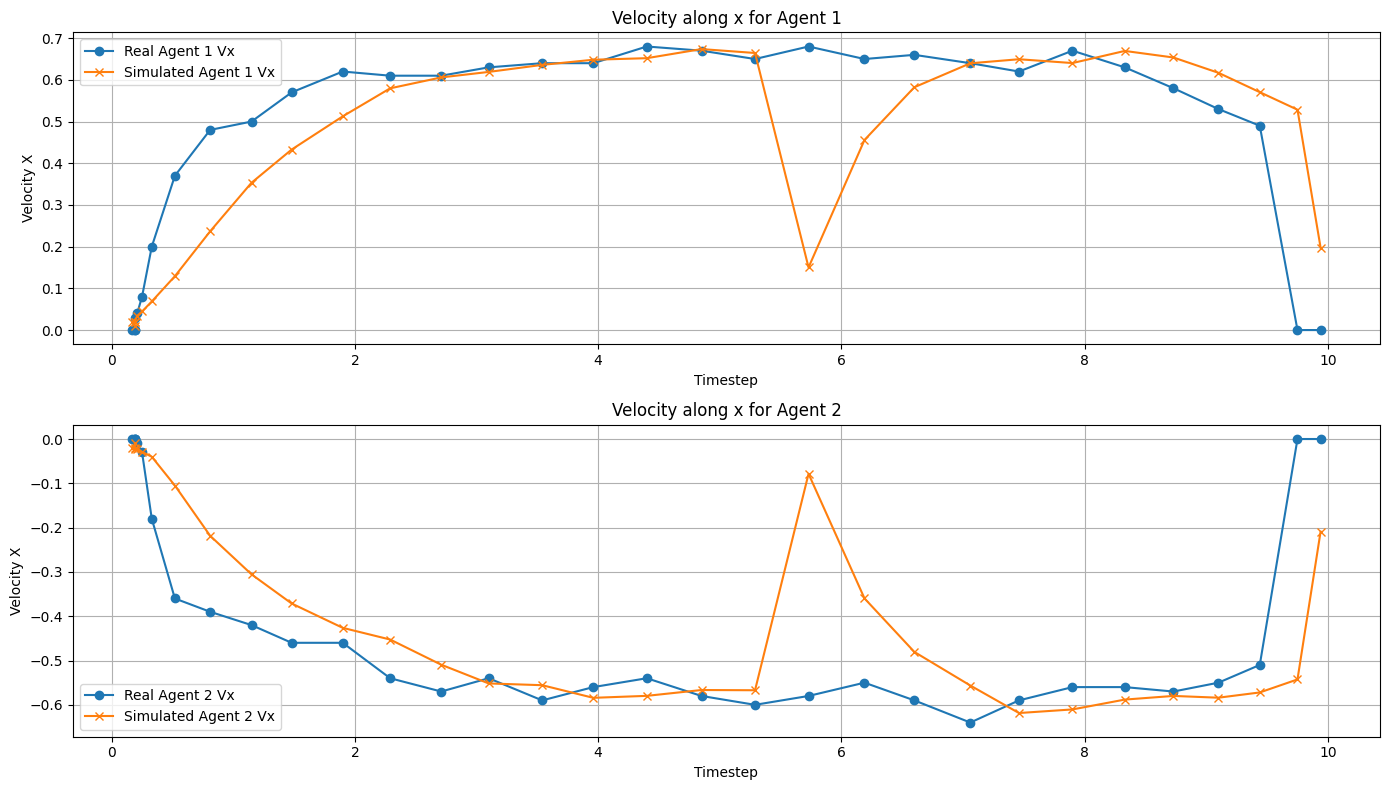

In [114]:
MAX_ITERATIONS = 32       # Maximum simulation steps

# Plotting Velocity along x for both agents
# Read the real-world data
real_data = pd.read_csv(r"F:\\Thesis\\LARGE-SCALE-CROWD-SIMULATION\\simulation_agent_positions_and_velocities_complete.csv")

# Read the simulated data
simulated_data = pd.read_csv(r"C:\Users\harsh\OneDrive - IIT Kanpur\Desktop\Thesis\UPL\simulated_positions_and_velocity_bad_new.csv")

# Extract Velocity along x for both agents
real_vx_agent1 = real_data['v_x1'].values[:MAX_ITERATIONS]
real_vx_agent2 = real_data['v_x2'].values[:MAX_ITERATIONS]
real_x1 = real_data['x_pos_1'].values[:MAX_ITERATIONS]

sim_vx_agent1 = simulated_data['agent1_vx'].values[:MAX_ITERATIONS]
sim_vx_agent2 = simulated_data['agent2_vx'].values[:MAX_ITERATIONS]

# Time frames
time_frames = np.arange(MAX_ITERATIONS)

# Plot for Agent 1
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(real_x1, real_vx_agent1, label='Real Agent 1 Vx', marker='o')
plt.plot(real_x1, sim_vx_agent1, label='Simulated Agent 1 Vx', marker='x')
plt.title('Velocity along x for Agent 1')
plt.xlabel('Timestep')
plt.ylabel('Velocity X')
plt.legend()
plt.grid(True)

# Plot for Agent 2
plt.subplot(2, 1, 2)
plt.plot(real_x1, real_vx_agent2, label='Real Agent 2 Vx', marker='o')
plt.plot(real_x1, sim_vx_agent2, label='Simulated Agent 2 Vx', marker='x')
plt.title('Velocity along x for Agent 2')
plt.xlabel('Timestep')
plt.ylabel('Velocity X')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

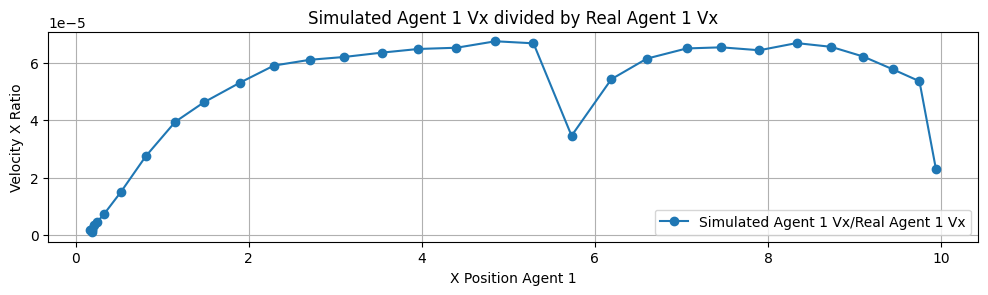

In [270]:
# plot real_vx_agent1 divided by sim_vx_agent1 versus x_pos_1
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(real_data['x_pos_1'].values[:MAX_ITERATIONS], sim_vx_agent1/(real_vx_agent1+10000), label='Simulated Agent 1 Vx/Real Agent 1 Vx', marker='o')
plt.title('Simulated Agent 1 Vx divided by Real Agent 1 Vx')
plt.xlabel('X Position Agent 1')
plt.ylabel('Velocity X Ratio')
plt.legend()
plt.grid(True)




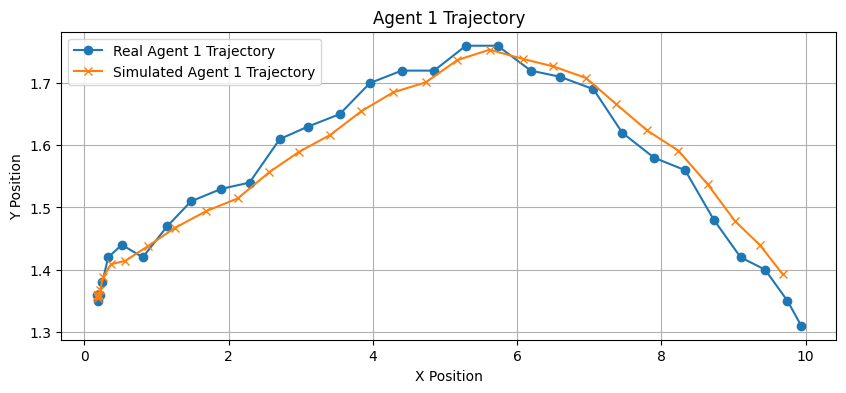

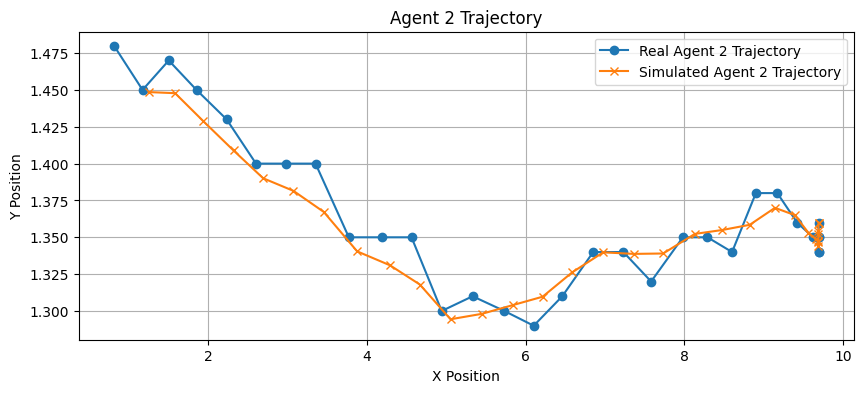

In [115]:
# plot x,y position for both agents
# Read the real-world data
real_data = pd.read_csv(r"F:\\Thesis\\LARGE-SCALE-CROWD-SIMULATION\\simulation_agent_positions_and_velocities_complete.csv")

# Read the simulated data
simulated_data = pd.read_csv(r"C:\Users\harsh\OneDrive - IIT Kanpur\Desktop\Thesis\UPL\simulated_positions_and_velocity_bad_new.csv")

# Extract x and y positions for both agents as x_pos_1, y_pos_1, x_pos_2, y_pos_2
real_x1 = real_data['x_pos_1'].values[:MAX_ITERATIONS]
real_y1 = real_data['y_pos_1'].values[:MAX_ITERATIONS]
real_x2 = real_data['x_pos_2'].values[:MAX_ITERATIONS]
real_y2 = real_data['y_pos_2'].values[:MAX_ITERATIONS]

sim_x1 = simulated_data['agent1_x'].values[:MAX_ITERATIONS]
sim_y1 = simulated_data['agent1_y'].values[:MAX_ITERATIONS]
sim_x2 = simulated_data['agent2_x'].values[:MAX_ITERATIONS]
sim_y2 = simulated_data['agent2_y'].values[:MAX_ITERATIONS]

# Time frames
time_frames = np.arange(MAX_ITERATIONS)

# Plot for Agent 1 using x,y positions from real and simulated data
plt.figure(figsize=(10, 4))
plt.plot(real_x1, real_y1, label='Real Agent 1 Trajectory', marker='o')
plt.plot(sim_x1, sim_y1, label='Simulated Agent 1 Trajectory', marker='x')
plt.title('Agent 1 Trajectory')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)

# Plot for Agent 2 using x,y positions from real and simulated data
plt.figure(figsize=(10, 4))
plt.plot(real_x2, real_y2, label='Real Agent 2 Trajectory', marker='o')
plt.plot(sim_x2, sim_y2, label='Simulated Agent 2 Trajectory', marker='x')
plt.title('Agent 2 Trajectory')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)


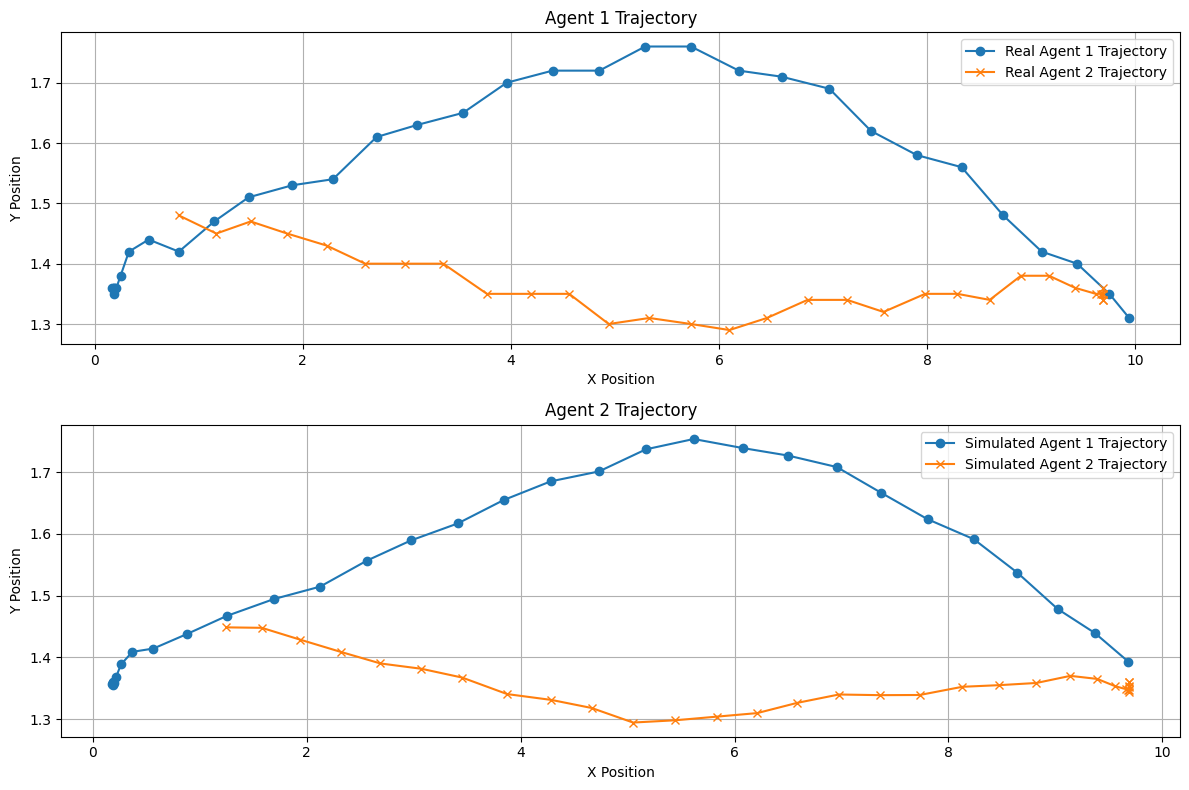

In [116]:
# Plot for Agent 1 using x,y positions from real and simulated data
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(real_x1, real_y1, label='Real Agent 1 Trajectory', marker='o')
plt.plot(real_x2, real_y2, label='Real Agent 2 Trajectory', marker='x')
plt.title('Agent 1 Trajectory')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid()

# Plot for Agent 2 using x,y positions from real and simulated data
#plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 2)
plt.plot(sim_x1, sim_y1, label='Simulated Agent 1 Trajectory', marker='o')
plt.plot(sim_x2, sim_y2, label='Simulated Agent 2 Trajectory', marker='x')
plt.title('Agent 2 Trajectory')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid()

# Display all plots in a single figure
plt.tight_layout()
plt.show()

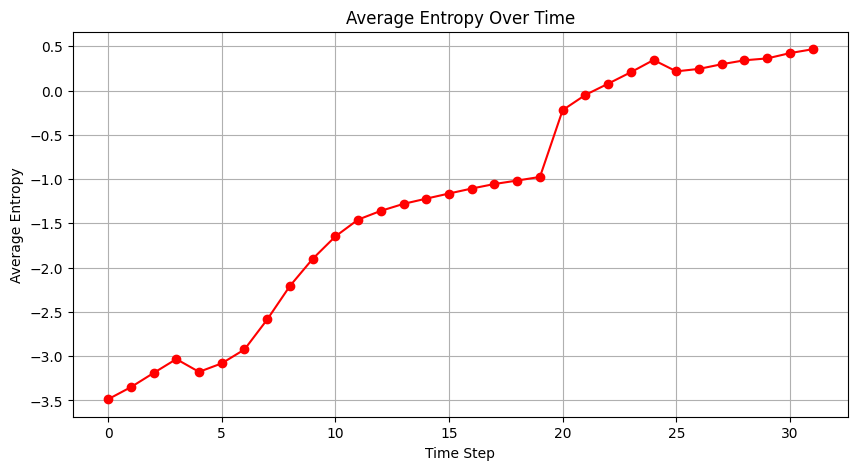

In [117]:
sim_data = pd.read_csv(r"c:\Users\harsh\OneDrive - IIT Kanpur\Desktop\Thesis\UPL\simulation_results.csv")

#plot time vs entropy
plt.figure(figsize=(10, 5))
plt.plot(sim_data['time'], sim_data['entropy'], marker='o', linestyle='-', color='red')
plt.title("Average Entropy Over Time")
plt.xlabel("Time Step")
plt.ylabel("Average Entropy")
plt.grid()
plt.show()

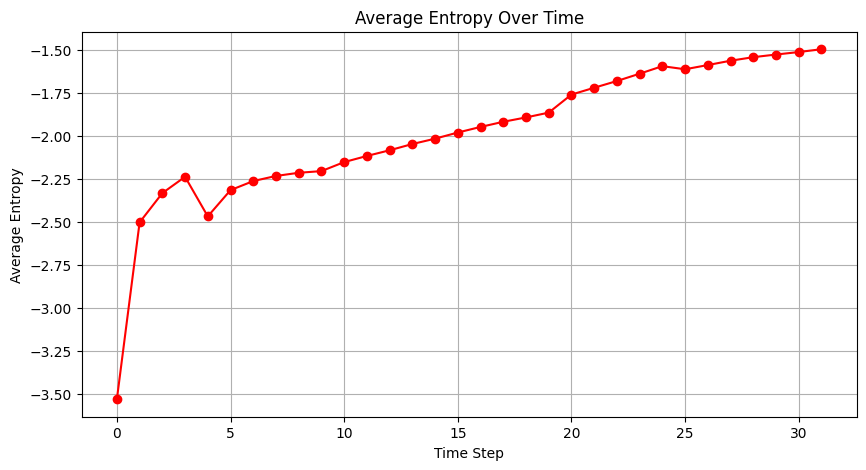

In [176]:
sim_data = pd.read_csv(r"c:\Users\harsh\OneDrive - IIT Kanpur\Desktop\Thesis\UPL\simulation_results.csv")

#plot time vs entropy
plt.figure(figsize=(10, 5))
plt.plot(sim_data['time'], sim_data['entropy'], marker='o', linestyle='-', color='red')
plt.title("Average Entropy Over Time")
plt.xlabel("Time Step")
plt.ylabel("Average Entropy")
plt.grid()
plt.show()

# RVO

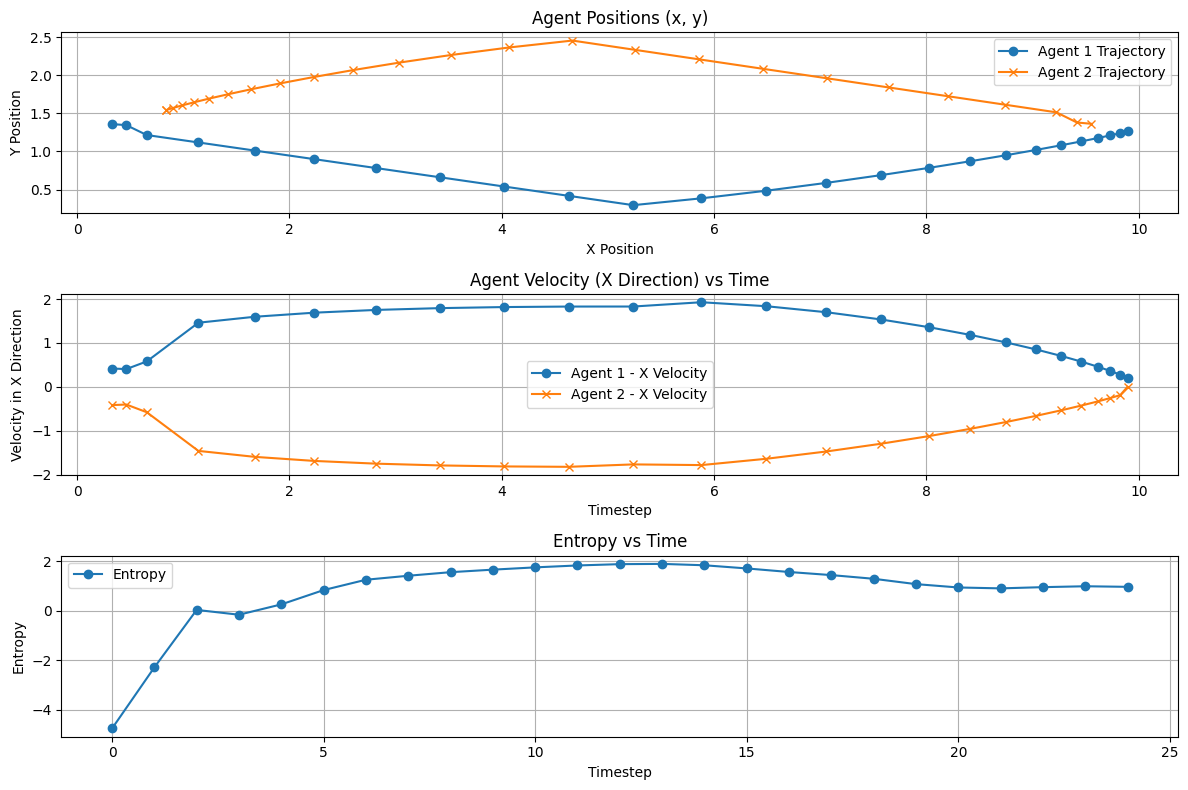

In [44]:
# Re-importing necessary libraries and re-defining the provided data after reset.
import matplotlib.pyplot as plt

# Extracted data from the given output
timesteps = list(range(25))
entropy= [
    -4.75302, -2.28162, 0.041852, -0.152904, 0.265441, 0.843549, 1.26184, 1.42326, 1.56758, 1.66988,
    1.76214, 1.83938, 1.89212, 1.9026, 1.847, 1.71928, 1.57528, 1.44963, 1.30076, 1.08467,
    0.949386, 0.912974, 0.962078, 0.998421, 0.975191
]

agent1_positions = [(0.32875, 1.35898), (0.463212, 1.34481), (0.655735, 1.21516), (1.14189, 1.11789),
                    (1.67325, 1.01142), (2.23562, 0.898644), (2.81888, 0.781617), (3.4157, 0.661831),
                    (4.02063, 0.540394), (4.6294, 0.418177), (5.23837, 0.295916), (5.87995, 0.385586),
                    (6.49129, 0.485294), (7.05704, 0.588046), (7.56827, 0.688821), (8.0209, 0.784186),
                    (8.41443, 0.871953), (8.75087, 0.950894), (9.03389, 1.0205), (9.26821, 1.0808),
                    (9.45908, 1.13216), (9.61191, 1.17522), (9.732, 1.21075), (9.82437, 1.23959),
                    (9.89365, 1.26259)]

agent2_positions = [(9.55125, 1.3627), (9.41672, 1.3797), (9.22384, 1.51273), (8.73761, 1.61332),
                    (8.20617, 1.7231), (7.64379, 1.83919), (7.06068, 1.95949), (6.46429, 2.08249),
                    (5.86028, 2.20705), (5.25322, 2.33222), (4.66455, 2.45366), (4.0707, 2.3634),
                    (3.52471, 2.26492), (3.03404, 2.16461), (2.60169, 2.06704), (2.22746, 1.97529),
                    (1.90885, 1.89127), (1.64191, 1.81602), (1.42182, 1.74992), (1.2433, 1.69286),
                    (1.10102, 1.64441), (0.9898, 1.60393), (0.90476, 1.57064), (0.841444, 1.54372),
                    (0.841444, 1.54372)]

agent1_vel_x = [(0.416667, -0.00307689), (0.40379, -0.0425524), (0.578147, -0.389338), (1.45991, -0.292095),
                     (1.59568, -0.31972), (1.6888, -0.33867), (1.75153, -0.351433), (1.79225, -0.359719),
                     (1.8166, -0.364674), (1.82814, -0.36702), (1.82876, -0.367148), (1.92665, 0.269279),
                     (1.83586, 0.299425), (1.69895, 0.308562), (1.53522, 0.302628), (1.35926, 0.286381),
                     (1.18177, 0.263564), (1.01031, 0.237061), (0.849913, 0.209035), (0.703673, 0.181064),
                     (0.573185, 0.154249), (0.45894, 0.129315), (0.360629, 0.106694), (0.2774, 0.0865953),
                     (0.208055, 0.069066)]

agent2_vel_x = [(-0.416667, 0.00810737), (-0.404, 0.0510497), (-0.579215, 0.399482), (-1.46015, 0.30207),
                     (-1.59591, 0.329693), (-1.68883, 0.348601), (-1.75109, 0.361269), (-1.79096, 0.369383),
                     (-1.81386, 0.374043), (-1.82297, 0.375897), (-1.7678, 0.36467), (-1.78332, -0.271051),
                     (-1.63961, -0.295744), (-1.47349, -0.301211), (-1.29833, -0.293001), (-1.12383, -0.275546),
                     (-0.956778, -0.252317), (-0.801607, -0.225974), (-0.660954, -0.198504), (-0.536086, -0.171342),
                     (-0.427256, -0.145483), (-0.334002, -0.121567), (-0.255377, -0.0999689), (-0.190135, -0.0808552),
                     (0, 0)]

# Plot Entropy vs Time
# plt.figure(figsize=(10, 6))
# plt.plot(timesteps, entropy, marker='o', label="Entropy")
# plt.title("Entropy vs Time")
# plt.xlabel("Timestep")
# plt.ylabel("Entropy")
# plt.legend()
# plt.grid(True)
# plt.show()

x1, y1 = zip(*agent1_positions)
x2, y2 = zip(*agent2_positions)
vx1, vy1 = zip(*agent1_vel_x)
vx2, vy2 = zip(*agent2_vel_x)

# Plot 1: Positions of both agents
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(x1, y1, label="Agent 1 Trajectory", marker='o')
plt.plot(x2, y2, label="Agent 2 Trajectory", marker='x')
plt.title("Agent Positions (x, y)")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid()

# Plot Position (x, y) for both agents
agent1_x, agent1_y = zip(*agent1_positions)
agent2_x, agent2_y = zip(*agent2_positions)

# plt.figure(figsize=(10, 6))
# plt.plot(timesteps, agent1_x, label="Agent 1 - X Position", marker='o')
# plt.plot(timesteps, agent1_y, label="Agent 1 - Y Position", marker='s')
# plt.plot(timesteps, agent2_x, label="Agent 2 - X Position", marker='^')
# plt.plot(timesteps, agent2_y, label="Agent 2 - Y Position", marker='v')
# plt.title("Agent Positions (x, y) vs Time")
# plt.xlabel("Timestep")
# plt.ylabel("Position")
# plt.legend()
# plt.grid(True)
# plt.show()

# Plot Velocity (x direction) for both agents
# plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 2)
plt.plot(x1, vx1, label="Agent 1 - X Velocity", marker='o')
plt.plot(x1, vx2, label="Agent 2 - X Velocity", marker='x')
plt.title("Agent Velocity (X Direction) vs Time")
plt.xlabel("Timestep")
plt.ylabel("Velocity in X Direction")
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(timesteps, entropy, marker='o', label="Entropy")
plt.title("Entropy vs Time")
plt.xlabel("Timestep")
plt.ylabel("Entropy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



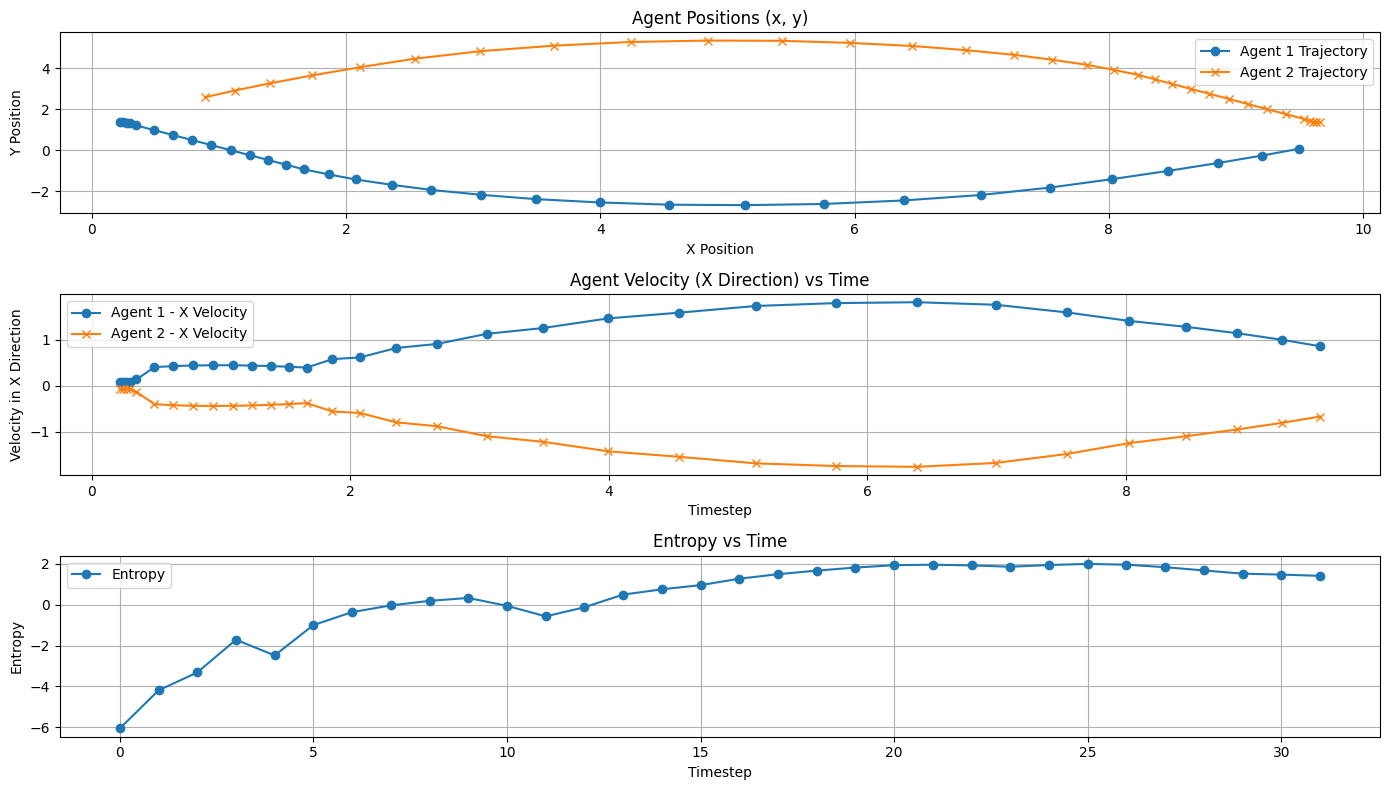

In [43]:
# Re-importing necessary libraries and re-defining the provided data after reset.
import matplotlib.pyplot as plt

# Extracted data from the given output
timesteps = list(range(32))
entropy = [
    -6.06806, -4.19951, -3.32242, -1.71811, -2.48611, -0.998781, -0.363373, -0.0332024,
    0.188638, 0.331949, -0.0550066, -0.571563, -0.125155, 0.494649, 0.754183, 0.959049,
    1.27407, 1.49663, 1.67115, 1.82187, 1.93614, 1.96135, 1.92638, 1.86191, 1.94522,
    2.00098, 1.96233, 1.83891, 1.68028, 1.52244, 1.47638, 1.41464
]

# Positions and velocities for both agents
agent1_positions = [
    (0.218667, 1.35929), (0.246265, 1.3561), (0.27306, 1.34541), (0.300996, 1.31179),
    (0.347856, 1.20658), (0.486814, 0.981207), (0.633477, 0.743245), (0.784662, 0.497894),
    (0.937699, 0.249518), (1.09035, 0.00176896), (1.24076, -0.242312), (1.38739, -0.480219),
    (1.52899, -0.709917), (1.66459, -0.929794), (1.86349, -1.17893), (2.07505, -1.42619),
    (2.35764, -1.68363), (2.67013, -1.93483), (3.0591, -2.17007), (3.49093, -2.38179),
    (3.99534, -2.5433), (4.54247, -2.65295), (5.14001, -2.67561), (5.75909, -2.61718),
    (6.38461, -2.44685), (6.99121, -2.18212), (7.54065, -1.81709), (8.02575, -1.40915),
    (8.46651, -1.00796), (8.85966, -0.623222), (9.20392, -0.262228), (9.49958, 0.069835)
]

agent2_positions = [
    (9.66133, 1.36186), (9.63373, 1.36711), (9.6069, 1.38055), (9.5789, 1.41742),
    (9.5319, 1.52615), (9.39281, 1.75504), (9.24616, 1.99627), (9.0953, 2.24439),
    (8.94305, 2.49478), (8.79176, 2.7436), (8.64342, 2.9876), (8.49964, 3.22414),
    (8.36175, 3.45107), (8.23076, 3.66671), (8.03723, 3.91066), (7.83209, 4.15149),
    (7.55681, 4.4017), (7.25288, 4.64467), (6.87348, 4.87107), (6.45268, 5.07324),
    (5.96043, 5.22485), (5.42701, 5.32429), (4.84426, 5.33672), (4.24142, 5.2682),
    (3.63278, 5.08797), (3.0532, 4.8179), (2.54059, 4.45428), (2.1102, 4.04117),
    (1.73126, 3.63896), (1.40275, 3.25777), (1.12363, 2.9039), (0.891705, 2.58161)
]

agent1_vel_x = [
    (0.0833333, -0.00205126), (0.0802284, -0.00928106), (0.0778929, -0.0310692), (0.0812076, -0.0977308),
    (0.136222, -0.30585), (0.403947, -0.655159), (0.426345, -0.691751), (0.439492, -0.71323),
    (0.444875, -0.722024), (0.443758, -0.7202), (0.437232, -0.709538), (0.426247, -0.691591),
    (0.411638, -0.667724), (0.394185, -0.639178), (0.578191, -0.724239), (0.615014, -0.71877),
    (0.821466, -0.748375), (0.908415, -0.730227), (1.13072, -0.683854), (1.25531, -0.615454),
    (1.4663, -0.469512), (1.59051, -0.318729), (1.73704, -0.065898), (1.79965, 0.169856),
    (1.81838, 0.495152), (1.76335, 0.769566), (1.59723, 1.06112), (1.41016, 1.18589),
    (1.28127, 1.16624), (1.1429, 1.11843), (1.00074, 1.0494), (0.859482, 0.9653)
]

agent2_vel_x = [
    (-0.0833333, 0.00540491), (-0.0802516, 0.0152734), (-0.0779748, 0.0390738), (-0.0814101, 0.107171),
    (-0.136622, 0.316082), (-0.404336, 0.665372), (-0.426299, 0.701254), (-0.438548, 0.721265),
    (-0.442606, 0.727895), (-0.439785, 0.723287), (-0.431229, 0.709308), (-0.417949, 0.687613),
    (-0.400852, 0.659681), (-0.380793, 0.626878), (-0.562587, 0.709159), (-0.596327, 0.700079),
    (-0.800227, 0.727362), (-0.883532, 0.706292), (-1.10288, 0.658142), (-1.22326, 0.587699),
    (-1.43098, 0.440728), (-1.55063, 0.289065), (-1.69403, 0.0361402), (-1.75246, -0.199179),
    (-1.7693, -0.523937), (-1.68483, -0.785077), (-1.49013, -1.05703), (-1.25113, -1.20089),
    (-1.10158, -1.16923), (-0.954964, -1.1081), (-0.811391, -1.0287), (-0.674204, -0.936875)
]

# Plot Entropy vs Time
# plt.figure(figsize=(10, 6))
# plt.plot(timesteps, entropy, marker='o', label="Entropy")
# plt.title("Entropy vs Time")
# plt.xlabel("Timestep")
# plt.ylabel("Entropy")
# plt.legend()
# plt.grid(True)
# plt.show()

x1, y1 = zip(*agent1_positions)
x2, y2 = zip(*agent2_positions)
vx1, vy1 = zip(*agent1_vel_x)
vx2, vy2 = zip(*agent2_vel_x)

# Plot 1: Positions of both agents
plt.figure(figsize=(14, 8))
plt.subplot(3, 1, 1)
plt.plot(x1, y1, label="Agent 1 Trajectory", marker='o')
plt.plot(x2, y2, label="Agent 2 Trajectory", marker='x')
plt.title("Agent Positions (x, y)")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid()

# Plot Position (x, y) for both agents
agent1_x, agent1_y = zip(*agent1_positions)
agent2_x, agent2_y = zip(*agent2_positions)

# plt.figure(figsize=(10, 6))
# plt.plot(timesteps, agent1_x, label="Agent 1 - X Position", marker='o')
# plt.plot(timesteps, agent1_y, label="Agent 1 - Y Position", marker='s')
# plt.plot(timesteps, agent2_x, label="Agent 2 - X Position", marker='^')
# plt.plot(timesteps, agent2_y, label="Agent 2 - Y Position", marker='v')
# plt.title("Agent Positions (x, y) vs Time")
# plt.xlabel("Timestep")
# plt.ylabel("Position")
# plt.legend()
# plt.grid(True)
# plt.show()

# Plot Velocity (x direction) for both agents
# plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 2)
plt.plot(x1, vx1, label="Agent 1 - X Velocity", marker='o')
plt.plot(x1, vx2, label="Agent 2 - X Velocity", marker='x')
plt.title("Agent Velocity (X Direction) vs Time")
plt.xlabel("Timestep")
plt.ylabel("Velocity in X Direction")
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(timesteps, entropy, marker='o', label="Entropy")
plt.title("Entropy vs Time")
plt.xlabel("Timestep")
plt.ylabel("Entropy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



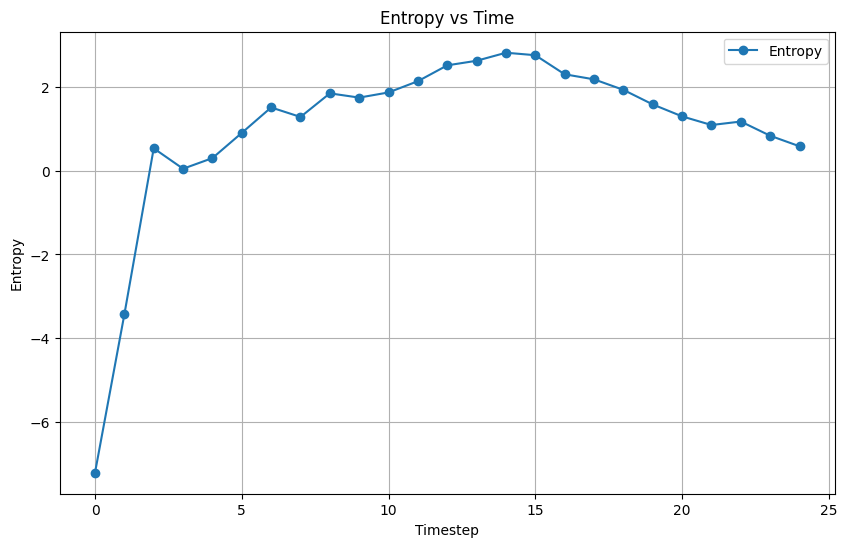

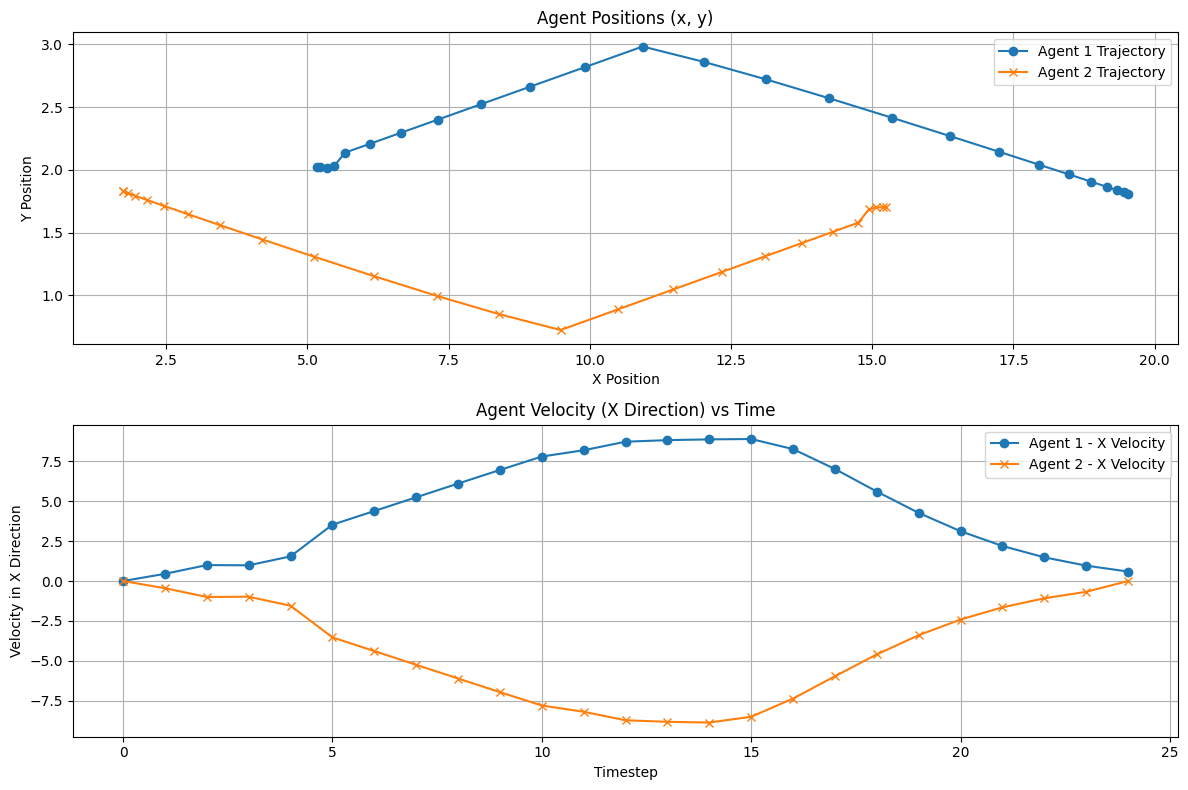

In [8]:
# Re-importing necessary libraries and re-defining the provided data after reset.
import matplotlib.pyplot as plt

# Extracted data from the given output
timesteps = list(range(25))
entropy = [-7.22406, -3.43453, 0.541247, 0.0523621, 0.307022, 0.910151, 1.51966, 1.29181, 1.85706, 1.75516, 
           1.87904, 2.14838, 2.52744, 2.63714, 2.82951, 2.76996, 2.31308, 2.19233, 1.94022, 1.59142, 
           1.30568, 1.0989, 1.18225, 0.842126, 0.589883]

agent1_positions = [(5.17, 2.02), (5.22624, 2.01914), (5.35086, 2.01768), (5.47367, 2.03037), 
                    (5.66639, 2.13732), (6.10688, 2.20776), (6.65434, 2.29547), (7.30921, 2.40053), 
                    (8.07127, 2.52291), (8.93978, 2.66247), (9.91333, 2.81901), (10.9361, 2.98349), 
                    (12.0256, 2.86029), (13.1274, 2.72051), (14.2352, 2.57118), (15.3458, 2.41618), 
                    (16.3774, 2.26937), (17.2535, 2.14315), (17.9533, 2.04144), (18.4862, 1.96343), 
                    (18.8757, 1.90603), (19.1497, 1.86541), (19.3351, 1.83773), (19.4553, 1.81965), 
                    (19.5295, 1.8084)]

agent2_positions = [(15.25, 1.7), (15.1938, 1.70058), (15.0691, 1.70135), (14.9462, 1.68748), 
                    (14.7532, 1.57906), (14.3126, 1.50718), (13.7649, 1.41802), (13.1098, 1.31149), 
                    (12.3475, 1.18766), (11.4787, 1.04664), (10.5052, 0.888679), (9.48287, 0.722852), 
                    (8.39386, 0.849703), (7.29286, 0.99509), (6.1861, 1.15137), (5.12466, 1.30698), 
                    (4.2053, 1.44475), (3.46039, 1.5581), (2.88652, 1.64649), (2.46272, 1.71245), 
                    (2.16165, 1.75978), (1.9558, 1.79247), (1.82072, 1.81417), (1.73623, 1.82792), 
                    (1.73623, 1.82792)]

agent1_vel_x = [
    (0, 0), (0.449948, -0.00686943), (0.996947, -0.0116988), (0.982473, 0.10155),
    (1.54174, 0.855595), (3.52391, 0.563486), (4.3797, 0.701708), (5.23897, 0.840493),
    (6.09651, 0.979), (6.94801, 1.11653), (7.78848, 1.25228), (8.18185, 1.31581),
    (8.71619, -0.985572), (8.81441, -1.11825), (8.8621, -1.19464), (8.88493, -1.23995),
    (8.25327, -1.17454), (7.00895, -1.0097), (5.59828, -0.813689), (4.26314, -0.624143),
    (3.11597, -0.459154), (2.19183, -0.325005), (1.48319, -0.221367), (0.962005, -0.144645),
    (0.593188, -0.0900109)
]

agent2_vel_x = [
    (0, 0), (-0.449976, 0.00463893), (-0.997118, 0.00612684), (-0.983181, -0.110937),
    (-1.5442, -0.867352), (-3.525, -0.575021), (-4.38131, -0.713328), (-5.24097, -0.852176),
    (-6.09862, -0.9907), (-6.94967, -1.12816), (-7.7886, -1.26366), (-8.17841, -1.32662),
    (-8.71206, 1.01481), (-8.808, 1.1631), (-8.85404, 1.25023), (-8.49151, 1.24488),
    (-7.35495, 1.10216), (-5.95924, 0.906806), (-4.59097, 0.707114), (-3.39035, 0.527717),
    (-2.40863, 0.378651), (-1.64679, 0.261519), (-1.08061, 0.173532), (-0.675954, 0.110017),
    (0, 0)
]

# Plot Entropy vs Time
plt.figure(figsize=(10, 6))
plt.plot(timesteps, entropy, marker='o', label="Entropy")
plt.title("Entropy vs Time")
plt.xlabel("Timestep")
plt.ylabel("Entropy")
plt.legend()
plt.grid(True)
plt.show()

x1, y1 = zip(*agent1_positions)
x2, y2 = zip(*agent2_positions)
vx1, vy1 = zip(*agent1_vel_x)
vx2, vy2 = zip(*agent2_vel_x)

# Plot 1: Positions of both agents
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(x1, y1, label="Agent 1 Trajectory", marker='o')
plt.plot(x2, y2, label="Agent 2 Trajectory", marker='x')
plt.title("Agent Positions (x, y)")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid()

# Plot Position (x, y) for both agents
agent1_x, agent1_y = zip(*agent1_positions)
agent2_x, agent2_y = zip(*agent2_positions)

# plt.figure(figsize=(10, 6))
# plt.plot(timesteps, agent1_x, label="Agent 1 - X Position", marker='o')
# plt.plot(timesteps, agent1_y, label="Agent 1 - Y Position", marker='s')
# plt.plot(timesteps, agent2_x, label="Agent 2 - X Position", marker='^')
# plt.plot(timesteps, agent2_y, label="Agent 2 - Y Position", marker='v')
# plt.title("Agent Positions (x, y) vs Time")
# plt.xlabel("Timestep")
# plt.ylabel("Position")
# plt.legend()
# plt.grid(True)
# plt.show()

# Plot Velocity (x direction) for both agents
# plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 2)
plt.plot(timesteps, vx1, label="Agent 1 - X Velocity", marker='o')
plt.plot(timesteps, vx2, label="Agent 2 - X Velocity", marker='x')
plt.title("Agent Velocity (X Direction) vs Time")
plt.xlabel("Timestep")
plt.ylabel("Velocity in X Direction")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



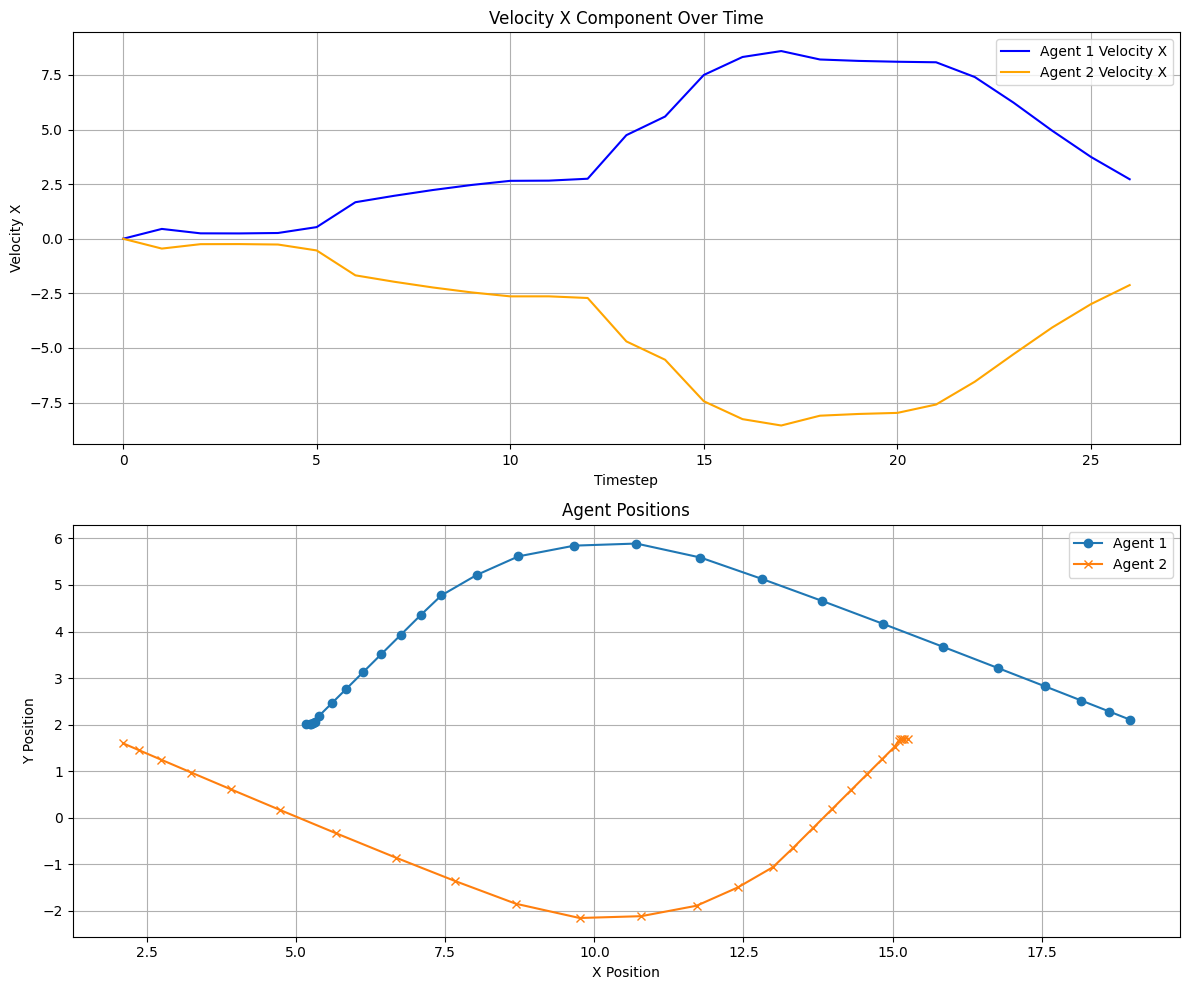

In [13]:
import matplotlib.pyplot as plt

# Extracting data for plots
time_steps = list(range(27))
entropy_values = [
    -7.17753, -3.38002, 0.605132, 0.154302, -0.0958075, 1.30677, 2.57528, 2.62092,
    3.23056, 3.4499, 3.61092, 3.38523, 3.61366, 3.85903, 3.88675, 3.773, 3.71069, 
    3.51505, 3.27122, 3.25899, 3.2388, 3.42756, 3.34553, 3.07577, 2.73561, 2.32707, 
    1.59743
]

agent1_positions = [
    (5.17, 2.02), (5.22624, 2.01914), (5.2572, 2.02169), (5.28768, 2.03142), 
    (5.32058, 2.06561), (5.38721, 2.19162), (5.59623, 2.45704), (5.84193, 2.76918), 
    (6.12075, 3.12352), (6.4284, 3.51457), (6.75977, 3.93585), (7.09231, 4.35863), 
    (7.43568, 4.77654), (8.02843, 5.21589), (8.72767, 5.61527), (9.66475, 5.84556), 
    (10.7047, 5.89011), (11.7785, 5.58985), (12.8041, 5.13284), (13.8217, 4.65607), 
    (14.8344, 4.16774), (15.844, 3.67245), (16.7692, 3.21415), (17.548, 2.82591), 
    (18.166, 2.51638), (18.634, 2.28102), (18.9745, 2.10922)
]

agent2_positions = [
    (15.25, 1.7), (15.1938, 1.70058), (15.1628, 1.69734), (15.1322, 1.68644), 
    (15.0992, 1.65059), (15.0324, 1.52255), (14.823, 1.255), (14.5771, 0.94083), 
    (14.2983, 0.584896), (13.9914, 0.193067), (13.6618, -0.227697), (13.3323, -0.648336), 
    (12.9934, -1.06239), (12.406, -1.49719), (11.7138, -1.8911), (10.7841, -2.11582), 
    (9.75202, -2.15477), (8.68357, -1.84823), (7.67122, -1.36351), (6.66881, -0.856265), 
    (5.67254, -0.335606), (4.72411, 0.169479), (3.90631, 0.609955), (3.24583, 0.968573), 
    (2.73831, 1.24592), (2.36436, 1.45142), (2.09927, 1.59789)
]

agent1_velocities = [
    (0, 0), (0.449948, -0.00686943), (0.247633, 0.0203701), (0.243837, 0.0778213), 
    (0.263216, 0.273573), (0.533014, 1.00804), (1.6722, 2.12338), (1.96561, 2.49716), 
    (2.23057, 2.83469), (2.46114, 3.12843), (2.65097, 3.37025), (2.66032, 3.38217), 
    (2.74702, 3.34329), (4.74192, 3.51482), (5.59396, 3.19509), (7.49663, 1.84232), 
    (8.31942, 0.356342), (8.59096, -2.40205), (8.20471, -3.65609), (8.14032, -3.8142), 
    (8.10153, -3.90661), (8.07741, -3.96232), (7.40107, -3.66636), (6.23028, -3.10592), 
    (4.94398, -2.47628), (3.74463, -1.88288), (2.72368, -1.37436)
]

agent2_velocities = [
    (0, 0), (-0.449976, 0.00463893), (-0.247804, -0.0259421), (-0.244254, -0.08721), 
    (-0.264121, -0.286794), (-0.534965, -1.02429), (-1.67478, -2.14042), (-1.96753, -2.51335), 
    (-2.2298, -2.84747), (-2.45522, -3.13464), (-2.63692, -3.36611), (-2.63613, -3.36511), 
    (-2.71149, -3.31241), (-4.69897, -3.47844), (-5.538, -3.15129), (-7.43751, -1.79775), 
    (-8.25639, -0.311616), (-8.54755, 2.45233), (-8.09884, 3.87775), (-8.01922, 4.058), 
    (-7.97021, 4.16527), (-7.58739, 4.04068), (-6.5424, 3.52381), (-5.28388, 2.86895), 
    (-4.06019, 2.21876), (-2.99157, 1.64405), (-2.12071, 1.17174)
]

# Unpack positions for plotting
agent1_x, agent1_y = zip(*agent1_positions)
agent2_x, agent2_y = zip(*agent2_positions)

# Unpack velocities for plotting
agent1_vx, agent1_vy = zip(*agent1_velocities)
agent2_vx, agent2_vy = zip(*agent2_velocities)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Entropy vs Time
# axs[0].plot(time_steps, entropy_values, label="Entropy", color="purple")
# axs[0].set_title("Entropy Over Time")
# axs[0].set_xlabel("Timestep")
# axs[0].set_ylabel("Entropy")
# axs[0].legend()
# axs[0].grid()

# Positions (X vs Y)
axs[1].plot(agent1_x, agent1_y, label="Agent 1", marker="o")
axs[1].plot(agent2_x, agent2_y, label="Agent 2", marker="x")
axs[1].set_title("Agent Positions")
axs[1].set_xlabel("X Position")
axs[1].set_ylabel("Y Position")
axs[1].legend()
axs[1].grid()

# Velocities (X Component vs Time)
axs[0].plot(time_steps, agent1_vx, label="Agent 1 Velocity X", color="blue")
axs[0].plot(time_steps, agent2_vx, label="Agent 2 Velocity X", color="orange")
axs[0].set_title("Velocity X Component Over Time")
axs[0].set_xlabel("Timestep")
axs[0].set_ylabel("Velocity X")
axs[0].legend()
axs[0].grid()

plt.tight_layout()
plt.show()


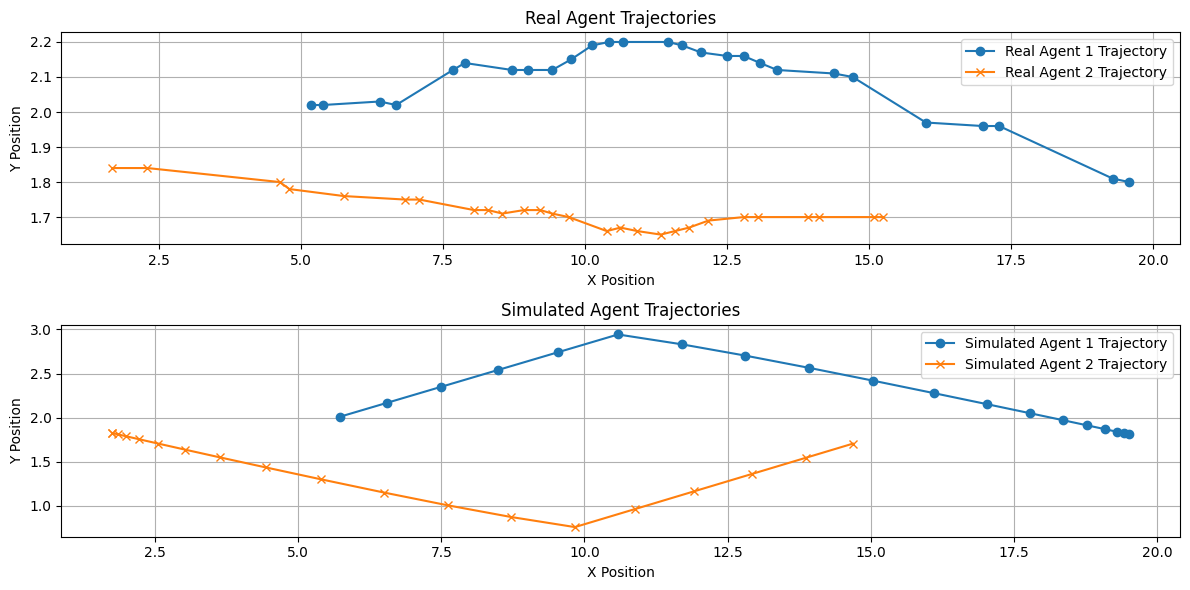

In [134]:
# Load the real-world data
real_data = pd.read_csv(r"C:\Users\harsh\OneDrive - IIT Kanpur\Desktop\Thesis\Real world data\agent_positions_and_velocities_complete.csv")

# Load the simulated data
simulated_data = pd.read_csv(r"c:\Users\harsh\OneDrive - IIT Kanpur\Desktop\Thesis\simulated_positions_and_velocitiy_new.csv")

# Define MAX_ITERATIONS to match the data size
MAX_ITERATIONS = len(real_data)  # Ensure this matches the number of rows in your data

# Extract x and y positions for both agents
real_x1 = real_data['x_pos_1'].values[:MAX_ITERATIONS]
real_y1 = real_data['y_pos_1'].values[:MAX_ITERATIONS]
real_x2 = real_data['x_pos_2'].values[:MAX_ITERATIONS]
real_y2 = real_data['y_pos_2'].values[:MAX_ITERATIONS]

sim_x1 = simulated_data['x_pos_1'].values[:MAX_ITERATIONS]
sim_y1 = simulated_data['y_pos_1'].values[:MAX_ITERATIONS]
sim_x2 = simulated_data['x_pos_2'].values[:MAX_ITERATIONS]
sim_y2 = simulated_data['y_pos_2'].values[:MAX_ITERATIONS]

# Time frames
time_frames = np.arange(MAX_ITERATIONS)

# Create a figure for plotting
plt.figure(figsize=(12, 6))

# Plot Real Agent 1 and Agent 2 Trajectories
plt.subplot(2, 1, 1)
plt.plot(real_x1, real_y1, label='Real Agent 1 Trajectory', marker='o')
plt.plot(real_x2, real_y2, label='Real Agent 2 Trajectory', marker='x')
plt.title('Real Agent Trajectories')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid()

# Plot Simulated Agent 1 and Agent 2 Trajectories
plt.subplot(2, 1, 2)
plt.plot(sim_x1, sim_y1, label='Simulated Agent 1 Trajectory', marker='o')
plt.plot(sim_x2, sim_y2, label='Simulated Agent 2 Trajectory', marker='x')
plt.title('Simulated Agent Trajectories')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid()

# Display all plots in a single figure
plt.tight_layout()
plt.show()


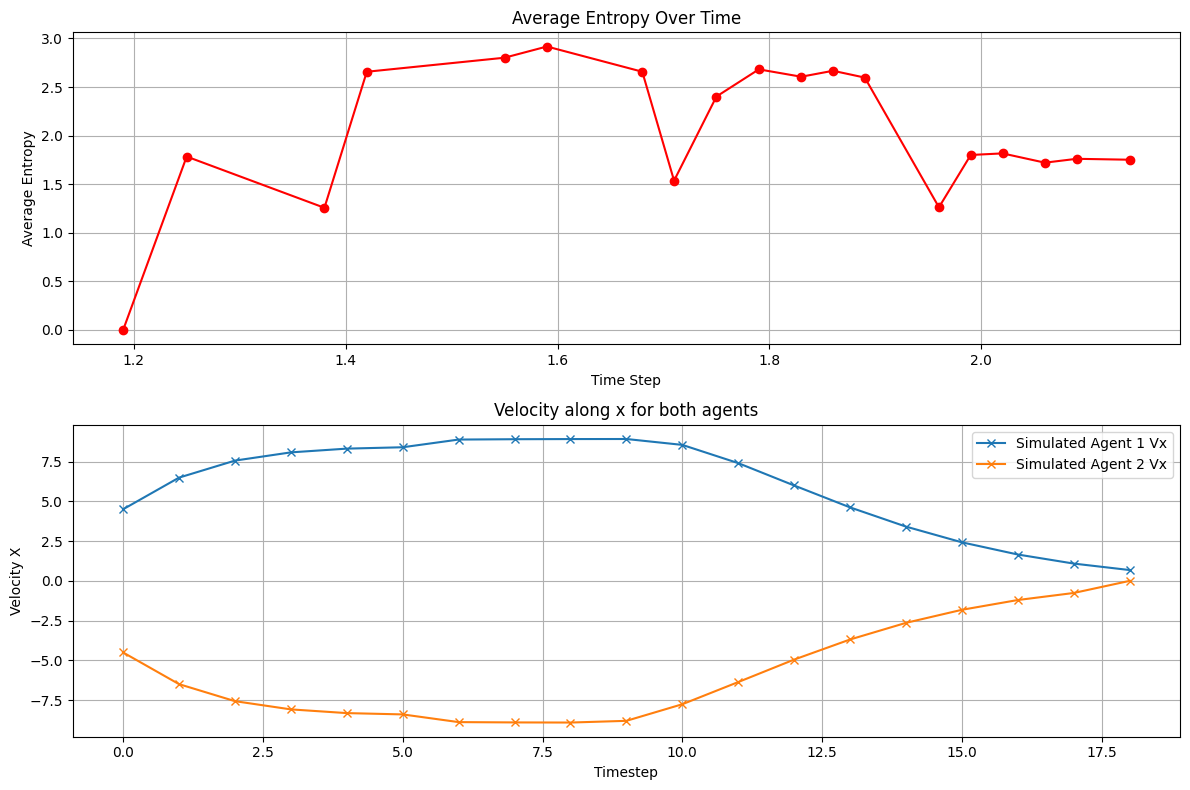

In [107]:
# Load data from the CSV file
sim_data = pd.read_csv(r"c:\Users\harsh\OneDrive - IIT Kanpur\Desktop\Thesis\simulated_positions_and_velocitiy_new.csv")

MAX_ITERATIONS = len(sim_data)  # Adjust this to the length of your data

# Time frames for plotting
time_frames = np.arange(MAX_ITERATIONS)

# Extract velocities along x for both agents
sim_vx1 = sim_data['v_x1'].values[:MAX_ITERATIONS]
sim_vx2 = sim_data['v_x2'].values[:MAX_ITERATIONS]

# Create subplots for the entropy and velocity plots
plt.figure(figsize=(12, 8))

# Plot 1: Time vs entropy
plt.subplot(2, 1, 1)
plt.plot(sim_data['time'], sim_data['entropy'], marker='o', linestyle='-', color='red')
plt.title("Average Entropy Over Time")
plt.xlabel("Time Step")
plt.ylabel("Average Entropy")
plt.grid()

# Plot 2: Velocity along x for both agents
plt.subplot(2, 1, 2)
plt.plot(time_frames[:19], sim_vx1[:19], label='Simulated Agent 1 Vx', marker='x')
plt.plot(time_frames[:19], sim_vx2[:19], label='Simulated Agent 2 Vx', marker='x')
plt.title('Velocity along x for both agents')
plt.xlabel('Timestep')
plt.ylabel('Velocity X')
plt.legend()
plt.grid()

# Display the plots
plt.tight_layout()
plt.show()


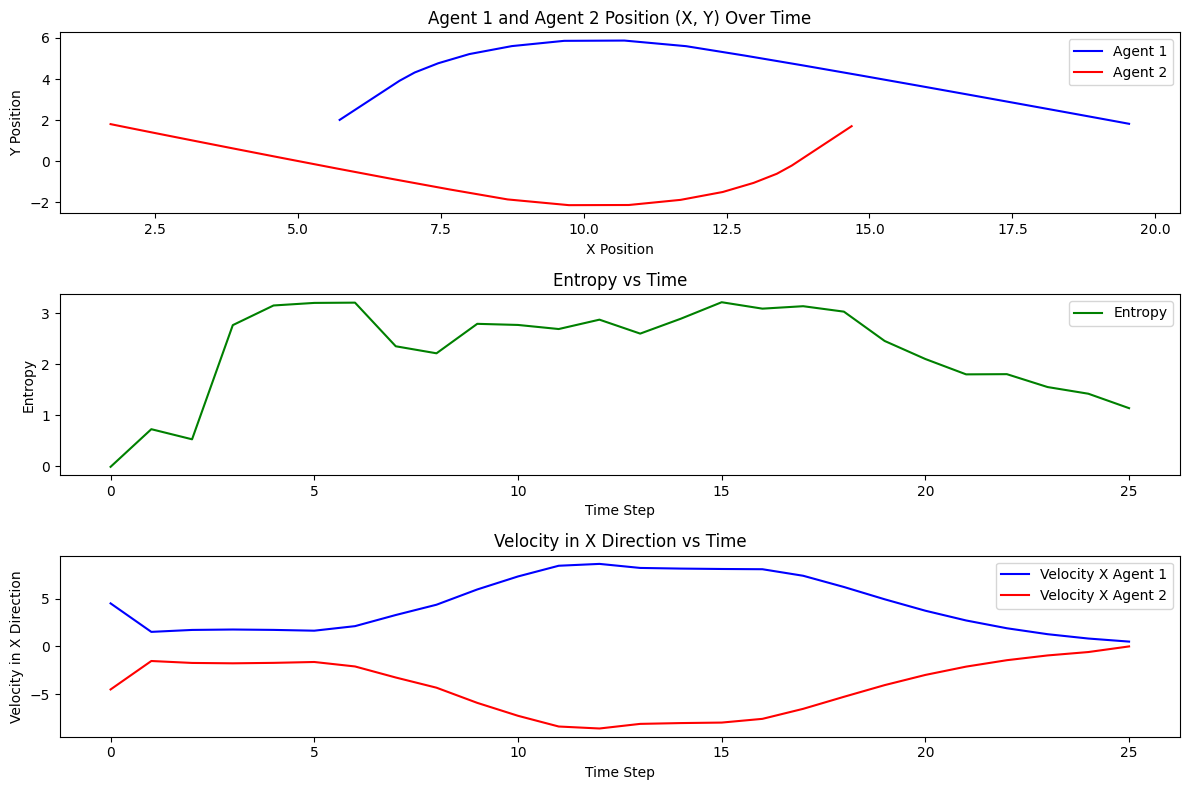

In [175]:
import matplotlib.pyplot as plt
import numpy as np

# Data for agent positions, velocities, and entropy values
timesteps = np.arange(26)
agent1_positions = [(5.73243, 2.01141), (5.92244, 2.35675), (6.13788, 2.74851), (6.3588, 3.15027), (6.57471, 3.54288), 
                    (6.78023, 3.91653), (7.04517, 4.3186), (7.45563, 4.76703), (8.00061, 5.21456), (8.74495, 5.60328), 
                    (9.65929, 5.85921), (10.7136, 5.87257), (11.7921, 5.59963), (12.8177, 5.14202), (13.8348, 4.66399), 
                    (14.8468, 4.17403), (15.8556, 3.67685), (16.779, 3.21712), (17.5558, 2.82783), (18.1719, 2.51755), 
                    (18.6384, 2.28169), (18.9776, 2.10957), (19.2149, 1.98868), (19.3747, 1.90701), (19.4776, 1.85414), 
                    (19.5406, 1.82161)]
agent2_positions = [(14.6875, 1.7058), (14.4969, 1.35659), (14.281, 0.961224), (14.0602, 0.556961), (13.8452, 0.163423), 
                    (13.6417, -0.209342), (13.3798, -0.608914), (12.9735, -1.05364), (12.434, -1.49636), (11.6963, -1.87966), 
                    (10.7897, -2.12989), (9.74286, -2.13754), (8.67021, -1.85847), (7.65787, -1.37304), (6.65605, -0.864359), 
                    (5.66068, -0.341836), (4.71405, 0.164882), (3.89828, 0.606691), (3.23971, 0.966344), (2.73383, 1.24446), 
                    (2.36121, 1.45051), (2.09714, 1.59736), (1.91705, 1.69808), (1.79922, 1.7644), (1.72576, 1.80607), 
                    (1.72576, 1.80607)]

# Extract x, y positions for both agents
agent1_x = [pos[0] for pos in agent1_positions]
agent1_y = [pos[1] for pos in agent1_positions]
agent2_x = [pos[0] for pos in agent2_positions]
agent2_y = [pos[1] for pos in agent2_positions]

# Data for entropy and velocities in x-direction
entropy = [-0.013607, 0.724466, 0.526224, 2.76548, 3.15097, 3.20136, 3.20645, 2.35077, 2.21293, 2.79097, 2.76906, 
           2.68892, 2.87284, 2.59918, 2.89225, 3.21463, 3.08871, 3.13671, 3.03, 2.45513, 2.10079, 1.79985, 1.80389, 
           1.55104, 1.42021, 1.13671]
velocity_x_agent1 = [4.49948, 1.52001, 1.72355, 1.76735, 1.72726, 1.64416, 2.11958, 3.28367, 4.35982, 5.95469, 7.31473, 
                     8.43434, 8.62778, 8.20529, 8.13686, 8.09576, 8.07028, 7.38712, 6.21449, 4.92904, 3.7318, 2.71336, 
                     1.89888, 1.27802, 0.823809, 0.504026]
velocity_x_agent2 = [-4.49976, -1.52503, -1.72742, -1.76642, -1.71939, -1.62831, -2.09529, -3.25057, -4.31595, -5.90136, 
                     -7.25325, -8.37438, -8.58116, -8.09874, -8.01458, -7.96292, -7.57307, -6.52618, -5.26854, -4.04701, 
                     -2.98095, -2.11257, -1.44071, -0.942705, -0.587646, 0]

# Plot agent positions (x, y)
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(agent1_x, agent1_y, label="Agent 1", color="blue")
plt.plot(agent2_x, agent2_y, label="Agent 2", color="red")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Agent 1 and Agent 2 Position (X, Y) Over Time")
plt.legend()

# Plot entropy vs time
plt.subplot(3, 1, 2)
plt.plot(timesteps, entropy, label="Entropy", color="green")
plt.xlabel("Time Step")
plt.ylabel("Entropy")
plt.title("Entropy vs Time")
plt.legend()

# Plot velocity in x-direction vs time
plt.subplot(3, 1, 3)
plt.plot(timesteps, velocity_x_agent1, label="Velocity X Agent 1", color="blue")
plt.plot(timesteps, velocity_x_agent2, label="Velocity X Agent 2", color="red")
plt.xlabel("Time Step")
plt.ylabel("Velocity in X Direction")
plt.title("Velocity in X Direction vs Time")
plt.legend()

plt.tight_layout()
plt.show()


## C++ UPL

In [ ]:
#include <iostream>
#include <fstream>
#include <sstream>
#include <vector>
#include <cmath>
#include <random>
#include <limits>
#include <deque>

#ifndef M_PI
#define M_PI 3.14159265358979323846
#endif

#ifndef M_E
#define M_E 2.71828182845904523536
#endif

// Constants
const int num_agents = 2;            // Number of agents
const int ensemble_size = 2000;      // Ensemble size
const int state_size = 4;            // State dimensions: [x, y, vx, vy]
const int max_iterations = 27;       // Maximum simulation steps
const double noise_std = 0.1;        // Standard deviation for Gaussian noise

// Interaction Parameters
const double k = 1.0;                // Scaling constant for interaction energy
const double tau_0 = 3.0;            // Intrinsic interaction range (seconds)
const double alpha = 1.0;            // Scaling factor for repulsive force
const double k_goal = 1.0;           // Scaling factor for goal-directed force
const double delta_t = 0.00125;      // Time step (1.25 ms)
const double mass = 1.0;             // Mass of agents

// Define the state structure for each agent
struct AgentState {
    double x_pos;
    double y_pos;
    double v_x;
    double v_y;
};

// Define a structure to hold target positions
struct TargetPosition {
    double x;
    double y;
};

// Global variables for EnKS
std::deque<std::vector<std::vector<AgentState>>> ensemble_history;
const size_t ENKS_WINDOW_SIZE = 5;

// Function to read CSV and load data into agent1_data and agent2_data vectors
void load_csv(const std::string& file_path, std::vector<AgentState>& agent1_data, std::vector<AgentState>& agent2_data) {
    std::ifstream file(file_path);
    std::string line;

    if (!file.is_open()) {
        std::cerr << "Error: Could not open file " << file_path << std::endl;
        return;
    }

    // Skip the header
    std::getline(file, line);

    // Read each line of the CSV file
    while (std::getline(file, line)) {
        std::stringstream ss(line);
        std::string value;
        AgentState agent1_state;
        AgentState agent2_state;

        // Read the time value (ignore if not needed)
        std::getline(ss, value, ',');  // Skip the 'time' column

        // Read data for agent 1
        std::getline(ss, value, ','); agent1_state.x_pos = std::stod(value);  // x_pos_1
        std::getline(ss, value, ','); agent1_state.y_pos = std::stod(value);  // y_pos_1
        std::getline(ss, value, ','); agent1_state.v_x = std::stod(value);    // v_x1
        std::getline(ss, value, ','); agent1_state.v_y = std::stod(value);    // v_y1

        // Read data for agent 2
        std::getline(ss, value, ','); agent2_state.x_pos = std::stod(value);  // x_pos_2
        std::getline(ss, value, ','); agent2_state.y_pos = std::stod(value);  // y_pos_2
        std::getline(ss, value, ','); agent2_state.v_x = std::stod(value);    // v_x2
        std::getline(ss, value);       agent2_state.v_y = std::stod(value);   // v_y2

        // Store the state for both agents
        agent1_data.push_back(agent1_state);
        agent2_data.push_back(agent2_state);
    }

    file.close();
}

// Function to calculate entropy based on the diagonal covariance vector Q_diag
double calculate_entropy(const std::vector<double>& Q_diag) {
    size_t state_sz = Q_diag.size();
    double det_Q = 1.0;

    // Compute determinant (product of diagonal elements)
    for (size_t i = 0; i < state_sz; ++i) {
        double diag_element = Q_diag[i];
        if (std::isnan(diag_element) || diag_element <= 0.0) {
            // Assign a small positive value to avoid log of zero or negative
            diag_element = 1e-6;
        }
        det_Q *= diag_element;
    }

    // Ensure determinant is positive
    if (det_Q <= 0.0 || std::isnan(det_Q)) {
        det_Q = 1e-24;
    }

    // Calculate entropy using the formula:
    // e(Q_tilda) = 1/2 * (log((2πe)^d * det(Q_tilda)))
    double entropy = 0.5 * (std::log(std::pow(2.0 * M_PI * M_E, state_sz)) + std::log(det_Q));

    // Check for NaN entropy
    if (std::isnan(entropy)) {
        entropy = 0.0;
    }

    return entropy;
}

// Function to calculate time-to-collision (tau)
double calculate_tau(const AgentState& agent_i, const AgentState& agent_j) {
    double r_ij_x = agent_j.x_pos - agent_i.x_pos;
    double r_ij_y = agent_j.y_pos - agent_i.y_pos;
    double v_ij_x = agent_i.v_x - agent_j.v_x;
    double v_ij_y = agent_i.v_y - agent_j.v_y;

    double dot_product = r_ij_x * v_ij_x + r_ij_y * v_ij_y;
    double v_ij_mag_sq = v_ij_x * v_ij_x + v_ij_y * v_ij_y;

    if (v_ij_mag_sq == 0.0) {
        return std::numeric_limits<double>::infinity();
    }

    double tau = dot_product / v_ij_mag_sq;
    return (tau > 0) ? tau : std::numeric_limits<double>::infinity();
}

// Function to compute interaction force F_ij
std::pair<double, double> compute_interaction_force(const AgentState& agent_i, const AgentState& agent_j) {
    double tau = calculate_tau(agent_i, agent_j);
    if (tau == std::numeric_limits<double>::infinity()) {
        return { 0.0, 0.0 };
    }

    double r_ij_x = agent_j.x_pos - agent_i.x_pos;
    double r_ij_y = agent_j.y_pos - agent_i.y_pos;
    double distance = std::sqrt(r_ij_x * r_ij_x + r_ij_y * r_ij_y);

    if (distance == 0.0) {
        return { 0.0, 0.0 };
    }

    double force_magnitude = alpha * (r_ij_x / (tau * tau * tau)) * std::exp(-tau / tau_0);
    double force_x = force_magnitude;
    double force_y = alpha * (r_ij_y / (tau * tau * tau)) * std::exp(-tau / tau_0);

    return { force_x, force_y };
}

// Function to compute goal-directed force F_goal
std::pair<double, double> compute_goal_force(const AgentState& agent, const TargetPosition& target) {
    double direction_x = target.x - agent.x_pos;
    double direction_y = target.y - agent.y_pos;
    double distance = std::sqrt(direction_x * direction_x + direction_y * direction_y);

    if (distance < 1e-5) {
        return { 0.0, 0.0 };
    }

    double force_x = k_goal * (direction_x / distance);
    double force_y = k_goal * (direction_y / distance);

    return { force_x, force_y };
}

// Function to perform Ensemble Kalman Smoother (EnKS)
void ensemble_kalman_smoother(
    std::deque<std::vector<std::vector<AgentState>>>& history,
    std::vector<std::vector<AgentState>>& smoothed_ensemble
) {
    // Initialize smoothed ensemble with the last ensemble state
    smoothed_ensemble = history.back();

    // Iterate backwards through the history for smoothing
    for (auto it = history.rbegin() + 1; it != history.rend(); ++it) {
        const std::vector<std::vector<AgentState>>& current_ensemble = *it;
        // Simple smoothing: average with the next smoothed ensemble
        for (size_t n = 0; n < ensemble_size; ++n) {
            for (size_t agent_id = 0; agent_id < num_agents; ++agent_id) {
                smoothed_ensemble[n][agent_id].x_pos = 0.5 * (current_ensemble[n][agent_id].x_pos + smoothed_ensemble[n][agent_id].x_pos);
                smoothed_ensemble[n][agent_id].y_pos = 0.5 * (current_ensemble[n][agent_id].y_pos + smoothed_ensemble[n][agent_id].y_pos);
                smoothed_ensemble[n][agent_id].v_x = 0.5 * (current_ensemble[n][agent_id].v_x + smoothed_ensemble[n][agent_id].v_x);
                smoothed_ensemble[n][agent_id].v_y = 0.5 * (current_ensemble[n][agent_id].v_y + smoothed_ensemble[n][agent_id].v_y);
            }
        }
    }
}

// Kalman Gain calculation and Correction Step
void kalman_gain_and_correction(
    const AgentState& agent1_measurement,
    const AgentState& agent2_measurement,
    std::vector<std::vector<AgentState>>& ensemble,
    std::vector<std::vector<double>>& P1,      // State covariance matrix for Agent 1
    std::vector<double>& Q_cov1,               // Process noise covariance vector for Agent 1
    std::vector<std::vector<double>>& P2,      // State covariance matrix for Agent 2
    std::vector<double>& Q_cov2,               // Process noise covariance vector for Agent 2
    const std::vector<std::vector<double>>& R_cov  // Measurement noise covariance matrix
) {
    size_t state_sz = 4;  // [x_pos, y_pos, v_x, v_y]

    // Predict Step for Agent 1: P1 = P1 + Q_cov1 (only diagonal elements)
    for (size_t i = 0; i < state_sz; ++i) {
        P1[i][i] += Q_cov1[i];
    }

    // Predict Step for Agent 2: P2 = P2 + Q_cov2 (only diagonal elements)
    for (size_t i = 0; i < state_sz; ++i) {
        P2[i][i] += Q_cov2[i];
    }

    // Calculate Kalman Gain for Agent 1: K1 = P1 / (P1 + R_cov)
    std::vector<double> K1(state_sz);
    for (size_t i = 0; i < state_sz; ++i) {
        K1[i] = P1[i][i] / (P1[i][i] + R_cov[i][i]);
    }

    // Calculate Kalman Gain for Agent 2: K2 = P2 / (P2 + R_cov)
    std::vector<double> K2(state_sz);
    for (size_t i = 0; i < state_sz; ++i) {
        K2[i] = P2[i][i] / (P2[i][i] + R_cov[i][i]);
    }

    // Update ensemble members
    for (size_t n = 0; n < ensemble_size; ++n) {
        // Agent 1 correction
        ensemble[n][0].x_pos += K1[0] * (agent1_measurement.x_pos - ensemble[n][0].x_pos);
        ensemble[n][0].y_pos += K1[1] * (agent1_measurement.y_pos - ensemble[n][0].y_pos);
        ensemble[n][0].v_x += K1[2] * (agent1_measurement.v_x - ensemble[n][0].v_x);
        ensemble[n][0].v_y += K1[3] * (agent1_measurement.v_y - ensemble[n][0].v_y);

        // Agent 2 correction
        ensemble[n][1].x_pos += K2[0] * (agent2_measurement.x_pos - ensemble[n][1].x_pos);
        ensemble[n][1].y_pos += K2[1] * (agent2_measurement.y_pos - ensemble[n][1].y_pos);
        ensemble[n][1].v_x += K2[2] * (agent2_measurement.v_x - ensemble[n][1].v_x);
        ensemble[n][1].v_y += K2[3] * (agent2_measurement.v_y - ensemble[n][1].v_y);
    }

    // Update State Covariance P1: P1 = (I - K1) * P1 + Regularization
    for (size_t i = 0; i < state_sz; ++i) {
        P1[i][i] = (1.0 - K1[i]) * P1[i][i] + 1e-6;  // Regularization added
    }

    // Update State Covariance P2: P2 = (I - K2) * P2 + Regularization
    for (size_t i = 0; i < state_sz; ++i) {
        P2[i][i] = (1.0 - K2[i]) * P2[i][i] + 1e-6;  // Regularization added
    }

    // Store the updated ensemble for smoothing
    ensemble_history.push_back(ensemble);

    // Ensure the history size does not exceed the window size
    if (ensemble_history.size() > ENKS_WINDOW_SIZE) {
        ensemble_history.pop_front();
    }
}

// Function to perform Maximum Likelihood Estimation (MLE) for updating Q_cov and apply smoothing
void mle_per_agent(
    const AgentState& agent1_measurement,
    const AgentState& agent2_measurement,
    const std::vector<std::vector<AgentState>>& ensemble,
    std::vector<double>& Q_cov1, // Changed to vector<double>
    std::vector<double>& Q_cov2, // Changed to vector<double>
    size_t timestep  // Pass the current timestep
) {
    size_t w = 2;  // Window size on each side (total window size = 2w +1 =5)
    size_t window_size = w;
    size_t total_window = 2 * w + 1;

    size_t state_sz = 4;  // [x_pos, y_pos, v_x, v_y]

    // Initialize covariance sums for Agent 1 and Agent 2
    std::vector<double> sum_Q1(state_sz, 0.0);
    std::vector<double> sum_Q2(state_sz, 0.0);

    // Compute sum of squared differences
    for (size_t n = 0; n < ensemble_size; ++n) {
        // Differences for Agent 1
        double diff1_x = agent1_measurement.x_pos - ensemble[n][0].x_pos;
        double diff1_y = agent1_measurement.y_pos - ensemble[n][0].y_pos;
        double diff1_vx = agent1_measurement.v_x - ensemble[n][0].v_x;
        double diff1_vy = agent1_measurement.v_y - ensemble[n][0].v_y;

        // Differences for Agent 2
        double diff2_x = agent2_measurement.x_pos - ensemble[n][1].x_pos;
        double diff2_y = agent2_measurement.y_pos - ensemble[n][1].y_pos;
        double diff2_vx = agent2_measurement.v_x - ensemble[n][1].v_x;
        double diff2_vy = agent2_measurement.v_y - ensemble[n][1].v_y;

        // Sum squared differences for Agent 1
        sum_Q1[0] += diff1_x * diff1_x;
        sum_Q1[1] += diff1_y * diff1_y;
        sum_Q1[2] += diff1_vx * diff1_vx;
        sum_Q1[3] += diff1_vy * diff1_vy;

        // Sum squared differences for Agent 2
        sum_Q2[0] += diff2_x * diff2_x;
        sum_Q2[1] += diff2_y * diff2_y;
        sum_Q2[2] += diff2_vx * diff2_vx;
        sum_Q2[3] += diff2_vy * diff2_vy;
    }

    // Update Q_cov1 with averaged values and regularization
    for (size_t i = 0; i < state_sz; ++i) {
        Q_cov1[i] = (sum_Q1[i] / ensemble_size) + 1e-6;

        // Ensure Q_cov1[i] is positive
        if (Q_cov1[i] < 1e-6 || std::isnan(Q_cov1[i])) {
            Q_cov1[i] = 1e-6;
        }

        // Update Q_cov2 with averaged values and regularization
        Q_cov2[i] = (sum_Q2[i] / ensemble_size) + 1e-6;

        // Ensure Q_cov2[i] is positive
        if (Q_cov2[i] < 1e-6 || std::isnan(Q_cov2[i])) {
            Q_cov2[i] = 1e-6;
        }
    }

    // Add the updated Q_cov to history for both agents
    std::vector<double> Q_cov1_copy = Q_cov1;
    std::vector<double> Q_cov2_copy = Q_cov2;
    std::vector<std::vector<double>> Q_cov_pair = { Q_cov1_copy, Q_cov2_copy };
}

// Function to update agent positions based on forces
void update_agents(std::vector<AgentState>& agents, const std::vector<std::pair<double, double>>& total_forces) {
    for (size_t i = 0; i < agents.size(); ++i) {
        double a_x = total_forces[i].first / mass;
        double a_y = total_forces[i].second / mass;

        agents[i].v_x += a_x * delta_t;
        agents[i].v_y += a_y * delta_t;

        agents[i].x_pos += agents[i].v_x * delta_t;
        agents[i].y_pos += agents[i].v_y * delta_t;
    }
}

int main() {
    // Data vectors for real-world positions and velocities for agent 1 and agent 2
    std::vector<AgentState> agent1_data;
    std::vector<AgentState> agent2_data;

    // Load the real-world data from the CSV file for both agents
    load_csv("C:\\Users\\harsh\\OneDrive - IIT Kanpur\\Desktop\\Thesis\\Real world data\\agent_positions_and_velocities_complete.csv", agent1_data, agent2_data);

    // Check if data was loaded
    if (agent1_data.empty() || agent2_data.empty()) {
        std::cerr << "Error: Agent data is empty. Please check the CSV file." << std::endl;
        return -1;
    }

    // Initialize ensemble states for both agents
    std::vector<std::vector<AgentState>> ensemble(ensemble_size, std::vector<AgentState>(num_agents));

    // Initialize covariance matrices: Q_cov1, P1 for Agent 1; Q_cov2, P2 for Agent 2
    std::vector<std::vector<double>> P1(state_size, std::vector<double>(state_size, 0.0));
    std::vector<double> Q_cov1(state_size, 0.0);
    std::vector<std::vector<double>> P2(state_size, std::vector<double>(state_size, 0.0));
    std::vector<double> Q_cov2(state_size, 0.0);
    std::vector<std::vector<double>> R_cov(state_size, std::vector<double>(state_size, 0.0));

    // Set diagonal elements appropriately for Agent 1 and Agent 2
    for (size_t i = 0; i < state_size; ++i) {
        P1[i][i] = 0.1;
        Q_cov1[i] = 0.05; // Increased for responsiveness
        P2[i][i] = 0.1;
        Q_cov2[i] = 0.05; // Increased for responsiveness
        R_cov[i][i] = 0.05; // Reduced for higher measurement trust
    }

    // Define target positions for each agent
    std::vector<TargetPosition> targets(num_agents);
    targets[0].x = agent1_data.back().x_pos; // Agent 0's target X
    targets[0].y = agent1_data.back().y_pos; // Agent 0's target Y
    targets[1].x = agent2_data.back().x_pos; // Agent 1's target X
    targets[1].y = agent2_data.back().y_pos; // Agent 1's target Y

    // Initialize agents
    std::vector<AgentState> initial_states(num_agents);
    initial_states[0] = agent1_data[0];
    initial_states[1] = agent2_data[0];

    // Open a file to save the simulation results
    std::ofstream results_file("simulation_results.csv");
    if (!results_file.is_open()) {
        std::cerr << "Error: Could not open simulation_results.csv for writing." << std::endl;
        return -1;
    }
    results_file << "time,agent1_x,agent1_y,agent2_x,agent2_y,entropy\n";

    // Main simulation loop for each timestep
    for (size_t t = 0; t < max_iterations; ++t) {
        std::cout << "---------- Timestep " << t << " ----------" << std::endl;

        // Step 1: Compute forces for each agent
        std::vector<std::pair<double, double>> total_forces(num_agents, { 0.0, 0.0 });
        for (size_t i = 0; i < num_agents; ++i) {
            // Compute interaction forces with other agents
            for (size_t j = 0; j < num_agents; ++j) {
                if (i != j) {
                    auto force = compute_interaction_force(initial_states[i], initial_states[j]);
                    total_forces[i].first += force.first;
                    total_forces[i].second += force.second;
                }
            }

            // Add goal-directed force
            auto goal_force = compute_goal_force(initial_states[i], targets[i]);
            total_forces[i].first += goal_force.first;
            total_forces[i].second += goal_force.second;
        }

        // Step 2: Update velocities and positions based on forces
        update_agents(initial_states, total_forces);

        // Step 3: Generate ensemble predictions by adding Gaussian noise to current states
        std::random_device rd;
        std::mt19937 gen(rd());
        std::normal_distribution<double> noise_dist(0.0, noise_std);

        for (size_t i = 0; i < ensemble_size; ++i) {
            for (size_t agent_id = 0; agent_id < num_agents; ++agent_id) {
                ensemble[i][agent_id].x_pos = initial_states[agent_id].x_pos + noise_dist(gen);
                ensemble[i][agent_id].y_pos = initial_states[agent_id].y_pos + noise_dist(gen);
                ensemble[i][agent_id].v_x = initial_states[agent_id].v_x + noise_dist(gen);
                ensemble[i][agent_id].v_y = initial_states[agent_id].v_y + noise_dist(gen);
            }
        }

        // Step 4: Apply Kalman Gain and correction for both agents
        AgentState agent1_measurement;
        AgentState agent2_measurement;

        if (t < agent1_data.size() && t < agent2_data.size()) {
            agent1_measurement = agent1_data[t];
            agent2_measurement = agent2_data[t];
        }
        else {
            agent1_measurement = agent1_data.back();
            agent2_measurement = agent2_data.back();
        }

        kalman_gain_and_correction(agent1_measurement, agent2_measurement, ensemble, P1, Q_cov1, P2, Q_cov2, R_cov);

        // Step 5: Update covariance matrix Q using MLE and apply smoothing
        mle_per_agent(agent1_measurement, agent2_measurement, ensemble, Q_cov1, Q_cov2, t);

        // Step 6: Calculate entropy based on updated and smoothed covariance Q for both agents
        double entropy1 = calculate_entropy(Q_cov1);
        double entropy2 = calculate_entropy(Q_cov2);
        double total_entropy = (entropy1 + entropy2) / 2;
        std::cout << "Entropy at timestep " << t << ": " << total_entropy << std::endl;

        // Step 7: Save the positions and entropy to the results file
        results_file << t << ","
            << initial_states[0].x_pos << ","
            << initial_states[0].y_pos << ","
            << initial_states[1].x_pos << ","
            << initial_states[1].y_pos << ","
            << total_entropy << "\n";

        // Step 8: Save the position velocities of the agents in a CSV file
        /*std::ofstream agent_file("C:\\Users\\harsh\\OneDrive - IIT Kanpur\\Desktop\\Thesis\\simulated_positions_and_velocity_bad_new.csv", std::ios::app);
        agent_file << initial_states[0].x_pos << "," << initial_states[0].y_pos << "," << initial_states[0].v_x << "," << initial_states[0].v_y << ","
            << initial_states[1].x_pos << "," << initial_states[1].y_pos << "," << initial_states[1].v_x << "," << initial_states[1].v_y << std::endl;
        agent_file.close();*/

        // Step 9: Store the current ensemble state for smoothing
        ensemble_history.push_back(ensemble);

        // Ensure the history size does not exceed the window size
        if (ensemble_history.size() > ENKS_WINDOW_SIZE) {
            ensemble_history.pop_front();
        }

        // Step 10: Check if all agents have reached their targets
        bool all_reached = true;
        for (size_t agent_id = 0; agent_id < num_agents; ++agent_id) {
            double dx = initial_states[agent_id].x_pos - targets[agent_id].x;
            double dy = initial_states[agent_id].y_pos - targets[agent_id].y;
            double distance = std::sqrt(dx * dx + dy * dy);
            if (distance > 0.1) { // Threshold distance
                all_reached = false;
                break;
            }
        }
        if (all_reached) {
            std::cout << "All agents have reached their targets." << std::endl;
            break;
        }

        // Step 11: Update the initial states for the next iteration using ensemble average
        for (size_t agent_id = 0; agent_id < num_agents; ++agent_id) {
            double mean_x = 0.0, mean_y = 0.0, mean_vx = 0.0, mean_vy = 0.0;
            for (size_t n = 0; n < ensemble_size; ++n) {
                mean_x += ensemble[n][agent_id].x_pos;
                mean_y += ensemble[n][agent_id].y_pos;
                mean_vx += ensemble[n][agent_id].v_x;
                mean_vy += ensemble[n][agent_id].v_y;
            }
            mean_x /= ensemble_size;
            mean_y /= ensemble_size;
            mean_vx /= ensemble_size;
            mean_vy /= ensemble_size;

            initial_states[agent_id].x_pos = mean_x;
            initial_states[agent_id].y_pos = mean_y;
            initial_states[agent_id].v_x = mean_vx;
            initial_states[agent_id].v_y = mean_vy;
        }
    }

    // After the simulation loop, perform Ensemble Kalman Smoother
    std::vector<std::vector<AgentState>> smoothed_ensemble;
    ensemble_kalman_smoother(ensemble_history, smoothed_ensemble);

    // Update initial_states with smoothed ensemble
    for (size_t agent_id = 0; agent_id < num_agents; ++agent_id) {
        double mean_x = 0.0, mean_y = 0.0, mean_vx = 0.0, mean_vy = 0.0;
        for (size_t n = 0; n < ensemble_size; ++n) {
            mean_x += smoothed_ensemble[n][agent_id].x_pos;
            mean_y += smoothed_ensemble[n][agent_id].y_pos;
            mean_vx += smoothed_ensemble[n][agent_id].v_x;
            mean_vy += smoothed_ensemble[n][agent_id].v_y;
        }
        mean_x /= ensemble_size;
        mean_y /= ensemble_size;
        mean_vx /= ensemble_size;
        mean_vy /= ensemble_size;

        initial_states[agent_id].x_pos = mean_x;
        initial_states[agent_id].y_pos = mean_y;
        initial_states[agent_id].v_x = mean_vx;
        initial_states[agent_id].v_y = mean_vy;
    }

    // Close the results file
    results_file.close();

    return 0;
}

# RVO

In [ ]:
#include <iostream>
#include <fstream>
#include <sstream>
#include <vector>
#include <cmath>
#include <random>
#include <limits>
#include <RVO.h>

#ifndef M_PI
#define M_PI 3.14159265358979323846
#endif

#ifndef M_E
#define M_E 2.71828182845904523536
#endif

// Constants
const int num_agents = 2;            // Number of agents
const int ensemble_size = 2000;      // Ensemble size
const int state_size = 4;            // State dimensions: [x, y, vx, vy]
const int max_iterations = 27;       // Maximum simulation steps
const double noise_std = 0.1;        // Standard deviation for Gaussian noise

// Global variables
RVO::RVOSimulator* sim = nullptr;

// Define the state structure for each agent
struct AgentState {
    double x_pos;
    double y_pos;
    double v_x;
    double v_y;
};

// Define a structure to hold target positions
struct TargetPosition {
    double x;
    double y;
};

// Function to read CSV and load data into agent1_data and agent2_data vectors
void load_csv(const std::string& file_path, std::vector<AgentState>& agent1_data, std::vector<AgentState>& agent2_data) {
    std::ifstream file(file_path);
    std::string line;

    if (!file.is_open()) {
        std::cerr << "Error: Could not open file " << file_path << std::endl;
        return;
    }

    // Skip the header
    std::getline(file, line);

    // Read each line of the CSV file
    while (std::getline(file, line)) {
        std::stringstream ss(line);
        std::string value;
        AgentState agent1_state;
        AgentState agent2_state;

        // Read the time value (ignore if not needed)
        std::getline(ss, value, ',');  // Skip the 'time' column

        // Read data for agent 1
        std::getline(ss, value, ','); agent1_state.x_pos = std::stod(value);  // x_pos_1
        std::getline(ss, value, ','); agent1_state.y_pos = std::stod(value);  // y_pos_1
        std::getline(ss, value, ','); agent1_state.v_x = std::stod(value);    // v_x1
        std::getline(ss, value, ','); agent1_state.v_y = std::stod(value);    // v_y1

        // Read data for agent 2
        std::getline(ss, value, ','); agent2_state.x_pos = std::stod(value);  // x_pos_2
        std::getline(ss, value, ','); agent2_state.y_pos = std::stod(value);  // y_pos_2
        std::getline(ss, value, ','); agent2_state.v_x = std::stod(value);    // v_x2
        std::getline(ss, value);       agent2_state.v_y = std::stod(value);   // v_y2

        // Store the state for both agents
        agent1_data.push_back(agent1_state);
        agent2_data.push_back(agent2_state);
    }

    file.close();
}

// Function to calculate entropy based on the diagonal covariance vector Q_diag
double calculate_entropy(const std::vector<double>& Q_diag) {
    size_t state_sz = Q_diag.size();
    double det_Q = 1.0;

    // Compute determinant (product of diagonal elements)
    for (size_t i = 0; i < state_sz; ++i) {
        double diag_element = Q_diag[i];
        if (std::isnan(diag_element) || diag_element <= 0.0) {
            // Assign a small positive value to avoid log of zero or negative
            diag_element = 1e-6;
        }
        det_Q *= diag_element;
    }

    // Ensure determinant is positive
    if (det_Q <= 0.0 || std::isnan(det_Q)) {
        det_Q = 1e-24;
    }

    // Calculate entropy using the formula:
    // e(Q_tilda) = 1/2 * (log((2πe)^d * det(Q_tilda)))
    double entropy = 0.5 * (std::log(std::pow(2.0 * M_PI * M_E, state_sz)) + std::log(det_Q));

    // Check for NaN entropy
    if (std::isnan(entropy)) {
        entropy = 0.0;
    }

    return entropy;
}


// Add global ramp-up counters for each agent
const size_t ramp_up_steps = 10; // Number of steps to ramp up velocity
std::vector<size_t> ramp_up_counter(num_agents, 0);

// Modify the update_agent_pref_velocity function
void update_agent_pref_velocity(RVO::RVOSimulator* sim, size_t agent_id, const TargetPosition& target) {
    RVO::Vector2 current_pos = sim->getAgentPosition(agent_id);

    // Calculate the direction vector towards the target
    RVO::Vector2 target_pos(static_cast<float>(target.x), static_cast<float>(target.y));
    RVO::Vector2 direction_vector = target_pos - current_pos;
    float distance = RVO::abs(direction_vector); // Euclidean distance

    // Define a threshold to consider the target as reached
    const float threshold = 0.1f; // Adjust as necessary

    if (distance < threshold) {
        std::cout << "Agent " << agent_id << " has reached the target. Stopping movement." << std::endl;
        sim->setAgentPrefVelocity(agent_id, RVO::Vector2(0.0f, 0.0f));
    }
    else {
        // Normalize the direction
        RVO::Vector2 direction = RVO::normalize(direction_vector);

        // Implement damping: reduce speed as the agent approaches the target
        float max_speed = sim->getAgentMaxSpeed(agent_id);
        float desired_speed = max_speed * (distance / 5.0f); // Adjust divisor based on desired damping

        // Clamp the speed to the maximum allowed speed
        if (desired_speed > max_speed) {
            desired_speed = max_speed;
        }

        // Implement ramp-up: gradually increase preferred velocity from zero to desired_speed
        if (ramp_up_counter[agent_id] < ramp_up_steps) {
            float ramp_factor = static_cast<float>(ramp_up_counter[agent_id]) / ramp_up_steps;
            desired_speed *= ramp_factor;
            ramp_up_counter[agent_id]++;
        }

        // Smoothly interpolate preferred velocity to prevent abrupt changes
        RVO::Vector2 current_pref_vel = sim->getAgentPrefVelocity(agent_id);
        RVO::Vector2 new_pref_vel = current_pref_vel + (direction * desired_speed - current_pref_vel) * 0.5f; // 0.5f is the interpolation factor

        // Set the updated preferred velocity
        sim->setAgentPrefVelocity(agent_id, new_pref_vel);
    }
}

// Function to setup the RVO simulator with parameters
void setupRVOSimulator(RVO::RVOSimulator* sim, const std::vector<AgentState>& initial_states) {
	sim->setTimeStep(0.125f); // Time step of the simulation

    // Set agent defaults: neighborDist, maxNeighbors, timeHorizon, timeHorizonObst, radius, maxSpeed
    sim->setAgentDefaults(10.0f, 2, 4.0f, 2.0f, 1.0f, 9.0f);

    // Add agents to the simulator based on initial positions from real-world data
    for (const auto& agent_state : initial_states) {
        sim->addAgent(RVO::Vector2(static_cast<float>(agent_state.x_pos), static_cast<float>(agent_state.y_pos)));
    }
}

// Function to update agent positions and velocities using RVO
void updateRVOSimulator(RVO::RVOSimulator* sim, std::vector<AgentState>& current_states) {
    // Perform a simulation step
    sim->doStep();

    // Update the current_states with new positions and velocities
    for (size_t i = 0; i < num_agents; ++i) {
        RVO::Vector2 pos = sim->getAgentPosition(i);
        RVO::Vector2 vel = sim->getAgentVelocity(i);
        current_states[i].x_pos = pos.x();
        current_states[i].y_pos = pos.y();
        current_states[i].v_x = vel.x();
        current_states[i].v_y = vel.y();
    }
}

// Separate history vectors for each agent
std::vector<std::vector<double>> Q_cov_history_agent1;
std::vector<std::vector<double>> Q_cov_history_agent2;

// Kalman Gain calculation and Correction Step
void kalman_gain_and_correction(
    const AgentState& agent1_measurement,
    const AgentState& agent2_measurement,
    std::vector<std::vector<AgentState>>& ensemble,
    std::vector<std::vector<double>>& P1,      // State covariance matrix for Agent 1
    std::vector<double>& Q_cov1,               // Process noise covariance vector for Agent 1
    std::vector<std::vector<double>>& P2,      // State covariance matrix for Agent 2
    std::vector<double>& Q_cov2,               // Process noise covariance vector for Agent 2
    const std::vector<std::vector<double>>& R_cov  // Measurement noise covariance matrix
) {
    size_t state_sz = 4;  // [x_pos, y_pos, v_x, v_y]

    // Predict Step for Agent 1: P1 = P1 + Q_cov1 (only diagonal elements)
    for (size_t i = 0; i < state_sz; ++i) {
        P1[i][i] += Q_cov1[i];
    }

    // Predict Step for Agent 2: P2 = P2 + Q_cov2 (only diagonal elements)
    for (size_t i = 0; i < state_sz; ++i) {
        P2[i][i] += Q_cov2[i];
    }

    // Calculate Kalman Gain for Agent 1: K1 = P1 / (P1 + R_cov)
    std::vector<double> K1(state_sz);
    for (size_t i = 0; i < state_sz; ++i) {
        K1[i] = P1[i][i] / (P1[i][i] + R_cov[i][i]);
    }

    // Calculate Kalman Gain for Agent 2: K2 = P2 / (P2 + R_cov)
    std::vector<double> K2(state_sz);
    for (size_t i = 0; i < state_sz; ++i) {
        K2[i] = P2[i][i] / (P2[i][i] + R_cov[i][i]);
    }

    // Update ensemble members
    for (size_t n = 0; n < ensemble_size; ++n) {
        // Agent 1 correction
        ensemble[n][0].x_pos += K1[0] * (agent1_measurement.x_pos - ensemble[n][0].x_pos);
        ensemble[n][0].y_pos += K1[1] * (agent1_measurement.y_pos - ensemble[n][0].y_pos);
        ensemble[n][0].v_x += K1[2] * (agent1_measurement.v_x - ensemble[n][0].v_x);
        ensemble[n][0].v_y += K1[3] * (agent1_measurement.v_y - ensemble[n][0].v_y);

        // Agent 2 correction
        ensemble[n][1].x_pos += K2[0] * (agent2_measurement.x_pos - ensemble[n][1].x_pos);
        ensemble[n][1].y_pos += K2[1] * (agent2_measurement.y_pos - ensemble[n][1].y_pos);
        ensemble[n][1].v_x += K2[2] * (agent2_measurement.v_x - ensemble[n][1].v_x);
        ensemble[n][1].v_y += K2[3] * (agent2_measurement.v_y - ensemble[n][1].v_y);
    }

    // Update State Covariance P1: P1 = (I - K1) * P1 + Regularization
    for (size_t i = 0; i < state_sz; ++i) {
        P1[i][i] = (1.0 - K1[i]) * P1[i][i] + 1e-6;  // Regularization added
    }

    // Update State Covariance P2: P2 = (I - K2) * P2 + Regularization
    for (size_t i = 0; i < state_sz; ++i) {
        P2[i][i] = (1.0 - K2[i]) * P2[i][i] + 1e-6;  // Regularization added
    }
}

// Function to perform Maximum Likelihood Estimation (MLE) for updating Q_cov and apply smoothing
void mle_per_agent(
    const AgentState& agent1_measurement,
    const AgentState& agent2_measurement,
    const std::vector<std::vector<AgentState>>& ensemble,
    std::vector<double>& Q_cov1, // Changed to vector<double>
    std::vector<double>& Q_cov2, // Changed to vector<double>
    size_t timestep  // Pass the current timestep
) {
    size_t w = 2;  // Window size on each side (total window size = 2w +1 =5)
    size_t window_size = w;
    size_t total_window = 2 * w + 1;

    size_t state_sz = 4;  // [x_pos, y_pos, v_x, v_y]

    // Initialize covariance sums for Agent 1 and Agent 2
    std::vector<double> sum_Q1(state_sz, 0.0);
    std::vector<double> sum_Q2(state_sz, 0.0);

    // Compute sum of squared differences
    for (size_t n = 0; n < ensemble_size; ++n) {
        // Differences for Agent 1
        double diff1_x = agent1_measurement.x_pos - ensemble[n][0].x_pos;
        double diff1_y = agent1_measurement.y_pos - ensemble[n][0].y_pos;
        double diff1_vx = agent1_measurement.v_x - ensemble[n][0].v_x;
        double diff1_vy = agent1_measurement.v_y - ensemble[n][0].v_y;

        // Differences for Agent 2
        double diff2_x = agent2_measurement.x_pos - ensemble[n][1].x_pos;
        double diff2_y = agent2_measurement.y_pos - ensemble[n][1].y_pos;
        double diff2_vx = agent2_measurement.v_x - ensemble[n][1].v_x;
        double diff2_vy = agent2_measurement.v_y - ensemble[n][1].v_y;

        // Sum squared differences for Agent 1
        sum_Q1[0] += diff1_x * diff1_x;
        sum_Q1[1] += diff1_y * diff1_y;
        sum_Q1[2] += diff1_vx * diff1_vx;
        sum_Q1[3] += diff1_vy * diff1_vy;

        // Sum squared differences for Agent 2
        sum_Q2[0] += diff2_x * diff2_x;
        sum_Q2[1] += diff2_y * diff2_y;
        sum_Q2[2] += diff2_vx * diff2_vx;
        sum_Q2[3] += diff2_vy * diff2_vy;
    }

    // Update Q_cov1 with averaged values and regularization
    for (size_t i = 0; i < state_sz; ++i) {
        Q_cov1[i] = (sum_Q1[i] / ensemble_size) + 1e-6;

        // Ensure Q_cov1[i] is positive
        if (Q_cov1[i] < 1e-6 || std::isnan(Q_cov1[i])) {
            Q_cov1[i] = 1e-6;
        }

        // Update Q_cov2 with averaged values and regularization
        Q_cov2[i] = (sum_Q2[i] / ensemble_size) + 1e-6;

        // Ensure Q_cov2[i] is positive
        if (Q_cov2[i] < 1e-6 || std::isnan(Q_cov2[i])) {
            Q_cov2[i] = 1e-6;
        }
    }

    // Add the updated Q_cov to history for both agents
    Q_cov_history_agent1.push_back(Q_cov1);
    Q_cov_history_agent2.push_back(Q_cov2);

    // Perform smoothing if enough history is available
    if (Q_cov_history_agent1.size() >= total_window && Q_cov_history_agent2.size() >= total_window) {
        // Initialize smoothed Q_cov for Agent 1 and Agent 2
        std::vector<double> smoothed_Q_cov1(state_sz, 0.0);
        std::vector<double> smoothed_Q_cov2(state_sz, 0.0);

        // Compute the smoothed Q_cov for Agent 1
        for (size_t w_idx = Q_cov_history_agent1.size() - total_window; w_idx < Q_cov_history_agent1.size(); ++w_idx) {
            for (size_t i = 0; i < state_sz; ++i) {
                smoothed_Q_cov1[i] += Q_cov_history_agent1[w_idx][i];
            }
        }
        for (size_t i = 0; i < state_sz; ++i) {
            smoothed_Q_cov1[i] /= static_cast<double>(total_window);
        }

        // Compute the smoothed Q_cov for Agent 2
        for (size_t w_idx = Q_cov_history_agent2.size() - total_window; w_idx < Q_cov_history_agent2.size(); ++w_idx) {
            for (size_t i = 0; i < state_sz; ++i) {
                smoothed_Q_cov2[i] += Q_cov_history_agent2[w_idx][i];
            }
        }
        for (size_t i = 0; i < state_sz; ++i) {
            smoothed_Q_cov2[i] /= static_cast<double>(total_window);
        }

        // Assign the smoothed Q_cov vectors
        Q_cov1 = smoothed_Q_cov1;
        Q_cov2 = smoothed_Q_cov2;
    }

    // Limit the size of Q_cov_history to total_window
    while (Q_cov_history_agent1.size() > total_window) {
        Q_cov_history_agent1.erase(Q_cov_history_agent1.begin());
    }
    while (Q_cov_history_agent2.size() > total_window) {
        Q_cov_history_agent2.erase(Q_cov_history_agent2.begin());
    }
}

int main() {
    // Data vectors for real-world positions and velocities for agent 1 and agent 2
    std::vector<AgentState> agent1_data;
    std::vector<AgentState> agent2_data;

    // Load the real-world data from the CSV file for both agents
    load_csv("C:\\Users\\harsh\\OneDrive - IIT Kanpur\\Desktop\\Thesis\\Real world data\\agent_positions_and_velocities_complete.csv", agent1_data, agent2_data);

    // Check if data was loaded
    if (agent1_data.empty() || agent2_data.empty()) {
        std::cerr << "Error: Agent data is empty. Please check the CSV file." << std::endl;
        return -1;
    }

    // Initialize ensemble states for both agents
    std::vector<std::vector<AgentState>> ensemble(ensemble_size, std::vector<AgentState>(num_agents));

    // Initialize covariance matrices: Q_cov1, P1 for Agent 1; Q_cov2, P2 for Agent 2
    std::vector<std::vector<double>> P1(state_size, std::vector<double>(state_size, 0.0));
    std::vector<double> Q_cov1(state_size, 0.0);
    std::vector<std::vector<double>> P2(state_size, std::vector<double>(state_size, 0.0));
    std::vector<double> Q_cov2(state_size, 0.0);
    std::vector<std::vector<double>> R_cov(state_size, std::vector<double>(state_size, 0.0));

    // Set diagonal elements appropriately for Agent 1 and Agent 2
    for (size_t i = 0; i < state_size; ++i) {
        P1[i][i] = 0.1;
        Q_cov1[i] = 0.05; // Increased for responsiveness
        P2[i][i] = 0.1;
        Q_cov2[i] = 0.05; // Increased for responsiveness
        R_cov[i][i] = 0.1; // Reduced for higher measurement trust
    }

    // Initialize Q_cov_history with the initial Q_cov for both agents
    Q_cov_history_agent1.push_back(Q_cov1);
    Q_cov_history_agent2.push_back(Q_cov2);

    // Define target positions for each agent
    std::vector<TargetPosition> targets(num_agents);
    // Assign targets appropriately
    // Example assignments 
    //targets[0].x = 15.25; // Replace with actual target
    //targets[0].y = 1.7;
    //targets[1].x = 5.17; // Replace with actual target
    //targets[1].y = 2.02;

    targets[0].x = agent1_data.back().x_pos; // Agent 0's target X
    targets[0].y = agent1_data.back().y_pos; // Agent 0's target Y
    targets[1].x = agent2_data.back().x_pos; // Agent 1's target X
    targets[1].y = agent2_data.back().y_pos; // Agent 1's target Y

    // Initialize RVO simulator
    sim = new RVO::RVOSimulator();

    // Prepare initial states
    std::vector<AgentState> initial_states(num_agents);
    initial_states[0] = agent1_data[0];
    initial_states[1] = agent2_data[0];

    // Setup RVO simulator with initial agent positions
    setupRVOSimulator(sim, initial_states);

    // Open a file to save the simulation results
    std::ofstream results_file("simulation_results.csv");
    if (!results_file.is_open()) {
        std::cerr << "Error: Could not open simulation_results.csv for writing." << std::endl;
        return -1;
    }
    results_file << "time,agent1_x,agent1_y,agent2_x,agent2_y,entropy\n";

	std::cout << targets[0].x << " " << targets[0].y << " " << targets[1].x << " " << targets[1].y << std::endl;

    // Main simulation loop for each timestep
    for (size_t t = 0; t < max_iterations; ++t) {
        std::cout << "---------- Timestep " << t << " ----------" << std::endl;
        
        // Step 1: Update each agent's preferred velocity towards its own target
        for (size_t agent_id = 0; agent_id < num_agents; ++agent_id) {
            update_agent_pref_velocity(sim, agent_id, targets[agent_id]);
        }

        // Step 2: Perform a single simulation step
        updateRVOSimulator(sim, initial_states);

        // Step 3: Generate ensemble predictions by adding Gaussian noise to current states
        std::random_device rd;
        std::mt19937 gen(rd());
        std::normal_distribution<double> noise_dist(0.0, noise_std);

        for (size_t i = 0; i < ensemble_size; ++i) {
            for (size_t agent_id = 0; agent_id < num_agents; ++agent_id) {
                ensemble[i][agent_id].x_pos = initial_states[agent_id].x_pos + noise_dist(gen);
                ensemble[i][agent_id].y_pos = initial_states[agent_id].y_pos + noise_dist(gen);
                ensemble[i][agent_id].v_x = initial_states[agent_id].v_x + noise_dist(gen);
                ensemble[i][agent_id].v_y = initial_states[agent_id].v_y + noise_dist(gen);
            }
        }
        // Implement state-dependent noise,compare to above where velocity components might receive less noise compared to position components, ensuring stability in velocity damping
        /*std::normal_distribution<double> pos_noise_dist(0.0, noise_std);
        std::normal_distribution<double> vel_noise_dist(0.0, noise_std / 2);

        for (size_t i = 0; i < ensemble_size; ++i) {
            for (size_t agent_id = 0; agent_id < num_agents; ++agent_id) {
                ensemble[i][agent_id].x_pos = initial_states[agent_id].x_pos + pos_noise_dist(gen);
                ensemble[i][agent_id].y_pos = initial_states[agent_id].y_pos + pos_noise_dist(gen);
                ensemble[i][agent_id].v_x = initial_states[agent_id].v_x + vel_noise_dist(gen);
                ensemble[i][agent_id].v_y = initial_states[agent_id].v_y + vel_noise_dist(gen);
            }
        }*/

        // Step 4: Apply Kalman Gain and correction for both agents
        AgentState agent1_measurement;
        AgentState agent2_measurement;

        if (t < agent1_data.size() && t < agent2_data.size()) {
            agent1_measurement = agent1_data[t];
            agent2_measurement = agent2_data[t];
        }
        else {
            agent1_measurement = agent1_data.back();
            agent2_measurement = agent2_data.back();
        }

        kalman_gain_and_correction(agent1_measurement, agent2_measurement, ensemble, P1, Q_cov1, P2, Q_cov2, R_cov);

        // Step 5: Update covariance matrix Q using MLE and apply smoothing
        mle_per_agent(agent1_measurement, agent2_measurement, ensemble, Q_cov1, Q_cov2, t);

        // Step 6: Calculate entropy based on updated and smoothed covariance Q for both agents
        double entropy1 = calculate_entropy(Q_cov1);
        double entropy2 = calculate_entropy(Q_cov2);
        double total_entropy = (entropy1 + entropy2)/2;
        std::cout << "Entropy at timestep " << t << ": " << total_entropy << std::endl;

        // Step 7: Save the positions and entropy to the results file
        results_file << t << ","
            << initial_states[0].x_pos << ","
            << initial_states[0].y_pos << ","
            << initial_states[1].x_pos << ","
            << initial_states[1].y_pos << ","
            << total_entropy << "\n";

        // Print the positions and velocities of the agents
        for (size_t agent_id = 0; agent_id < num_agents; ++agent_id) {
            std::cout << "Agent " << agent_id + 1 << ": Position("
                << initial_states[agent_id].x_pos << ", "
                << initial_states[agent_id].y_pos << "), Velocity("
                << initial_states[agent_id].v_x << ", "
                << initial_states[agent_id].v_y << ")" << std::endl;
        }

        // save the position velocities of the agents in a csv file as Agent1_x, Agent1_y, Agent1_vx, Agent1_vy, Agent2_x, Agent2_y, Agent2_vx, Agent2_vy
        /*std::ofstream agent_file("C:\\Users\\harsh\\OneDrive - IIT Kanpur\\Desktop\\Thesis\\simulated_positions_and_velocitiy_new.csv", std::ios::app);
		agent_file << initial_states[0].x_pos << "," << initial_states[0].y_pos << "," << initial_states[0].v_x << "," << initial_states[0].v_y << "," << initial_states[1].x_pos << "," << initial_states[1].y_pos << "," << initial_states[1].v_x << "," << initial_states[1].v_y << "," << total_entropy << std::endl;   
        agent_file.close();*/

        // Check if all agents have reached their targets
        bool all_reached = true;
        for (size_t agent_id = 0; agent_id < num_agents; ++agent_id) {
            double dx = initial_states[agent_id].x_pos - targets[agent_id].x;
            double dy = initial_states[agent_id].y_pos - targets[agent_id].y;
            double distance = std::sqrt(dx * dx + dy * dy);
            if (distance > 0.1) { // Threshold distance
                all_reached = false;
                break;
            }
        }
        if (all_reached) {
            std::cout << "All agents have reached their targets." << std::endl;
            break;
        }

        // Step 8: Update the initial states for the next iteration
        for (size_t agent_id = 0; agent_id < num_agents; ++agent_id) {
            double mean_x = 0.0, mean_y = 0.0, mean_vx = 0.0, mean_vy = 0.0;
            for (size_t n = 0; n < ensemble_size; ++n) {
                mean_x += ensemble[n][agent_id].x_pos;
                mean_y += ensemble[n][agent_id].y_pos;
                mean_vx += ensemble[n][agent_id].v_x;
                mean_vy += ensemble[n][agent_id].v_y;
            }
            mean_x /= ensemble_size;
            mean_y /= ensemble_size;
            mean_vx /= ensemble_size;
            mean_vy /= ensemble_size;

            initial_states[agent_id].x_pos = mean_x;
            initial_states[agent_id].y_pos = mean_y;
            initial_states[agent_id].v_x = mean_vx;
            initial_states[agent_id].v_y = mean_vy;
        }
    }

    // Close the results file
    results_file.close();
    // Clean up the simulator
    delete sim;
    return 0;
}